In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

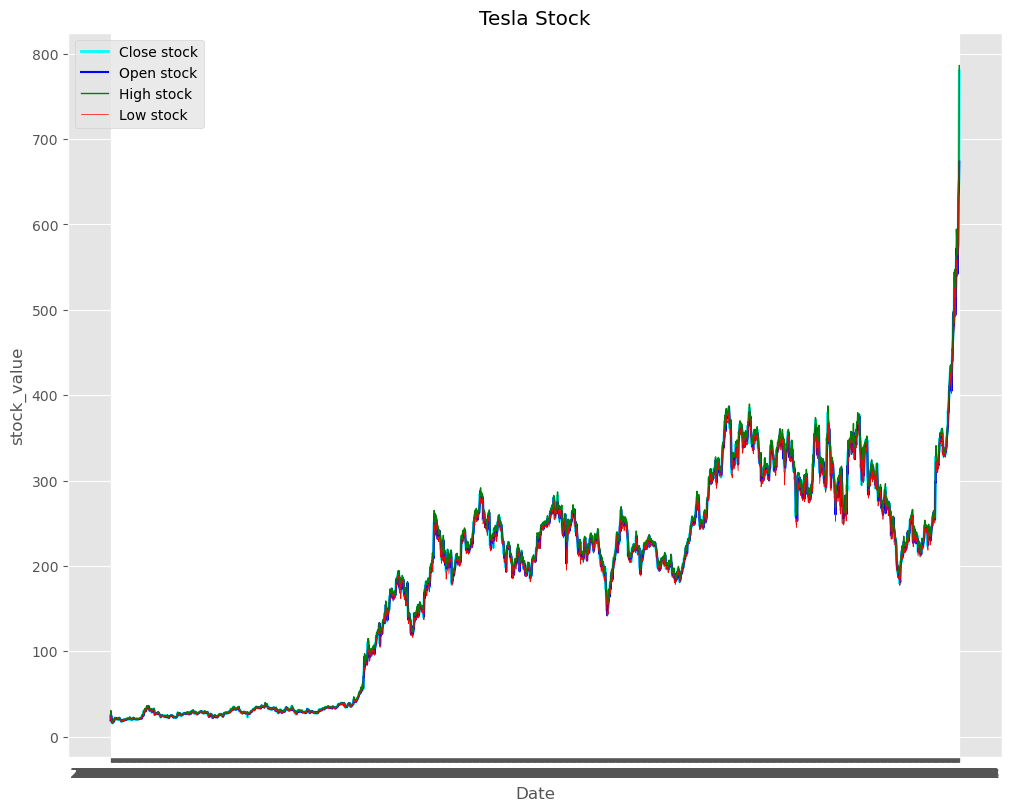

In [3]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [4]:
from PyEMD import CEEMDAN, Visualisation

In [5]:
close = df[['Close']].values

In [6]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
close_norm = scaler.fit_transform(close)
close_norm

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

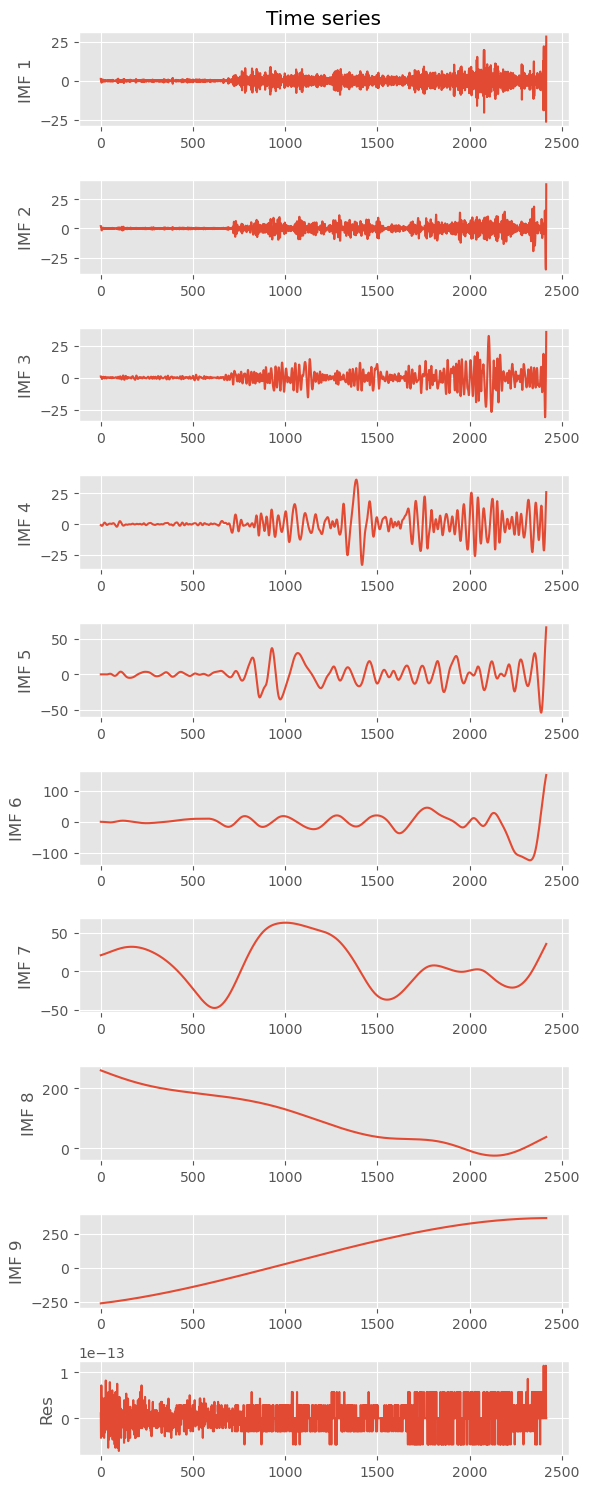

In [6]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2416, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [11]:
imfs_close[1][2400:2440]

array([ -1.13749601,   0.59577737,   1.48986297,  -1.83562631,
        -4.68758346,  -2.33326495,   6.96532623,  15.12446972,
        15.26797543,   5.72340519,  -8.86732749, -21.81095523,
       -30.40376187, -34.92318589,  -7.13925342,  37.56693438])

In [7]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [30]:
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
def create_model():
    model = Sequential()
    model.add(GRU(15, input_shape=(None,1)))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [34]:
def implement_GRU(X_train, y_train):
    param_grid = {'epochs': [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 
                              'batch_size': [4, 8, 10, 16, 18, 20, 24, 32]}
    
    model = KerasRegressor(build_fn=create_model)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
    
    
#     model = Sequential()
#     model.add(GRU(15, input_shape=(None,1)))
#     model.add(Dense(1))
#     model.summary()
#     model.compile(loss='mean_squared_error', optimizer='adam')
# #     model.compile(loss='mean_squared_error', optimizer='sgd')
#     model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)
    
    return grid_search.best_estimator_

In [11]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    X_train = sample[0:train_len]
    X_test = sample[train_len+1:length]
    y_train = label[0:train_len]
    y_test = label[train_len+1:length]
    
    return X_train, X_test, y_train, y_test
    

In [ ]:
i = 1
svr = []
prediction = []
actual = []

for imf in imfs_close:
#     print('-'*45)
#     print('This is  ' + str(i)  + '  time(s)')
#     print('*'*45)
    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.asarray(X_test)
    X_test = np.expand_dims(X_test, axis=2)
#     y_train = np.expand_dims(y_train, axis=3)
    
    tmp = implement_GRU(X_train, y_train)
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    i=i+1

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 15)                810       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
382/382 [==============================] - 2s 7ms/step - loss: 6.9262
Epoch 2/200
382/382 [==============================] - 2s 6ms/step - loss: 6.8263
Epoch 3/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7915
Epoch 4/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7550
Epoch 5/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7309
Epoch 6/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7120
Epoch 7/200
382/382 [=====

382/382 [==============================] - 2s 6ms/step - loss: 5.0660
Epoch 93/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0625
Epoch 94/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0519
Epoch 95/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0002
Epoch 96/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9497
Epoch 97/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9185
Epoch 98/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9625
Epoch 99/200
382/382 [==============================] - 3s 7ms/step - loss: 4.9482
Epoch 100/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9005
Epoch 101/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8311
Epoch 102/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8349
Epoch 103/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8124
Epoch 104/200

382/382 [==============================] - 2s 6ms/step - loss: 3.8065
Epoch 190/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8067
Epoch 191/200
382/382 [==============================] - 2s 6ms/step - loss: 4.0304
Epoch 192/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8289
Epoch 193/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6900
Epoch 194/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8914
Epoch 195/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2122
Epoch 196/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7963
Epoch 197/200
382/382 [==============================] - 2s 6ms/step - loss: 3.9494
Epoch 198/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2933
Epoch 199/200
382/382 [==============================] - 2s 6ms/step - loss: 4.1580
Epoch 200/200
382/382 [==============================] - 2s 6ms/step - loss: 3.9196
Model:

382/382 [==============================] - 2s 6ms/step - loss: 5.1255
Epoch 81/200
382/382 [==============================] - 2s 6ms/step - loss: 5.1584
Epoch 82/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0637
Epoch 83/200
382/382 [==============================] - 2s 6ms/step - loss: 5.1116
Epoch 84/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0802
Epoch 85/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0312
Epoch 86/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0417
Epoch 87/200
382/382 [==============================] - 2s 6ms/step - loss: 5.0051
Epoch 88/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9874
Epoch 89/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9666
Epoch 90/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9309
Epoch 91/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9689
Epoch 92/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.6781
Epoch 178/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5747
Epoch 179/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6426
Epoch 180/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6695
Epoch 181/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7804
Epoch 182/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5982
Epoch 183/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8607
Epoch 184/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5544
Epoch 185/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6976
Epoch 186/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6658
Epoch 187/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6144
Epoch 188/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6512
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.5587
Epoch 69/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5036
Epoch 70/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4871
Epoch 71/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4585
Epoch 72/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4737
Epoch 73/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4145
Epoch 74/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3652
Epoch 75/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3776
Epoch 76/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3785
Epoch 77/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3441
Epoch 78/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3587
Epoch 79/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3332
Epoch 80/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.6416
Epoch 167/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4958
Epoch 168/200
382/382 [==============================] - 2s 6ms/step - loss: 2.5712
Epoch 169/200
382/382 [==============================] - 2s 6ms/step - loss: 2.7119
Epoch 170/200
382/382 [==============================] - 2s 6ms/step - loss: 2.6888
Epoch 171/200
382/382 [==============================] - 2s 6ms/step - loss: 2.6164
Epoch 172/200
382/382 [==============================] - 2s 6ms/step - loss: 2.6326
Epoch 173/200
382/382 [==============================] - 2s 6ms/step - loss: 2.6567
Epoch 174/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4815
Epoch 175/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4967
Epoch 176/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4744
Epoch 177/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4528
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.3005
Epoch 58/200
382/382 [==============================] - 2s 6ms/step - loss: 4.3152
Epoch 59/200
382/382 [==============================] - 2s 6ms/step - loss: 4.3037
Epoch 60/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2854
Epoch 61/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2970
Epoch 62/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2468
Epoch 63/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2496
Epoch 64/200
382/382 [==============================] - 2s 6ms/step - loss: 4.1924
Epoch 65/200
382/382 [==============================] - 2s 6ms/step - loss: 4.2598
Epoch 66/200
382/382 [==============================] - 2s 6ms/step - loss: 4.1783
Epoch 67/200
382/382 [==============================] - 2s 6ms/step - loss: 4.1975
Epoch 68/200
382/382 [==============================] - 2s 6ms/step - loss: 4.1463
Epoch 69/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.0470
Epoch 156/200
382/382 [==============================] - 2s 6ms/step - loss: 3.0479
Epoch 157/200
382/382 [==============================] - 2s 6ms/step - loss: 3.0482
Epoch 158/200
382/382 [==============================] - 2s 6ms/step - loss: 3.0006
Epoch 159/200
382/382 [==============================] - 2s 6ms/step - loss: 3.1009
Epoch 160/200
382/382 [==============================] - 2s 6ms/step - loss: 2.9346
Epoch 161/200
382/382 [==============================] - 2s 6ms/step - loss: 2.9495
Epoch 162/200
382/382 [==============================] - 2s 6ms/step - loss: 2.8794
Epoch 163/200
382/382 [==============================] - 2s 6ms/step - loss: 2.9341
Epoch 164/200
382/382 [==============================] - 2s 6ms/step - loss: 2.9769
Epoch 165/200
382/382 [==============================] - 2s 6ms/step - loss: 2.8417
Epoch 166/200
382/382 [==============================] - 2s 6ms/step - loss: 2.9714
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.5490
Epoch 47/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5113
Epoch 48/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5059
Epoch 49/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4497
Epoch 50/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4505
Epoch 51/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4538
Epoch 52/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4428
Epoch 53/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4046
Epoch 54/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3890
Epoch 55/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3676
Epoch 56/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3431
Epoch 57/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3080
Epoch 58/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 1.8946
Epoch 145/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8381
Epoch 146/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8813
Epoch 147/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8569
Epoch 148/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8139
Epoch 149/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8151
Epoch 150/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8089
Epoch 151/200
382/382 [==============================] - 2s 6ms/step - loss: 2.2505
Epoch 152/200
382/382 [==============================] - 2s 6ms/step - loss: 2.5983
Epoch 153/200
382/382 [==============================] - 2s 6ms/step - loss: 2.1282
Epoch 154/200
382/382 [==============================] - 2s 6ms/step - loss: 1.9288
Epoch 155/200
382/382 [==============================] - 2s 6ms/step - loss: 1.8962
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.1782
Epoch 35/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2119
Epoch 36/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1826
Epoch 37/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1693
Epoch 38/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1669
Epoch 39/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1406
Epoch 40/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1362
Epoch 41/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1236
Epoch 42/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1172
Epoch 43/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1118
Epoch 44/225
382/382 [==============================] - 2s 6ms/step - loss: 6.0866
Epoch 45/225
382/382 [==============================] - 2s 6ms/step - loss: 6.0679
Epoch 46/225
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.6561
Epoch 133/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6015
Epoch 134/225
382/382 [==============================] - 2s 6ms/step - loss: 4.7697
Epoch 135/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6116
Epoch 136/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6101
Epoch 137/225
382/382 [==============================] - 2s 6ms/step - loss: 4.7329
Epoch 138/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5649
Epoch 139/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6742
Epoch 140/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6700
Epoch 141/225
382/382 [==============================] - 2s 6ms/step - loss: 4.8360
Epoch 142/225
382/382 [==============================] - 2s 6ms/step - loss: 4.4708
Epoch 143/225
382/382 [==============================] - 2s 6ms/step - loss: 4.4137
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.5518
Epoch 2/225
382/382 [==============================] - 2s 6ms/step - loss: 6.3951
Epoch 3/225
382/382 [==============================] - 2s 6ms/step - loss: 6.3432
Epoch 4/225
382/382 [==============================] - 2s 6ms/step - loss: 6.3257
Epoch 5/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2990
Epoch 6/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2803
Epoch 7/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2676
Epoch 8/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2599
Epoch 9/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2344
Epoch 10/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2388
Epoch 11/225
382/382 [==============================] - 2s 6ms/step - loss: 6.2060
Epoch 12/225
382/382 [==============================] - 2s 6ms/step - loss: 6.1919
Epoch 13/225
382/382 [===

Epoch 100/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6474
Epoch 101/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6610
Epoch 102/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5914
Epoch 103/225
382/382 [==============================] - 2s 6ms/step - loss: 4.6717
Epoch 104/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5749
Epoch 105/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5754
Epoch 106/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5799
Epoch 107/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5647
Epoch 108/225
382/382 [==============================] - 2s 6ms/step - loss: 4.5112
Epoch 109/225
382/382 [==============================] - 2s 6ms/step - loss: 4.4875
Epoch 110/225
382/382 [==============================] - 2s 6ms/step - loss: 4.4742
Epoch 111/225
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 2s 6ms/step - loss: 3.4716
Epoch 198/225
382/382 [==============================] - 2s 6ms/step - loss: 3.2465
Epoch 199/225
382/382 [==============================] - 2s 6ms/step - loss: 3.3004
Epoch 200/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5463
Epoch 201/225
382/382 [==============================] - 2s 6ms/step - loss: 3.4662
Epoch 202/225
382/382 [==============================] - 2s 6ms/step - loss: 3.2065
Epoch 203/225
382/382 [==============================] - 2s 6ms/step - loss: 3.1865
Epoch 204/225
382/382 [==============================] - 2s 6ms/step - loss: 3.2895
Epoch 205/225
382/382 [==============================] - 2s 6ms/step - loss: 3.7610
Epoch 206/225
382/382 [==============================] - 2s 6ms/step - loss: 3.3972
Epoch 207/225
382/382 [==============================] - 2s 6ms/step - loss: 3.6719
Epoch 208/225
382/382 [==============================] - 2s 6ms/step - loss: 3.4201
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.7180
Epoch 64/225
382/382 [==============================] - 2s 6ms/step - loss: 3.7005
Epoch 65/225
382/382 [==============================] - 2s 6ms/step - loss: 3.6702
Epoch 66/225
382/382 [==============================] - 2s 6ms/step - loss: 3.6347
Epoch 67/225
382/382 [==============================] - 2s 6ms/step - loss: 3.6166
Epoch 68/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5914
Epoch 69/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5776
Epoch 70/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5499
Epoch 71/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5314
Epoch 72/225
382/382 [==============================] - 2s 6ms/step - loss: 3.5090
Epoch 73/225
382/382 [==============================] - 2s 6ms/step - loss: 3.4839
Epoch 74/225
382/382 [==============================] - 2s 6ms/step - loss: 3.4526
Epoch 75/225
382/

382/382 [==============================] - 6s 16ms/step - loss: 1.8789
Epoch 161/225
382/382 [==============================] - 6s 16ms/step - loss: 2.0398
Epoch 162/225
382/382 [==============================] - 6s 15ms/step - loss: 1.9905
Epoch 163/225
382/382 [==============================] - 6s 16ms/step - loss: 1.9325
Epoch 164/225
382/382 [==============================] - 6s 16ms/step - loss: 1.9236
Epoch 165/225
382/382 [==============================] - 6s 16ms/step - loss: 1.8957
Epoch 166/225
382/382 [==============================] - 6s 16ms/step - loss: 2.4299
Epoch 167/225
382/382 [==============================] - 6s 16ms/step - loss: 2.2391
Epoch 168/225
382/382 [==============================] - 6s 16ms/step - loss: 1.9499
Epoch 169/225
382/382 [==============================] - 6s 16ms/step - loss: 1.8987
Epoch 170/225
382/382 [==============================] - 6s 16ms/step - loss: 1.8224
Epoch 171/225
382/382 [==============================] - 6s 16ms/step - loss: 2

382/382 [==============================] - 8s 21ms/step - loss: 4.7919
Epoch 25/225
382/382 [==============================] - 8s 20ms/step - loss: 4.7835
Epoch 26/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7819
Epoch 27/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7723
Epoch 28/225
382/382 [==============================] - 8s 20ms/step - loss: 4.7677
Epoch 29/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7488
Epoch 30/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7396
Epoch 31/225
382/382 [==============================] - 7s 19ms/step - loss: 4.7315
Epoch 32/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7223
Epoch 33/225
382/382 [==============================] - 8s 20ms/step - loss: 4.7211
Epoch 34/225
382/382 [==============================] - 7s 18ms/step - loss: 4.7098
Epoch 35/225
382/382 [==============================] - 8s 21ms/step - loss: 4.7025
Epoch

382/382 [==============================] - 2s 6ms/step - loss: 3.0526
Epoch 123/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0723
Epoch 124/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0019
Epoch 125/225
382/382 [==============================] - 2s 6ms/step - loss: 3.1124
Epoch 126/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0734
Epoch 127/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0328
Epoch 128/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9698
Epoch 129/225
382/382 [==============================] - 2s 6ms/step - loss: 2.8978
Epoch 130/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9553
Epoch 131/225
382/382 [==============================] - 2s 6ms/step - loss: 3.1925
Epoch 132/225
382/382 [==============================] - 2s 6ms/step - loss: 3.1301
Epoch 133/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0757
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.3464
Epoch 220/225
382/382 [==============================] - 2s 6ms/step - loss: 2.2227
Epoch 221/225
382/382 [==============================] - 2s 6ms/step - loss: 2.1920
Epoch 222/225
382/382 [==============================] - 2s 6ms/step - loss: 2.4436
Epoch 223/225
382/382 [==============================] - 2s 6ms/step - loss: 2.3723
Epoch 224/225
382/382 [==============================] - 2s 6ms/step - loss: 2.1959
Epoch 225/225
382/382 [==============================] - 2s 6ms/step - loss: 2.2244
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________

382/382 [==============================] - 2s 6ms/step - loss: 3.0875
Epoch 86/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0743
Epoch 87/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0445
Epoch 88/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0571
Epoch 89/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0247
Epoch 90/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0167
Epoch 91/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9688
Epoch 92/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0038
Epoch 93/225
382/382 [==============================] - 2s 6ms/step - loss: 3.0343
Epoch 94/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9503
Epoch 95/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9786
Epoch 96/225
382/382 [==============================] - 2s 6ms/step - loss: 2.9511
Epoch 97/225
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.2170
Epoch 183/225
382/382 [==============================] - 2s 6ms/step - loss: 2.0346
Epoch 184/225
382/382 [==============================] - 2s 6ms/step - loss: 2.1696
Epoch 185/225
382/382 [==============================] - 2s 6ms/step - loss: 1.9859
Epoch 186/225
382/382 [==============================] - 2s 6ms/step - loss: 2.0070
Epoch 187/225
382/382 [==============================] - 2s 6ms/step - loss: 2.0244
Epoch 188/225
382/382 [==============================] - 2s 6ms/step - loss: 2.1651
Epoch 189/225
382/382 [==============================] - 2s 6ms/step - loss: 2.1534
Epoch 190/225
382/382 [==============================] - 2s 6ms/step - loss: 1.9597
Epoch 191/225
382/382 [==============================] - 2s 6ms/step - loss: 1.9984
Epoch 192/225
382/382 [==============================] - 2s 6ms/step - loss: 1.9360
Epoch 193/225
382/382 [==============================] - 2s 6ms/step - loss: 2.0545
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.0943
Epoch 49/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0924
Epoch 50/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0552
Epoch 51/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0550
Epoch 52/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0335
Epoch 53/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0263
Epoch 54/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0000
Epoch 55/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9814
Epoch 56/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9569
Epoch 57/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9590
Epoch 58/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9510
Epoch 59/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9052
Epoch 60/250
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.3552
Epoch 147/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4239
Epoch 148/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4536
Epoch 149/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3157
Epoch 150/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3324
Epoch 151/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4073
Epoch 152/250
382/382 [==============================] - 2s 6ms/step - loss: 4.6254
Epoch 153/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2962
Epoch 154/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3509
Epoch 155/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2246
Epoch 156/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3907
Epoch 157/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4236
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.9845
Epoch 244/250
382/382 [==============================] - 2s 6ms/step - loss: 3.8835
Epoch 245/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5851
Epoch 246/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5677
Epoch 247/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5557
Epoch 248/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5931
Epoch 249/250
382/382 [==============================] - 2s 6ms/step - loss: 3.7159
Epoch 250/250
382/382 [==============================] - 2s 6ms/step - loss: 3.6577
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 

382/382 [==============================] - 2s 6ms/step - loss: 5.0128
Epoch 85/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8897
Epoch 86/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8942
Epoch 87/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8603
Epoch 88/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8031
Epoch 89/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8493
Epoch 90/250
382/382 [==============================] - 2s 6ms/step - loss: 4.7651
Epoch 91/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8246
Epoch 92/250
382/382 [==============================] - 2s 6ms/step - loss: 4.8486
Epoch 93/250
382/382 [==============================] - 2s 6ms/step - loss: 4.7654
Epoch 94/250
382/382 [==============================] - 2s 6ms/step - loss: 4.7812
Epoch 95/250
382/382 [==============================] - 2s 6ms/step - loss: 4.7327
Epoch 96/250
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.5493
Epoch 182/250
382/382 [==============================] - 2s 6ms/step - loss: 3.7353
Epoch 183/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5196
Epoch 184/250
382/382 [==============================] - 2s 6ms/step - loss: 3.6101
Epoch 185/250
382/382 [==============================] - 2s 6ms/step - loss: 3.4155
Epoch 186/250
382/382 [==============================] - 2s 6ms/step - loss: 3.4980
Epoch 187/250
382/382 [==============================] - 2s 6ms/step - loss: 3.4891
Epoch 188/250
382/382 [==============================] - 2s 6ms/step - loss: 3.5186
Epoch 189/250
382/382 [==============================] - 2s 6ms/step - loss: 3.4187
Epoch 190/250
382/382 [==============================] - 2s 6ms/step - loss: 3.6948
Epoch 191/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1219
Epoch 192/250
382/382 [==============================] - 2s 6ms/step - loss: 3.8813
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.3634
Epoch 22/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3495
Epoch 23/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3304
Epoch 24/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3231
Epoch 25/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3113
Epoch 26/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3048
Epoch 27/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2838
Epoch 28/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2653
Epoch 29/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2358
Epoch 30/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2316
Epoch 31/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2271
Epoch 32/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2288
Epoch 33/250
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.8448
Epoch 120/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8036
Epoch 121/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8066
Epoch 122/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8134
Epoch 123/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7939
Epoch 124/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7536
Epoch 125/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7712
Epoch 126/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7791
Epoch 127/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7796
Epoch 128/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8043
Epoch 129/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7143
Epoch 130/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7537
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.4008
Epoch 217/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2748
Epoch 218/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1725
Epoch 219/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1767
Epoch 220/250
382/382 [==============================] - 2s 6ms/step - loss: 2.0447
Epoch 221/250
382/382 [==============================] - 2s 6ms/step - loss: 2.0790
Epoch 222/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1103
Epoch 223/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2056
Epoch 224/250
382/382 [==============================] - 2s 6ms/step - loss: 2.6740
Epoch 225/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2948
Epoch 226/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1913
Epoch 227/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2595
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.2991
Epoch 57/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2925
Epoch 58/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2385
Epoch 59/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2568
Epoch 60/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1900
Epoch 61/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1919
Epoch 62/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1901
Epoch 63/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1337
Epoch 64/250
382/382 [==============================] - 2s 6ms/step - loss: 4.1296
Epoch 65/250
382/382 [==============================] - 2s 6ms/step - loss: 4.0835
Epoch 66/250
382/382 [==============================] - 2s 6ms/step - loss: 4.0973
Epoch 67/250
382/382 [==============================] - 2s 6ms/step - loss: 4.0931
Epoch 68/250
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.0474
Epoch 155/250
382/382 [==============================] - 2s 6ms/step - loss: 2.9173
Epoch 156/250
382/382 [==============================] - 2s 6ms/step - loss: 2.9220
Epoch 157/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8042
Epoch 158/250
382/382 [==============================] - 2s 6ms/step - loss: 3.0025
Epoch 159/250
382/382 [==============================] - 2s 6ms/step - loss: 3.0581
Epoch 160/250
382/382 [==============================] - 2s 6ms/step - loss: 2.9165
Epoch 161/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7832
Epoch 162/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7590
Epoch 163/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7354
Epoch 164/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8028
Epoch 165/250
382/382 [==============================] - 2s 6ms/step - loss: 3.6765
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.5802
Epoch 2/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4134
Epoch 3/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3467
Epoch 4/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3221
Epoch 5/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3020
Epoch 6/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2869
Epoch 7/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2767
Epoch 8/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2528
Epoch 9/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2489
Epoch 10/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2300
Epoch 11/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2248
Epoch 12/250
382/382 [==============================] - 2s 6ms/step - loss: 4.2048
Epoch 13/250
382/382 [===

Epoch 100/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2973
Epoch 101/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2669
Epoch 102/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2363
Epoch 103/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2292
Epoch 104/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1842
Epoch 105/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2128
Epoch 106/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2058
Epoch 107/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1706
Epoch 108/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1335
Epoch 109/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2436
Epoch 110/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2036
Epoch 111/250
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 2s 6ms/step - loss: 1.4894
Epoch 198/250
382/382 [==============================] - 2s 6ms/step - loss: 1.5704
Epoch 199/250
382/382 [==============================] - 2s 6ms/step - loss: 1.8244
Epoch 200/250
382/382 [==============================] - 2s 6ms/step - loss: 1.8833
Epoch 201/250
382/382 [==============================] - 2s 6ms/step - loss: 1.5432
Epoch 202/250
382/382 [==============================] - 2s 6ms/step - loss: 1.5371
Epoch 203/250
382/382 [==============================] - 2s 6ms/step - loss: 1.4208
Epoch 204/250
382/382 [==============================] - 2s 6ms/step - loss: 1.4938
Epoch 205/250
382/382 [==============================] - 2s 6ms/step - loss: 1.3705
Epoch 206/250
382/382 [==============================] - 2s 6ms/step - loss: 1.3758
Epoch 207/250
382/382 [==============================] - 2s 6ms/step - loss: 1.4784
Epoch 208/250
382/382 [==============================] - 2s 6ms/step - loss: 1.4388
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.1547
Epoch 38/275
382/382 [==============================] - 2s 6ms/step - loss: 6.1663
Epoch 39/275
382/382 [==============================] - 2s 6ms/step - loss: 6.1204
Epoch 40/275
382/382 [==============================] - 2s 6ms/step - loss: 6.1014
Epoch 41/275
382/382 [==============================] - 2s 6ms/step - loss: 6.1074
Epoch 42/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0757
Epoch 43/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0485
Epoch 44/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0565
Epoch 45/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0025
Epoch 46/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0168
Epoch 47/275
382/382 [==============================] - 2s 6ms/step - loss: 5.9739
Epoch 48/275
382/382 [==============================] - 2s 6ms/step - loss: 5.9833
Epoch 49/275
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.3325
Epoch 136/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2288
Epoch 137/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1340
Epoch 138/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2237
Epoch 139/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1321
Epoch 140/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2567
Epoch 141/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1271
Epoch 142/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1792
Epoch 143/275
382/382 [==============================] - 2s 6ms/step - loss: 4.3663
Epoch 144/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0636
Epoch 145/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0857
Epoch 146/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2098
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.1205
Epoch 233/275
382/382 [==============================] - 2s 6ms/step - loss: 3.1728
Epoch 234/275
382/382 [==============================] - 2s 6ms/step - loss: 4.8666
Epoch 235/275
382/382 [==============================] - 2s 6ms/step - loss: 6.0461
Epoch 236/275
382/382 [==============================] - 2s 6ms/step - loss: 4.8482
Epoch 237/275
382/382 [==============================] - 2s 6ms/step - loss: 3.7792
Epoch 238/275
382/382 [==============================] - 2s 6ms/step - loss: 3.4098
Epoch 239/275
382/382 [==============================] - 2s 6ms/step - loss: 3.2771
Epoch 240/275
382/382 [==============================] - 2s 6ms/step - loss: 3.1868
Epoch 241/275
382/382 [==============================] - 2s 6ms/step - loss: 3.2115
Epoch 242/275
382/382 [==============================] - 2s 6ms/step - loss: 3.1957
Epoch 243/275
382/382 [==============================] - 2s 6ms/step - loss: 3.5663
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 5.6276
Epoch 49/275
382/382 [==============================] - 2s 6ms/step - loss: 5.6216
Epoch 50/275
382/382 [==============================] - 2s 7ms/step - loss: 5.6075
Epoch 51/275
382/382 [==============================] - 2s 6ms/step - loss: 5.5836
Epoch 52/275
382/382 [==============================] - 2s 6ms/step - loss: 5.5599
Epoch 53/275
382/382 [==============================] - 2s 6ms/step - loss: 5.5366
Epoch 54/275
382/382 [==============================] - 2s 6ms/step - loss: 5.4753
Epoch 55/275
382/382 [==============================] - 2s 6ms/step - loss: 5.5122
Epoch 56/275
382/382 [==============================] - 2s 6ms/step - loss: 5.4689
Epoch 57/275
382/382 [==============================] - 2s 6ms/step - loss: 5.4541
Epoch 58/275
382/382 [==============================] - 2s 6ms/step - loss: 5.4185
Epoch 59/275
382/382 [==============================] - 2s 6ms/step - loss: 5.4216
Epoch 60/275
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.1087
Epoch 147/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2026
Epoch 148/275
382/382 [==============================] - 2s 6ms/step - loss: 4.2875
Epoch 149/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1803
Epoch 150/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1016
Epoch 151/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0592
Epoch 152/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0505
Epoch 153/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9925
Epoch 154/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9509
Epoch 155/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0202
Epoch 156/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0951
Epoch 157/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1588
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.4143
Epoch 244/275
382/382 [==============================] - 2s 6ms/step - loss: 3.3008
Epoch 245/275
382/382 [==============================] - 2s 6ms/step - loss: 3.4140
Epoch 246/275
382/382 [==============================] - 2s 6ms/step - loss: 3.4570
Epoch 247/275
382/382 [==============================] - 2s 6ms/step - loss: 3.7011
Epoch 248/275
382/382 [==============================] - 2s 6ms/step - loss: 3.3333
Epoch 249/275
382/382 [==============================] - 2s 6ms/step - loss: 3.4082
Epoch 250/275
382/382 [==============================] - 2s 6ms/step - loss: 3.2842
Epoch 251/275
382/382 [==============================] - 2s 6ms/step - loss: 3.2979
Epoch 252/275
382/382 [==============================] - ETA: 0s - loss: 3.202 - 2s 6ms/step - loss: 3.2154
Epoch 253/275
382/382 [==============================] - 2s 6ms/step - loss: 3.0664
Epoch 254/275
382/382 [==============================] - 2s 6ms/st

382/382 [==============================] - 2s 6ms/step - loss: 3.9701
Epoch 59/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9644
Epoch 60/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9527
Epoch 61/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9232
Epoch 62/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9204
Epoch 63/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8938
Epoch 64/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8658
Epoch 65/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9015
Epoch 66/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8479
Epoch 67/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8409
Epoch 68/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8461
Epoch 69/275
382/382 [==============================] - 2s 6ms/step - loss: 3.8120
Epoch 70/275
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.7064
Epoch 157/275
382/382 [==============================] - 2s 6ms/step - loss: 3.3103
Epoch 158/275
382/382 [==============================] - 2s 6ms/step - loss: 3.3085
Epoch 159/275
382/382 [==============================] - 3s 7ms/step - loss: 2.8390
Epoch 160/275
382/382 [==============================] - 3s 7ms/step - loss: 2.7046
Epoch 161/275
382/382 [==============================] - 2s 6ms/step - loss: 2.6573
Epoch 162/275
382/382 [==============================] - 3s 7ms/step - loss: 2.6125
Epoch 163/275
382/382 [==============================] - 3s 7ms/step - loss: 2.6634
Epoch 164/275
382/382 [==============================] - 2s 6ms/step - loss: 2.6000
Epoch 165/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5148
Epoch 166/275
382/382 [==============================] - 3s 7ms/step - loss: 2.5353
Epoch 167/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5110
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.1103
Epoch 254/275
382/382 [==============================] - 2s 6ms/step - loss: 2.0112
Epoch 255/275
382/382 [==============================] - 2s 6ms/step - loss: 2.0144
Epoch 256/275
382/382 [==============================] - 2s 6ms/step - loss: 2.1950
Epoch 257/275
382/382 [==============================] - 2s 6ms/step - loss: 2.1405
Epoch 258/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9046
Epoch 259/275
382/382 [==============================] - 2s 6ms/step - loss: 1.8680
Epoch 260/275
382/382 [==============================] - 2s 6ms/step - loss: 1.8846
Epoch 261/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9190
Epoch 262/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9957
Epoch 263/275
382/382 [==============================] - 3s 7ms/step - loss: 2.0665
Epoch 264/275
382/382 [==============================] - 2s 6ms/step - loss: 1.8962
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.1429
Epoch 70/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1250
Epoch 71/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1296
Epoch 72/275
382/382 [==============================] - 2s 6ms/step - loss: 4.1047
Epoch 73/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0728
Epoch 74/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0602
Epoch 75/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0545
Epoch 76/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0380
Epoch 77/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0276
Epoch 78/275
382/382 [==============================] - 2s 6ms/step - loss: 4.0140
Epoch 79/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9728
Epoch 80/275
382/382 [==============================] - 2s 6ms/step - loss: 3.9855
Epoch 81/275
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.6043
Epoch 168/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5294
Epoch 169/275
382/382 [==============================] - 2s 6ms/step - loss: 2.6462
Epoch 170/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5602
Epoch 171/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5289
Epoch 172/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4600
Epoch 173/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4538
Epoch 174/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5671
Epoch 175/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4798
Epoch 176/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4551
Epoch 177/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4140
Epoch 178/275
382/382 [==============================] - 2s 6ms/step - loss: 2.4561
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.9205
Epoch 265/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9172
Epoch 266/275
382/382 [==============================] - 2s 6ms/step - loss: 1.8356
Epoch 267/275
382/382 [==============================] - 2s 6ms/step - loss: 2.5828
Epoch 268/275
382/382 [==============================] - 2s 6ms/step - loss: 2.7249
Epoch 269/275
382/382 [==============================] - 2s 6ms/step - loss: 2.0250
Epoch 270/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9345
Epoch 271/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9063
Epoch 272/275
382/382 [==============================] - 2s 6ms/step - loss: 1.8118
Epoch 273/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7395
Epoch 274/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7188
Epoch 275/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7765
Model:

382/382 [==============================] - 2s 6ms/step - loss: 3.0473
Epoch 81/275
382/382 [==============================] - 2s 6ms/step - loss: 3.0029
Epoch 82/275
382/382 [==============================] - 2s 6ms/step - loss: 2.9812
Epoch 83/275
382/382 [==============================] - 2s 6ms/step - loss: 2.9573
Epoch 84/275
382/382 [==============================] - 2s 6ms/step - loss: 2.9085
Epoch 85/275
382/382 [==============================] - 2s 6ms/step - loss: 2.9059
Epoch 86/275
382/382 [==============================] - 2s 6ms/step - loss: 2.8395
Epoch 87/275
382/382 [==============================] - 2s 6ms/step - loss: 2.8072
Epoch 88/275
382/382 [==============================] - 2s 6ms/step - loss: 2.8100
Epoch 89/275
382/382 [==============================] - 2s 6ms/step - loss: 2.7712
Epoch 90/275
382/382 [==============================] - 2s 6ms/step - loss: 2.7164
Epoch 91/275
382/382 [==============================] - 2s 6ms/step - loss: 2.6993
Epoch 92/275
382/

382/382 [==============================] - 2s 6ms/step - loss: 1.6762
Epoch 178/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7658
Epoch 179/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7251
Epoch 180/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7204
Epoch 181/275
382/382 [==============================] - 2s 6ms/step - loss: 1.6650
Epoch 182/275
382/382 [==============================] - 2s 6ms/step - loss: 1.6505
Epoch 183/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7506
Epoch 184/275
382/382 [==============================] - 2s 6ms/step - loss: 1.6030
Epoch 185/275
382/382 [==============================] - 2s 6ms/step - loss: 1.5890
Epoch 186/275
382/382 [==============================] - 2s 6ms/step - loss: 1.6929
Epoch 187/275
382/382 [==============================] - 2s 6ms/step - loss: 1.9245
Epoch 188/275
382/382 [==============================] - 2s 6ms/step - loss: 1.7096
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.3984
Epoch 275/275
382/382 [==============================] - 2s 6ms/step - loss: 1.2570
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
382/382 [==============================] - 3s 7ms/step - loss: 6.9560
Epoch 2/300
382/382 [==============================] - 2s 6ms/step - loss: 6.8033
Epoch 3/300
382/382 [==============================] - 3s 7ms/step - loss: 6.7463
Epoch 4/300
382/382 [==============================] - 2s 7ms/step - loss: 6.7212
Epoch 5/300
382/382 [==============

382/382 [==============================] - 2s 6ms/step - loss: 5.4390
Epoch 91/300
382/382 [==============================] - 2s 6ms/step - loss: 5.4463
Epoch 92/300
382/382 [==============================] - 2s 6ms/step - loss: 5.4861
Epoch 93/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3791
Epoch 94/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3673
Epoch 95/300
382/382 [==============================] - 2s 7ms/step - loss: 5.4686
Epoch 96/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3664
Epoch 97/300
382/382 [==============================] - 2s 7ms/step - loss: 5.3349
Epoch 98/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3238
Epoch 99/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3444
Epoch 100/300
382/382 [==============================] - 2s 6ms/step - loss: 5.3317
Epoch 101/300
382/382 [==============================] - 2s 6ms/step - loss: 5.2672
Epoch 102/300
3

382/382 [==============================] - 2s 6ms/step - loss: 4.3658
Epoch 188/300
382/382 [==============================] - 2s 6ms/step - loss: 4.2353
Epoch 189/300
382/382 [==============================] - 2s 6ms/step - loss: 4.6255
Epoch 190/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3583
Epoch 191/300
382/382 [==============================] - 2s 6ms/step - loss: 4.1034
Epoch 192/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0663
Epoch 193/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3309
Epoch 194/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3369
Epoch 195/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0472
Epoch 196/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0732
Epoch 197/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0420
Epoch 198/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0491
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.5629
Epoch 285/300
382/382 [==============================] - 2s 6ms/step - loss: 4.1774
Epoch 286/300
382/382 [==============================] - 2s 6ms/step - loss: 4.6628
Epoch 287/300
382/382 [==============================] - 2s 6ms/step - loss: 4.4440
Epoch 288/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9820
Epoch 289/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8130
Epoch 290/300
382/382 [==============================] - 2s 6ms/step - loss: 3.6222
Epoch 291/300
382/382 [==============================] - 2s 6ms/step - loss: 3.5130
Epoch 292/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4558
Epoch 293/300
382/382 [==============================] - 2s 6ms/step - loss: 3.5762
Epoch 294/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4688
Epoch 295/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4122
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.4670
Epoch 76/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3826
Epoch 77/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3722
Epoch 78/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3101
Epoch 79/300
382/382 [==============================] - 2s 6ms/step - loss: 4.3510
Epoch 80/300
382/382 [==============================] - 2s 6ms/step - loss: 4.2858
Epoch 81/300
382/382 [==============================] - 2s 6ms/step - loss: 4.2175
Epoch 82/300
382/382 [==============================] - 2s 6ms/step - loss: 4.1492
Epoch 83/300
382/382 [==============================] - 2s 6ms/step - loss: 4.1442
Epoch 84/300
382/382 [==============================] - 2s 6ms/step - loss: 4.2070
Epoch 85/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0904
Epoch 86/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0821
Epoch 87/300
382/

Epoch 173/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9279
Epoch 174/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9030
Epoch 175/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9309
Epoch 176/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9794
Epoch 177/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9713
Epoch 178/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9533
Epoch 179/300
382/382 [==============================] - 2s 6ms/step - loss: 3.0202
Epoch 180/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1019
Epoch 181/300
382/382 [==============================] - 2s 6ms/step - loss: 3.0204
Epoch 182/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9850
Epoch 183/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1637
Epoch 184/300
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 2s 6ms/step - loss: 2.5936
Epoch 271/300
382/382 [==============================] - 2s 6ms/step - loss: 2.3581
Epoch 272/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8449
Epoch 273/300
382/382 [==============================] - 2s 6ms/step - loss: 2.5340
Epoch 274/300
382/382 [==============================] - 2s 6ms/step - loss: 2.3613
Epoch 275/300
382/382 [==============================] - 2s 6ms/step - loss: 2.3772
Epoch 276/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4260
Epoch 277/300
382/382 [==============================] - 3s 7ms/step - loss: 2.4936
Epoch 278/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4776
Epoch 279/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4372
Epoch 280/300
382/382 [==============================] - 2s 6ms/step - loss: 2.7672
Epoch 281/300
382/382 [==============================] - 2s 6ms/step - loss: 2.5153
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.9163
Epoch 62/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9101
Epoch 63/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9086
Epoch 64/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8886
Epoch 65/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8942
Epoch 66/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8711
Epoch 67/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8682
Epoch 68/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8479
Epoch 69/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8321
Epoch 70/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8206
Epoch 71/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8092
Epoch 72/300
382/382 [==============================] - ETA: 0s - loss: 3.813 - 2s 6ms/step - loss: 

382/382 [==============================] - 2s 7ms/step - loss: 2.6775
Epoch 159/300
382/382 [==============================] - 2s 6ms/step - loss: 2.7488
Epoch 160/300
382/382 [==============================] - 2s 6ms/step - loss: 2.5860
Epoch 161/300
382/382 [==============================] - 2s 7ms/step - loss: 2.7084
Epoch 162/300
382/382 [==============================] - 3s 7ms/step - loss: 2.7909
Epoch 163/300
382/382 [==============================] - 2s 7ms/step - loss: 2.5642
Epoch 164/300
382/382 [==============================] - 2s 6ms/step - loss: 2.6169
Epoch 165/300
382/382 [==============================] - 2s 7ms/step - loss: 2.6146
Epoch 166/300
382/382 [==============================] - 2s 7ms/step - loss: 2.6426
Epoch 167/300
382/382 [==============================] - 3s 7ms/step - loss: 2.5240
Epoch 168/300
382/382 [==============================] - 2s 6ms/step - loss: 2.5829
Epoch 169/300
382/382 [==============================] - 3s 7ms/step - loss: 2.4949
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.3692
Epoch 256/300
382/382 [==============================] - 2s 6ms/step - loss: 2.2096
Epoch 257/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0750
Epoch 258/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0297
Epoch 259/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1514
Epoch 260/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0408
Epoch 261/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0480
Epoch 262/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0037
Epoch 263/300
382/382 [==============================] - 2s 6ms/step - loss: 1.8980
Epoch 264/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1583
Epoch 265/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1693
Epoch 266/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1442
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 4.5320
Epoch 47/300
382/382 [==============================] - 3s 7ms/step - loss: 4.5248
Epoch 48/300
382/382 [==============================] - 3s 7ms/step - loss: 4.5043
Epoch 49/300
382/382 [==============================] - 3s 7ms/step - loss: 4.4931
Epoch 50/300
382/382 [==============================] - 3s 7ms/step - loss: 4.4854
Epoch 51/300
382/382 [==============================] - 3s 7ms/step - loss: 4.4686
Epoch 52/300
382/382 [==============================] - 3s 7ms/step - loss: 4.4374
Epoch 53/300
382/382 [==============================] - 3s 7ms/step - loss: 4.4320
Epoch 54/300
382/382 [==============================] - 3s 7ms/step - loss: 4.3977
Epoch 55/300
382/382 [==============================] - 3s 7ms/step - loss: 4.3808
Epoch 56/300
382/382 [==============================] - 3s 7ms/step - loss: 4.3525
Epoch 57/300
382/382 [==============================] - 3s 7ms/step - loss: 4.3514
Epoch 58/300
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.9206
Epoch 145/300
382/382 [==============================] - 2s 7ms/step - loss: 2.9906
Epoch 146/300
382/382 [==============================] - 2s 7ms/step - loss: 2.9426
Epoch 147/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1834
Epoch 148/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9882
Epoch 149/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9829
Epoch 150/300
382/382 [==============================] - 2s 6ms/step - loss: 3.0073
Epoch 151/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8902
Epoch 152/300
382/382 [==============================] - 2s 6ms/step - loss: 3.0977
Epoch 153/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9810
Epoch 154/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8978
Epoch 155/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8923
Epoch 

382/382 [==============================] - ETA: 0s - loss: 2.540 - 2s 6ms/step - loss: 2.5354
Epoch 242/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8551
Epoch 243/300
382/382 [==============================] - 2s 6ms/step - loss: 2.7600
Epoch 244/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8530
Epoch 245/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4944
Epoch 246/300
382/382 [==============================] - 2s 6ms/step - loss: 2.6188
Epoch 247/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4407
Epoch 248/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4673
Epoch 249/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4053
Epoch 250/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4453
Epoch 251/300
382/382 [==============================] - 2s 6ms/step - loss: 2.4360
Epoch 252/300
382/382 [==============================] - 2s 6ms/st

382/382 [==============================] - 2s 6ms/step - loss: 3.9904
Epoch 32/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9581
Epoch 33/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9538
Epoch 34/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9355
Epoch 35/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9013
Epoch 36/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8923
Epoch 37/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8650
Epoch 38/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8425
Epoch 39/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8316
Epoch 40/300
382/382 [==============================] - 2s 6ms/step - loss: 3.8134
Epoch 41/300
382/382 [==============================] - 2s 6ms/step - loss: 3.7900
Epoch 42/300
382/382 [==============================] - 2s 6ms/step - loss: 3.7524
Epoch 43/300
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.0954
Epoch 130/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0767
Epoch 131/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0711
Epoch 132/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0389
Epoch 133/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0318
Epoch 134/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0463
Epoch 135/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0080
Epoch 136/300
382/382 [==============================] - 2s 6ms/step - loss: 2.2110
Epoch 137/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0233
Epoch 138/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9859
Epoch 139/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9534
Epoch 140/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9584
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.4293
Epoch 227/300
382/382 [==============================] - 2s 6ms/step - loss: 1.4805
Epoch 228/300
382/382 [==============================] - 2s 6ms/step - loss: 1.4556
Epoch 229/300
382/382 [==============================] - 2s 6ms/step - loss: 1.5957
Epoch 230/300
382/382 [==============================] - 2s 6ms/step - loss: 1.6647
Epoch 231/300
382/382 [==============================] - 2s 6ms/step - loss: 1.4972
Epoch 232/300
382/382 [==============================] - 2s 6ms/step - loss: 1.5874
Epoch 233/300
382/382 [==============================] - 2s 6ms/step - loss: 1.5472
Epoch 234/300
382/382 [==============================] - 2s 6ms/step - loss: 2.2001
Epoch 235/300
382/382 [==============================] - 2s 6ms/step - loss: 1.5731
Epoch 236/300
382/382 [==============================] - 2s 6ms/step - loss: 1.4125
Epoch 237/300
382/382 [==============================] - 2s 6ms/step - loss: 1.4205
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.4753
Epoch 17/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4547
Epoch 18/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4518
Epoch 19/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4420
Epoch 20/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4382
Epoch 21/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4093
Epoch 22/325
382/382 [==============================] - 2s 6ms/step - loss: 6.3965
Epoch 23/325
382/382 [==============================] - 2s 6ms/step - loss: 6.4056
Epoch 24/325
382/382 [==============================] - 2s 6ms/step - loss: 6.3857
Epoch 25/325
382/382 [==============================] - 2s 6ms/step - loss: 6.3806
Epoch 26/325
382/382 [==============================] - 2s 6ms/step - loss: 6.3743
Epoch 27/325
382/382 [==============================] - 2s 6ms/step - loss: 6.3696
Epoch 28/325
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.5967
Epoch 115/325
382/382 [==============================] - 2s 6ms/step - loss: 4.5992
Epoch 116/325
382/382 [==============================] - 2s 6ms/step - loss: 4.5506
Epoch 117/325
382/382 [==============================] - 2s 6ms/step - loss: 4.5549
Epoch 118/325
382/382 [==============================] - 2s 6ms/step - loss: 4.6240
Epoch 119/325
382/382 [==============================] - 2s 6ms/step - loss: 4.5283
Epoch 120/325
382/382 [==============================] - 2s 6ms/step - loss: 4.4593
Epoch 121/325
382/382 [==============================] - 2s 6ms/step - loss: 4.4405
Epoch 122/325
382/382 [==============================] - 2s 6ms/step - loss: 4.4486
Epoch 123/325
382/382 [==============================] - 2s 6ms/step - loss: 4.4649
Epoch 124/325
382/382 [==============================] - 2s 6ms/step - loss: 4.4175
Epoch 125/325
382/382 [==============================] - 2s 6ms/step - loss: 4.7532
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.4197
Epoch 212/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4352
Epoch 213/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3425
Epoch 214/325
382/382 [==============================] - 2s 6ms/step - loss: 3.2968
Epoch 215/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3185
Epoch 216/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6493
Epoch 217/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4879
Epoch 218/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5480
Epoch 219/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3491
Epoch 220/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4179
Epoch 221/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3709
Epoch 222/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3865
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.1474
Epoch 309/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0780
Epoch 310/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0048
Epoch 311/325
382/382 [==============================] - 2s 6ms/step - loss: 4.2013
Epoch 312/325
382/382 [==============================] - 2s 6ms/step - loss: 3.1225
Epoch 313/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9602
Epoch 314/325
382/382 [==============================] - 2s 6ms/step - loss: 3.1110
Epoch 315/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9599
Epoch 316/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0892
Epoch 317/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9723
Epoch 318/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0610
Epoch 319/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5738
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 5.3908
Epoch 75/325
382/382 [==============================] - 2s 6ms/step - loss: 5.3849
Epoch 76/325
382/382 [==============================] - 2s 6ms/step - loss: 5.3639
Epoch 77/325
382/382 [==============================] - 2s 6ms/step - loss: 5.3462
Epoch 78/325
382/382 [==============================] - 2s 6ms/step - loss: 5.3049
Epoch 79/325
382/382 [==============================] - 2s 6ms/step - loss: 5.3195
Epoch 80/325
382/382 [==============================] - 2s 6ms/step - loss: 5.2626
Epoch 81/325
382/382 [==============================] - 2s 6ms/step - loss: 5.2195
Epoch 82/325
382/382 [==============================] - 2s 6ms/step - loss: 5.2414
Epoch 83/325
382/382 [==============================] - 2s 6ms/step - loss: 5.2326
Epoch 84/325
382/382 [==============================] - 2s 6ms/step - loss: 5.1807
Epoch 85/325
382/382 [==============================] - 2s 6ms/step - loss: 5.1957
Epoch 86/325
382/

Epoch 172/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6926
Epoch 173/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6550
Epoch 174/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5931
Epoch 175/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6065
Epoch 176/325
382/382 [==============================] - 2s 6ms/step - loss: 4.0857
Epoch 177/325
382/382 [==============================] - 2s 6ms/step - loss: 3.7512
Epoch 178/325
382/382 [==============================] - 2s 6ms/step - loss: 3.8361
Epoch 179/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6979
Epoch 180/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6442
Epoch 181/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5600
Epoch 182/325
382/382 [==============================] - 2s 6ms/step - loss: 3.6750
Epoch 183/325
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 2s 6ms/step - loss: 2.9596
Epoch 270/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9630
Epoch 271/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0626
Epoch 272/325
382/382 [==============================] - 2s 6ms/step - loss: 2.8484
Epoch 273/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9223
Epoch 274/325
382/382 [==============================] - 2s 6ms/step - loss: 2.8327
Epoch 275/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0968
Epoch 276/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9337
Epoch 277/325
382/382 [==============================] - 2s 6ms/step - loss: 2.7565
Epoch 278/325
382/382 [==============================] - 2s 6ms/step - loss: 2.7231
Epoch 279/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9700
Epoch 280/325
382/382 [==============================] - 2s 6ms/step - loss: 2.7370
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 4.1177
Epoch 35/325
382/382 [==============================] - 3s 7ms/step - loss: 4.1139
Epoch 36/325
382/382 [==============================] - 3s 7ms/step - loss: 4.1138
Epoch 37/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0933
Epoch 38/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0774
Epoch 39/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0743
Epoch 40/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0361
Epoch 41/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0605
Epoch 42/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0129
Epoch 43/325
382/382 [==============================] - 3s 7ms/step - loss: 4.0237
Epoch 44/325
382/382 [==============================] - 3s 7ms/step - loss: 3.9961
Epoch 45/325
382/382 [==============================] - 3s 7ms/step - loss: 3.9880
Epoch 46/325
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.4650
Epoch 133/325
382/382 [==============================] - 2s 6ms/step - loss: 2.5358
Epoch 134/325
382/382 [==============================] - 2s 6ms/step - loss: 2.9182
Epoch 135/325
382/382 [==============================] - 2s 6ms/step - loss: 2.7279
Epoch 136/325
382/382 [==============================] - 2s 6ms/step - loss: 2.6782
Epoch 137/325
382/382 [==============================] - 2s 6ms/step - loss: 2.5752
Epoch 138/325
382/382 [==============================] - ETA: 0s - loss: 2.438 - 2s 6ms/step - loss: 2.4985
Epoch 139/325
382/382 [==============================] - 2s 6ms/step - loss: 2.6511
Epoch 140/325
382/382 [==============================] - 2s 6ms/step - loss: 2.5194
Epoch 141/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3987
Epoch 142/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3172
Epoch 143/325
382/382 [==============================] - 2s 6ms/st

382/382 [==============================] - 2s 6ms/step - loss: 1.7854
Epoch 230/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7497
Epoch 231/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8208
Epoch 232/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7853
Epoch 233/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8311
Epoch 234/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7151
Epoch 235/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7215
Epoch 236/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9215
Epoch 237/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9861
Epoch 238/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8504
Epoch 239/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7430
Epoch 240/325
382/382 [==============================] - 2s 6ms/step - loss: 1.7605
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 5.2170
Epoch 2/325
382/382 [==============================] - 2s 6ms/step - loss: 5.1095
Epoch 3/325
382/382 [==============================] - 2s 7ms/step - loss: 5.0702
Epoch 4/325
382/382 [==============================] - 2s 6ms/step - loss: 5.0466
Epoch 5/325
382/382 [==============================] - 2s 6ms/step - loss: 5.0267
Epoch 6/325
382/382 [==============================] - 2s 6ms/step - loss: 5.0133
Epoch 7/325
382/382 [==============================] - 2s 6ms/step - loss: 4.9910
Epoch 8/325
382/382 [==============================] - 2s 7ms/step - loss: 4.9788
Epoch 9/325
382/382 [==============================] - 2s 6ms/step - loss: 4.9589
Epoch 10/325
382/382 [==============================] - 2s 6ms/step - loss: 4.9512
Epoch 11/325
382/382 [==============================] - 2s 6ms/step - loss: 4.9402
Epoch 12/325
382/382 [==============================] - 2s 6ms/step - loss: 4.9312
Epoch 13/325
382/382 [===

382/382 [==============================] - 2s 6ms/step - loss: 3.4503
Epoch 100/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4535
Epoch 101/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4074
Epoch 102/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3260
Epoch 103/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3817
Epoch 104/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4184
Epoch 105/325
382/382 [==============================] - 2s 6ms/step - loss: 3.2804
Epoch 106/325
382/382 [==============================] - 2s 6ms/step - loss: 3.2960
Epoch 107/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3332
Epoch 108/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3434
Epoch 109/325
382/382 [==============================] - 2s 6ms/step - loss: 3.1871
Epoch 110/325
382/382 [==============================] - 2s 6ms/step - loss: 3.3107
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.4186
Epoch 197/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3462
Epoch 198/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3098
Epoch 199/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3517
Epoch 200/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3354
Epoch 201/325
382/382 [==============================] - 2s 6ms/step - loss: 2.5291
Epoch 202/325
382/382 [==============================] - 2s 6ms/step - loss: 3.0420
Epoch 203/325
382/382 [==============================] - 2s 6ms/step - loss: 2.6895
Epoch 204/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3846
Epoch 205/325
382/382 [==============================] - 2s 6ms/step - loss: 2.2605
Epoch 206/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3441
Epoch 207/325
382/382 [==============================] - 2s 6ms/step - loss: 2.2292
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.8836
Epoch 294/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8031
Epoch 295/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8894
Epoch 296/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8214
Epoch 297/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0565
Epoch 298/325
382/382 [==============================] - 2s 6ms/step - loss: 2.3772
Epoch 299/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0900
Epoch 300/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0136
Epoch 301/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8682
Epoch 302/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8374
Epoch 303/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9396
Epoch 304/325
382/382 [==============================] - 2s 6ms/step - loss: 1.8839
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.6131
Epoch 60/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5858
Epoch 61/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5823
Epoch 62/325
382/382 [==============================] - 2s 7ms/step - loss: 3.5650
Epoch 63/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5243
Epoch 64/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5077
Epoch 65/325
382/382 [==============================] - 2s 6ms/step - loss: 3.5089
Epoch 66/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4884
Epoch 67/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4949
Epoch 68/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4722
Epoch 69/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4594
Epoch 70/325
382/382 [==============================] - 2s 6ms/step - loss: 3.4325
Epoch 71/325
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.0118
Epoch 158/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0113
Epoch 159/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0390
Epoch 160/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9923
Epoch 161/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0144
Epoch 162/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0359
Epoch 163/325
382/382 [==============================] - 2s 6ms/step - loss: 2.1060
Epoch 164/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0192
Epoch 165/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9634
Epoch 166/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9245
Epoch 167/325
382/382 [==============================] - 2s 6ms/step - loss: 2.0321
Epoch 168/325
382/382 [==============================] - 2s 6ms/step - loss: 2.1040
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.6423
Epoch 255/325
382/382 [==============================] - 2s 6ms/step - loss: 1.9164
Epoch 256/325
382/382 [==============================] - 2s 6ms/step - loss: 1.6421
Epoch 257/325
382/382 [==============================] - 2s 6ms/step - loss: 1.6856
Epoch 258/325
382/382 [==============================] - 2s 6ms/step - loss: 1.5966
Epoch 259/325
382/382 [==============================] - 2s 6ms/step - loss: 1.6011
Epoch 260/325
382/382 [==============================] - 2s 6ms/step - loss: 1.6338
Epoch 261/325
382/382 [==============================] - 2s 6ms/step - loss: 1.4867
Epoch 262/325
382/382 [==============================] - 2s 6ms/step - loss: 1.5485
Epoch 263/325
382/382 [==============================] - 2s 6ms/step - loss: 1.6234
Epoch 264/325
382/382 [==============================] - 2s 6ms/step - loss: 1.5518
Epoch 265/325
382/382 [==============================] - 2s 6ms/step - loss: 1.4572
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.5280
Epoch 20/350
382/382 [==============================] - 2s 6ms/step - loss: 6.5105
Epoch 21/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4888
Epoch 22/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4776
Epoch 23/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4477
Epoch 24/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4362
Epoch 25/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4292
Epoch 26/350
382/382 [==============================] - 2s 6ms/step - loss: 6.4084
Epoch 27/350
382/382 [==============================] - 2s 6ms/step - loss: 6.3948
Epoch 28/350
382/382 [==============================] - 2s 6ms/step - loss: 6.3695
Epoch 29/350
382/382 [==============================] - 2s 6ms/step - loss: 6.3755
Epoch 30/350
382/382 [==============================] - 2s 6ms/step - loss: 6.3447
Epoch 31/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.5260
Epoch 118/350
382/382 [==============================] - 2s 6ms/step - loss: 4.5536
Epoch 119/350
382/382 [==============================] - 2s 6ms/step - loss: 4.5617
Epoch 120/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4551
Epoch 121/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4803
Epoch 122/350
382/382 [==============================] - 2s 6ms/step - loss: 4.5118
Epoch 123/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4516
Epoch 124/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4870
Epoch 125/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4049
Epoch 126/350
382/382 [==============================] - 2s 6ms/step - loss: 4.6170
Epoch 127/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4281
Epoch 128/350
382/382 [==============================] - 2s 6ms/step - loss: 4.2990
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.5700
Epoch 215/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5172
Epoch 216/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5539
Epoch 217/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2401
Epoch 218/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3548
Epoch 219/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3915
Epoch 220/350
382/382 [==============================] - 2s 6ms/step - loss: 3.7407
Epoch 221/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5533
Epoch 222/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2899
Epoch 223/350
382/382 [==============================] - 2s 6ms/step - loss: 3.8298
Epoch 224/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3838
Epoch 225/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4942
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.2757
Epoch 312/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3066
Epoch 313/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2451
Epoch 314/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6748
Epoch 315/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6613
Epoch 316/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2939
Epoch 317/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1406
Epoch 318/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0457
Epoch 319/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8960
Epoch 320/350
382/382 [==============================] - 2s 6ms/step - loss: 2.9468
Epoch 321/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8723
Epoch 322/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1683
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 5.5889
Epoch 53/350
382/382 [==============================] - 2s 6ms/step - loss: 5.5985
Epoch 54/350
382/382 [==============================] - 2s 6ms/step - loss: 5.5616
Epoch 55/350
382/382 [==============================] - 2s 6ms/step - loss: 5.5591
Epoch 56/350
382/382 [==============================] - 2s 6ms/step - loss: 5.5078
Epoch 57/350
382/382 [==============================] - 2s 6ms/step - loss: 5.5033
Epoch 58/350
382/382 [==============================] - 2s 6ms/step - loss: 5.4590
Epoch 59/350
382/382 [==============================] - 2s 6ms/step - loss: 5.4286
Epoch 60/350
382/382 [==============================] - 2s 6ms/step - loss: 5.4060
Epoch 61/350
382/382 [==============================] - 2s 6ms/step - loss: 5.3942
Epoch 62/350
382/382 [==============================] - 2s 6ms/step - loss: 5.3348
Epoch 63/350
382/382 [==============================] - 2s 6ms/step - loss: 5.3084
Epoch 64/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.6701
Epoch 151/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3293
Epoch 152/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2308
Epoch 153/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2575
Epoch 154/350
382/382 [==============================] - 2s 7ms/step - loss: 3.3067
Epoch 155/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3780
Epoch 156/350
382/382 [==============================] - 2s 6ms/step - loss: 3.8726
Epoch 157/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4239
Epoch 158/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1967
Epoch 159/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2228
Epoch 160/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4131
Epoch 161/350
382/382 [==============================] - 2s 6ms/step - loss: 4.0060
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.8789
Epoch 248/350
382/382 [==============================] - 3s 7ms/step - loss: 3.3204
Epoch 249/350
382/382 [==============================] - 3s 7ms/step - loss: 3.0120
Epoch 250/350
382/382 [==============================] - 3s 7ms/step - loss: 2.6889
Epoch 251/350
382/382 [==============================] - 3s 7ms/step - loss: 2.8536
Epoch 252/350
382/382 [==============================] - 3s 7ms/step - loss: 2.7390
Epoch 253/350
382/382 [==============================] - 3s 7ms/step - loss: 2.8058
Epoch 254/350
382/382 [==============================] - 3s 7ms/step - loss: 2.9613
Epoch 255/350
382/382 [==============================] - 3s 7ms/step - loss: 2.9867
Epoch 256/350
382/382 [==============================] - 3s 7ms/step - loss: 2.8868
Epoch 257/350
382/382 [==============================] - 3s 7ms/step - loss: 2.7222
Epoch 258/350
382/382 [==============================] - 3s 7ms/step - loss: 3.2735
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.0349
Epoch 345/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4373
Epoch 346/350
382/382 [==============================] - 3s 7ms/step - loss: 2.3124
Epoch 347/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4295
Epoch 348/350
382/382 [==============================] - 3s 7ms/step - loss: 2.3451
Epoch 349/350
382/382 [==============================] - 3s 7ms/step - loss: 3.5585
Epoch 350/350
382/382 [==============================] - 3s 7ms/step - loss: 2.8432
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_38 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________

382/382 [==============================] - 2s 6ms/step - loss: 3.1533
Epoch 86/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1537
Epoch 87/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1289
Epoch 88/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1183
Epoch 89/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0911
Epoch 90/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0667
Epoch 91/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0454
Epoch 92/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0014
Epoch 93/350
382/382 [==============================] - 2s 6ms/step - loss: 2.9941
Epoch 94/350
382/382 [==============================] - 2s 6ms/step - loss: 2.9720
Epoch 95/350
382/382 [==============================] - 2s 6ms/step - loss: 2.9897
Epoch 96/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8961
Epoch 97/350
382/

382/382 [==============================] - 3s 7ms/step - loss: 1.9121
Epoch 183/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9956
Epoch 184/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9381
Epoch 185/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9193
Epoch 186/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8737
Epoch 187/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8695
Epoch 188/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9658
Epoch 189/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1674
Epoch 190/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9339
Epoch 191/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8923
Epoch 192/350
382/382 [==============================] - 3s 7ms/step - loss: 1.9838
Epoch 193/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8597
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.8129
Epoch 280/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8187
Epoch 281/350
382/382 [==============================] - 3s 7ms/step - loss: 1.6804
Epoch 282/350
382/382 [==============================] - 3s 7ms/step - loss: 1.6028
Epoch 283/350
382/382 [==============================] - 3s 7ms/step - loss: 1.7422
Epoch 284/350
382/382 [==============================] - 3s 7ms/step - loss: 1.7428
Epoch 285/350
382/382 [==============================] - 3s 7ms/step - loss: 1.5422
Epoch 286/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4735
Epoch 287/350
382/382 [==============================] - 3s 7ms/step - loss: 1.3934
Epoch 288/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4208
Epoch 289/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4356
Epoch 290/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4604
Epoch 

382/382 [==============================] - 2s 7ms/step - loss: 4.8481
Epoch 20/350
382/382 [==============================] - 2s 7ms/step - loss: 4.8542
Epoch 21/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8477
Epoch 22/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8295
Epoch 23/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8229
Epoch 24/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8100
Epoch 25/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8253
Epoch 26/350
382/382 [==============================] - 2s 6ms/step - loss: 4.8180
Epoch 27/350
382/382 [==============================] - 2s 6ms/step - loss: 4.7974
Epoch 28/350
382/382 [==============================] - 2s 6ms/step - loss: 4.7976
Epoch 29/350
382/382 [==============================] - 2s 6ms/step - loss: 4.7954
Epoch 30/350
382/382 [==============================] - 2s 6ms/step - loss: 4.7836
Epoch 31/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.2701
Epoch 118/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2641
Epoch 119/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2506
Epoch 120/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1246
Epoch 121/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1346
Epoch 122/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1275
Epoch 123/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1274
Epoch 124/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2763
Epoch 125/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5369
Epoch 126/350
382/382 [==============================] - 2s 6ms/step - loss: 3.1950
Epoch 127/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0951
Epoch 128/350
382/382 [==============================] - 2s 6ms/step - loss: 3.0456
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.6320
Epoch 215/350
382/382 [==============================] - 3s 7ms/step - loss: 2.5423
Epoch 216/350
382/382 [==============================] - 3s 7ms/step - loss: 2.6620
Epoch 217/350
382/382 [==============================] - 3s 7ms/step - loss: 2.6038
Epoch 218/350
382/382 [==============================] - 3s 7ms/step - loss: 2.9289
Epoch 219/350
382/382 [==============================] - 3s 7ms/step - loss: 2.9721
Epoch 220/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4081
Epoch 221/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4840
Epoch 222/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4794
Epoch 223/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4180
Epoch 224/350
382/382 [==============================] - 3s 7ms/step - loss: 2.7361
Epoch 225/350
382/382 [==============================] - 3s 7ms/step - loss: 2.5015
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.2852
Epoch 312/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1754
Epoch 313/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1433
Epoch 314/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1670
Epoch 315/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1829
Epoch 316/350
382/382 [==============================] - 3s 7ms/step - loss: 2.2173
Epoch 317/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1167
Epoch 318/350
382/382 [==============================] - 3s 7ms/step - loss: 2.1950
Epoch 319/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4330
Epoch 320/350
382/382 [==============================] - 3s 7ms/step - loss: 2.4327
Epoch 321/350
382/382 [==============================] - 3s 7ms/step - loss: 2.2430
Epoch 322/350
382/382 [==============================] - 3s 7ms/step - loss: 2.2547
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.7258
Epoch 53/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6828
Epoch 54/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6505
Epoch 55/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6727
Epoch 56/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6318
Epoch 57/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6336
Epoch 58/350
382/382 [==============================] - 2s 6ms/step - loss: 3.6027
Epoch 59/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5711
Epoch 60/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5909
Epoch 61/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5524
Epoch 62/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5443
Epoch 63/350
382/382 [==============================] - 2s 6ms/step - loss: 3.5091
Epoch 64/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.1763
Epoch 151/350
382/382 [==============================] - 2s 6ms/step - loss: 2.2557
Epoch 152/350
382/382 [==============================] - 2s 6ms/step - loss: 2.1431
Epoch 153/350
382/382 [==============================] - 2s 6ms/step - loss: 2.6549
Epoch 154/350
382/382 [==============================] - 2s 6ms/step - loss: 2.5058
Epoch 155/350
382/382 [==============================] - 2s 6ms/step - loss: 2.2349
Epoch 156/350
382/382 [==============================] - 2s 6ms/step - loss: 2.1853
Epoch 157/350
382/382 [==============================] - 2s 6ms/step - loss: 2.0794
Epoch 158/350
382/382 [==============================] - 2s 6ms/step - loss: 2.1401
Epoch 159/350
382/382 [==============================] - 2s 6ms/step - loss: 2.1010
Epoch 160/350
382/382 [==============================] - 2s 6ms/step - loss: 2.2004
Epoch 161/350
382/382 [==============================] - 2s 6ms/step - loss: 2.1708
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.7275
Epoch 248/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6375
Epoch 249/350
382/382 [==============================] - 2s 6ms/step - loss: 1.7536
Epoch 250/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6796
Epoch 251/350
382/382 [==============================] - 2s 6ms/step - loss: 1.7121
Epoch 252/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6930
Epoch 253/350
382/382 [==============================] - 2s 6ms/step - loss: 1.8794
Epoch 254/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6753
Epoch 255/350
382/382 [==============================] - 2s 6ms/step - loss: 1.7336
Epoch 256/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6903
Epoch 257/350
382/382 [==============================] - 2s 6ms/step - loss: 1.5693
Epoch 258/350
382/382 [==============================] - 2s 6ms/step - loss: 1.6963
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.3893
Epoch 345/350
382/382 [==============================] - 3s 7ms/step - loss: 1.3660
Epoch 346/350
382/382 [==============================] - 3s 7ms/step - loss: 1.6354
Epoch 347/350
382/382 [==============================] - 3s 7ms/step - loss: 1.5529
Epoch 348/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4688
Epoch 349/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4551
Epoch 350/350
382/382 [==============================] - 3s 7ms/step - loss: 1.4776
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________

382/382 [==============================] - 3s 7ms/step - loss: 5.4040
Epoch 86/375
382/382 [==============================] - 3s 7ms/step - loss: 5.4394
Epoch 87/375
382/382 [==============================] - 3s 7ms/step - loss: 5.4414
Epoch 88/375
382/382 [==============================] - 3s 7ms/step - loss: 5.3880
Epoch 89/375
382/382 [==============================] - 3s 7ms/step - loss: 5.3745
Epoch 90/375
382/382 [==============================] - 3s 7ms/step - loss: 5.3271
Epoch 91/375
382/382 [==============================] - 3s 7ms/step - loss: 5.2925
Epoch 92/375
382/382 [==============================] - 3s 7ms/step - loss: 5.2848
Epoch 93/375
382/382 [==============================] - 3s 7ms/step - loss: 5.2727
Epoch 94/375
382/382 [==============================] - 3s 7ms/step - loss: 5.2497
Epoch 95/375
382/382 [==============================] - 3s 7ms/step - loss: 5.2048
Epoch 96/375
382/382 [==============================] - 3s 7ms/step - loss: 5.1433
Epoch 97/375
382/

382/382 [==============================] - 3s 7ms/step - loss: 3.8562
Epoch 183/375
382/382 [==============================] - 2s 6ms/step - loss: 3.7436
Epoch 184/375
382/382 [==============================] - 2s 6ms/step - loss: 3.7113
Epoch 185/375
382/382 [==============================] - 2s 6ms/step - loss: 3.7443
Epoch 186/375
382/382 [==============================] - 2s 6ms/step - loss: 4.2313
Epoch 187/375
382/382 [==============================] - 2s 6ms/step - loss: 4.0010
Epoch 188/375
382/382 [==============================] - 2s 6ms/step - loss: 3.9126
Epoch 189/375
382/382 [==============================] - 2s 6ms/step - loss: 4.4103
Epoch 190/375
382/382 [==============================] - 2s 6ms/step - loss: 4.0222
Epoch 191/375
382/382 [==============================] - 2s 6ms/step - loss: 3.9922
Epoch 192/375
382/382 [==============================] - 2s 6ms/step - loss: 3.8412
Epoch 193/375
382/382 [==============================] - 2s 6ms/step - loss: 3.6729
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.3237
Epoch 280/375
382/382 [==============================] - 2s 6ms/step - loss: 3.2149
Epoch 281/375
382/382 [==============================] - 2s 6ms/step - loss: 3.4276
Epoch 282/375
382/382 [==============================] - 2s 6ms/step - loss: 3.2450
Epoch 283/375
382/382 [==============================] - 2s 6ms/step - loss: 3.2503
Epoch 284/375
382/382 [==============================] - 2s 6ms/step - loss: 3.4473
Epoch 285/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3866
Epoch 286/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3653
Epoch 287/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3842
Epoch 288/375
382/382 [==============================] - 2s 6ms/step - loss: 3.4701
Epoch 289/375
382/382 [==============================] - 2s 6ms/step - loss: 3.2517
Epoch 290/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3555
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.6213
Epoch 2/375
382/382 [==============================] - 3s 7ms/step - loss: 6.4022
Epoch 3/375
382/382 [==============================] - 3s 7ms/step - loss: 6.3501
Epoch 4/375
382/382 [==============================] - 3s 7ms/step - loss: 6.3178
Epoch 5/375
382/382 [==============================] - 3s 7ms/step - loss: 6.3014
Epoch 6/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2794
Epoch 7/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2714
Epoch 8/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2693
Epoch 9/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2416
Epoch 10/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2318
Epoch 11/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2287
Epoch 12/375
382/382 [==============================] - 3s 7ms/step - loss: 6.2087
Epoch 13/375
382/382 [===

Epoch 100/375
382/382 [==============================] - 3s 7ms/step - loss: 4.2660
Epoch 101/375
382/382 [==============================] - 3s 7ms/step - loss: 4.1676
Epoch 102/375
382/382 [==============================] - 3s 7ms/step - loss: 4.1103
Epoch 103/375
382/382 [==============================] - 3s 7ms/step - loss: 4.7294
Epoch 104/375
382/382 [==============================] - 3s 7ms/step - loss: 4.1604
Epoch 105/375
382/382 [==============================] - 3s 7ms/step - loss: 4.1673
Epoch 106/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0980
Epoch 107/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0992
Epoch 108/375
382/382 [==============================] - 3s 7ms/step - loss: 4.5395
Epoch 109/375
382/382 [==============================] - 3s 7ms/step - loss: 4.2137
Epoch 110/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0537
Epoch 111/375
382/382 [==============================] - 3s 7ms/step - loss:

382/382 [==============================] - 3s 7ms/step - loss: 3.1806
Epoch 198/375
382/382 [==============================] - 3s 7ms/step - loss: 3.8413
Epoch 199/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0565
Epoch 200/375
382/382 [==============================] - 3s 7ms/step - loss: 3.3632
Epoch 201/375
382/382 [==============================] - 3s 7ms/step - loss: 3.3145
Epoch 202/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1323
Epoch 203/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1736
Epoch 204/375
382/382 [==============================] - 3s 7ms/step - loss: 3.2533
Epoch 205/375
382/382 [==============================] - 3s 7ms/step - loss: 3.3662
Epoch 206/375
382/382 [==============================] - 3s 7ms/step - loss: 3.5611
Epoch 207/375
382/382 [==============================] - 3s 7ms/step - loss: 3.2112
Epoch 208/375
382/382 [==============================] - 3s 7ms/step - loss: 3.0600
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.2057
Epoch 295/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3601
Epoch 296/375
382/382 [==============================] - 2s 6ms/step - loss: 3.2653
Epoch 297/375
382/382 [==============================] - 2s 6ms/step - loss: 3.1361
Epoch 298/375
382/382 [==============================] - 2s 6ms/step - loss: 3.3729
Epoch 299/375
382/382 [==============================] - 2s 6ms/step - loss: 2.8374
Epoch 300/375
382/382 [==============================] - 2s 6ms/step - loss: 3.1413
Epoch 301/375
382/382 [==============================] - 2s 6ms/step - loss: 2.8976
Epoch 302/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9079
Epoch 303/375
382/382 [==============================] - 2s 6ms/step - loss: 4.6119
Epoch 304/375
382/382 [==============================] - 2s 6ms/step - loss: 4.0198
Epoch 305/375
382/382 [==============================] - 2s 6ms/step - loss: 3.7084
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 4.5840
Epoch 10/375
382/382 [==============================] - 3s 7ms/step - loss: 4.5600
Epoch 11/375
382/382 [==============================] - 3s 7ms/step - loss: 4.5372
Epoch 12/375
382/382 [==============================] - 3s 7ms/step - loss: 4.5185
Epoch 13/375
382/382 [==============================] - 3s 7ms/step - loss: 4.4913
Epoch 14/375
382/382 [==============================] - 3s 7ms/step - loss: 4.4724
Epoch 15/375
382/382 [==============================] - 3s 7ms/step - loss: 4.4584
Epoch 16/375
382/382 [==============================] - 3s 7ms/step - loss: 4.4206
Epoch 17/375
382/382 [==============================] - 3s 7ms/step - loss: 4.3958
Epoch 18/375
382/382 [==============================] - 3s 7ms/step - loss: 4.4023
Epoch 19/375
382/382 [==============================] - 3s 7ms/step - loss: 4.3746
Epoch 20/375
382/382 [==============================] - 3s 7ms/step - loss: 4.3496
Epoch 21/375
382/

382/382 [==============================] - 3s 7ms/step - loss: 3.2143
Epoch 108/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1995
Epoch 109/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1969
Epoch 110/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1346
Epoch 111/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1932
Epoch 112/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1172
Epoch 113/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1588
Epoch 114/375
382/382 [==============================] - 3s 7ms/step - loss: 3.1505
Epoch 115/375
382/382 [==============================] - 3s 7ms/step - loss: 3.0715
Epoch 116/375
382/382 [==============================] - 3s 7ms/step - loss: 3.0423
Epoch 117/375
382/382 [==============================] - 3s 7ms/step - loss: 3.0982
Epoch 118/375
382/382 [==============================] - 3s 7ms/step - loss: 3.0883
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.7781
Epoch 205/375
382/382 [==============================] - 2s 6ms/step - loss: 2.3558
Epoch 206/375
382/382 [==============================] - 2s 6ms/step - loss: 2.2713
Epoch 207/375
382/382 [==============================] - ETA: 0s - loss: 2.240 - 2s 6ms/step - loss: 2.2360
Epoch 208/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1326
Epoch 209/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1406
Epoch 210/375
382/382 [==============================] - 2s 6ms/step - loss: 2.2254
Epoch 211/375
382/382 [==============================] - 2s 6ms/step - loss: 2.2202
Epoch 212/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0623
Epoch 213/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1171
Epoch 214/375
382/382 [==============================] - 2s 6ms/step - loss: 2.8069
Epoch 215/375
382/382 [==============================] - 2s 6ms/st

382/382 [==============================] - 2s 6ms/step - loss: 1.7259
Epoch 302/375
382/382 [==============================] - 2s 6ms/step - loss: 1.9750
Epoch 303/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6436
Epoch 304/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6704
Epoch 305/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6991
Epoch 306/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0584
Epoch 307/375
382/382 [==============================] - 2s 6ms/step - loss: 2.4959
Epoch 308/375
382/382 [==============================] - 2s 6ms/step - loss: 3.4326
Epoch 309/375
382/382 [==============================] - 2s 6ms/step - loss: 2.3915
Epoch 310/375
382/382 [==============================] - 2s 6ms/step - loss: 2.3446
Epoch 311/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1771
Epoch 312/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0672
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.8416
Epoch 17/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8520
Epoch 18/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8339
Epoch 19/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8301
Epoch 20/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8169
Epoch 21/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8183
Epoch 22/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8008
Epoch 23/375
382/382 [==============================] - 2s 6ms/step - loss: 4.8109
Epoch 24/375
382/382 [==============================] - 2s 6ms/step - loss: 4.7888
Epoch 25/375
382/382 [==============================] - 2s 6ms/step - loss: 4.7747
Epoch 26/375
382/382 [==============================] - 2s 6ms/step - loss: 4.7617
Epoch 27/375
382/382 [==============================] - 2s 6ms/step - loss: 4.7665
Epoch 28/375
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.1336
Epoch 115/375
382/382 [==============================] - 2s 6ms/step - loss: 3.0567
Epoch 116/375
382/382 [==============================] - 2s 6ms/step - loss: 3.0335
Epoch 117/375
382/382 [==============================] - 2s 6ms/step - loss: 3.0590
Epoch 118/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9541
Epoch 119/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9546
Epoch 120/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9319
Epoch 121/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9290
Epoch 122/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9412
Epoch 123/375
382/382 [==============================] - 2s 6ms/step - loss: 3.0877
Epoch 124/375
382/382 [==============================] - 2s 6ms/step - loss: 3.0263
Epoch 125/375
382/382 [==============================] - 2s 6ms/step - loss: 2.9480
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.0987
Epoch 212/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0268
Epoch 213/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0444
Epoch 214/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1498
Epoch 215/375
382/382 [==============================] - 2s 6ms/step - loss: 2.2485
Epoch 216/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1107
Epoch 217/375
382/382 [==============================] - 2s 6ms/step - loss: 2.2063
Epoch 218/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0602
Epoch 219/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0840
Epoch 220/375
382/382 [==============================] - 2s 6ms/step - loss: 2.3873
Epoch 221/375
382/382 [==============================] - 2s 6ms/step - loss: 2.0407
Epoch 222/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1514
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.8733
Epoch 309/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6976
Epoch 310/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6660
Epoch 311/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6367
Epoch 312/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6359
Epoch 313/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6622
Epoch 314/375
382/382 [==============================] - 3s 7ms/step - loss: 1.8414
Epoch 315/375
382/382 [==============================] - 3s 7ms/step - loss: 1.7435
Epoch 316/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6645
Epoch 317/375
382/382 [==============================] - 3s 7ms/step - loss: 1.6151
Epoch 318/375
382/382 [==============================] - 3s 7ms/step - loss: 1.9022
Epoch 319/375
382/382 [==============================] - 3s 7ms/step - loss: 1.7684
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 4.0645
Epoch 24/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0472
Epoch 25/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0263
Epoch 26/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0120
Epoch 27/375
382/382 [==============================] - 3s 7ms/step - loss: 4.0008
Epoch 28/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9888
Epoch 29/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9581
Epoch 30/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9475
Epoch 31/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9345
Epoch 32/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9055
Epoch 33/375
382/382 [==============================] - 3s 7ms/step - loss: 3.9116
Epoch 34/375
382/382 [==============================] - 3s 7ms/step - loss: 3.8888
Epoch 35/375
382/

382/382 [==============================] - 3s 7ms/step - loss: 2.4787
Epoch 122/375
382/382 [==============================] - 3s 7ms/step - loss: 2.4277
Epoch 123/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3739
Epoch 124/375
382/382 [==============================] - 3s 7ms/step - loss: 2.4127
Epoch 125/375
382/382 [==============================] - 3s 7ms/step - loss: 2.4347
Epoch 126/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3264
Epoch 127/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3338
Epoch 128/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3041
Epoch 129/375
382/382 [==============================] - 3s 7ms/step - loss: 2.2931
Epoch 130/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3396
Epoch 131/375
382/382 [==============================] - 3s 7ms/step - loss: 2.3684
Epoch 132/375
382/382 [==============================] - 3s 7ms/step - loss: 2.2631
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.6607
Epoch 219/375
382/382 [==============================] - 2s 6ms/step - loss: 1.7072
Epoch 220/375
382/382 [==============================] - 2s 6ms/step - loss: 1.9737
Epoch 221/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6769
Epoch 222/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6309
Epoch 223/375
382/382 [==============================] - 2s 6ms/step - loss: 1.7060
Epoch 224/375
382/382 [==============================] - 2s 6ms/step - loss: 1.7773
Epoch 225/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6385
Epoch 226/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6247
Epoch 227/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6886
Epoch 228/375
382/382 [==============================] - 2s 6ms/step - loss: 1.5653
Epoch 229/375
382/382 [==============================] - 2s 6ms/step - loss: 1.6835
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.4343
Epoch 316/375
382/382 [==============================] - 2s 6ms/step - loss: 1.3492
Epoch 317/375
382/382 [==============================] - 2s 6ms/step - loss: 1.2475
Epoch 318/375
382/382 [==============================] - 2s 6ms/step - loss: 1.3171
Epoch 319/375
382/382 [==============================] - 2s 6ms/step - loss: 1.2794
Epoch 320/375
382/382 [==============================] - 2s 6ms/step - loss: 1.2540
Epoch 321/375
382/382 [==============================] - 2s 6ms/step - loss: 1.3085
Epoch 322/375
382/382 [==============================] - 2s 6ms/step - loss: 1.4440
Epoch 323/375
382/382 [==============================] - 2s 6ms/step - loss: 1.3857
Epoch 324/375
382/382 [==============================] - 2s 6ms/step - loss: 1.3347
Epoch 325/375
382/382 [==============================] - 2s 6ms/step - loss: 1.2628
Epoch 326/375
382/382 [==============================] - 2s 6ms/step - loss: 2.1042
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.3354
Epoch 31/400
382/382 [==============================] - 2s 6ms/step - loss: 6.3309
Epoch 32/400
382/382 [==============================] - 2s 6ms/step - loss: 6.3070
Epoch 33/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2987
Epoch 34/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2929
Epoch 35/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2855
Epoch 36/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2484
Epoch 37/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2432
Epoch 38/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2212
Epoch 39/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2161
Epoch 40/400
382/382 [==============================] - 2s 6ms/step - loss: 6.2031
Epoch 41/400
382/382 [==============================] - 2s 6ms/step - loss: 6.1959
Epoch 42/400
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.1394
Epoch 129/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1209
Epoch 130/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1416
Epoch 131/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0694
Epoch 132/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0173
Epoch 133/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0358
Epoch 134/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9393
Epoch 135/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9210
Epoch 136/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9631
Epoch 137/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9157
Epoch 138/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9272
Epoch 139/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9343
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.0394
Epoch 226/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1231
Epoch 227/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9783
Epoch 228/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1492
Epoch 229/400
382/382 [==============================] - 3s 7ms/step - loss: 2.8584
Epoch 230/400
382/382 [==============================] - 3s 7ms/step - loss: 2.8980
Epoch 231/400
382/382 [==============================] - 3s 7ms/step - loss: 2.8935
Epoch 232/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9573
Epoch 233/400
382/382 [==============================] - 3s 7ms/step - loss: 2.8758
Epoch 234/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9498
Epoch 235/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1748
Epoch 236/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9342
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.4892
Epoch 323/400
382/382 [==============================] - 3s 8ms/step - loss: 2.5057
Epoch 324/400
382/382 [==============================] - 3s 8ms/step - loss: 2.5076
Epoch 325/400
382/382 [==============================] - 3s 8ms/step - loss: 2.6600
Epoch 326/400
382/382 [==============================] - 3s 8ms/step - loss: 2.6502
Epoch 327/400
382/382 [==============================] - 3s 8ms/step - loss: 2.6032
Epoch 328/400
382/382 [==============================] - 3s 8ms/step - loss: 2.4531
Epoch 329/400
382/382 [==============================] - 3s 8ms/step - loss: 2.4823
Epoch 330/400
382/382 [==============================] - 3s 8ms/step - loss: 2.4723
Epoch 331/400
382/382 [==============================] - 3s 8ms/step - loss: 2.2524
Epoch 332/400
382/382 [==============================] - 3s 8ms/step - loss: 2.2917
Epoch 333/400
382/382 [==============================] - 3s 8ms/step - loss: 2.5568
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.1794
Epoch 13/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1778
Epoch 14/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1654
Epoch 15/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1471
Epoch 16/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1587
Epoch 17/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1149
Epoch 18/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1157
Epoch 19/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1127
Epoch 20/400
382/382 [==============================] - 3s 7ms/step - loss: 6.1015
Epoch 21/400
382/382 [==============================] - 3s 7ms/step - loss: 6.0967
Epoch 22/400
382/382 [==============================] - 3s 7ms/step - loss: 6.0849
Epoch 23/400
382/382 [==============================] - 3s 7ms/step - loss: 6.0811
Epoch 24/400
382/

382/382 [==============================] - 2s 6ms/step - loss: 4.8157
Epoch 111/400
382/382 [==============================] - 2s 6ms/step - loss: 4.8248
Epoch 112/400
382/382 [==============================] - 2s 6ms/step - loss: 4.7570
Epoch 113/400
382/382 [==============================] - 2s 6ms/step - loss: 4.7182
Epoch 114/400
382/382 [==============================] - 2s 6ms/step - loss: 4.7849
Epoch 115/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6879
Epoch 116/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6963
Epoch 117/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6477
Epoch 118/400
382/382 [==============================] - 2s 6ms/step - loss: 4.7083
Epoch 119/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6762
Epoch 120/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6067
Epoch 121/400
382/382 [==============================] - 2s 6ms/step - loss: 4.6571
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.3389
Epoch 208/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2449
Epoch 209/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1534
Epoch 210/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1085
Epoch 211/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1072
Epoch 212/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2402
Epoch 213/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2187
Epoch 214/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1106
Epoch 215/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1387
Epoch 216/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2691
Epoch 217/400
382/382 [==============================] - 2s 6ms/step - loss: 3.1621
Epoch 218/400
382/382 [==============================] - 2s 6ms/step - loss: 3.6373
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.2488
Epoch 305/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2322
Epoch 306/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2888
Epoch 307/400
382/382 [==============================] - 2s 6ms/step - loss: 3.0587
Epoch 308/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2736
Epoch 309/400
382/382 [==============================] - 2s 6ms/step - loss: 3.0542
Epoch 310/400
382/382 [==============================] - 2s 6ms/step - loss: 2.8004
Epoch 311/400
382/382 [==============================] - 2s 6ms/step - loss: 2.6740
Epoch 312/400
382/382 [==============================] - 2s 6ms/step - loss: 2.8868
Epoch 313/400
382/382 [==============================] - 2s 6ms/step - loss: 3.0288
Epoch 314/400
382/382 [==============================] - 2s 6ms/step - loss: 2.7758
Epoch 315/400
382/382 [==============================] - 2s 6ms/step - loss: 3.0961
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.9049
Epoch 2/400
382/382 [==============================] - 3s 8ms/step - loss: 4.7427
Epoch 3/400
382/382 [==============================] - 3s 7ms/step - loss: 4.7006
Epoch 4/400
382/382 [==============================] - 3s 8ms/step - loss: 4.6728
Epoch 5/400
382/382 [==============================] - 3s 8ms/step - loss: 4.6557
Epoch 6/400
382/382 [==============================] - 3s 7ms/step - loss: 4.6413
Epoch 7/400
382/382 [==============================] - 3s 8ms/step - loss: 4.6211
Epoch 8/400
382/382 [==============================] - 3s 8ms/step - loss: 4.6060
Epoch 9/400
382/382 [==============================] - 3s 8ms/step - loss: 4.5928
Epoch 10/400
382/382 [==============================] - 3s 7ms/step - loss: 4.5612
Epoch 11/400
382/382 [==============================] - 3s 8ms/step - loss: 4.5343
Epoch 12/400
382/382 [==============================] - 3s 8ms/step - loss: 4.5168
Epoch 13/400
382/382 [===

Epoch 100/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1302
Epoch 101/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1331
Epoch 102/400
382/382 [==============================] - 3s 7ms/step - loss: 3.0412
Epoch 103/400
382/382 [==============================] - 3s 7ms/step - loss: 3.0629
Epoch 104/400
382/382 [==============================] - 3s 7ms/step - loss: 3.0376
Epoch 105/400
382/382 [==============================] - 3s 8ms/step - loss: 3.0611
Epoch 106/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9915
Epoch 107/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9667
Epoch 108/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9931
Epoch 109/400
382/382 [==============================] - 3s 7ms/step - loss: 2.9287
Epoch 110/400
382/382 [==============================] - 3s 8ms/step - loss: 2.9171
Epoch 111/400
382/382 [==============================] - 3s 7ms/step - loss:

382/382 [==============================] - 3s 7ms/step - loss: 2.0313
Epoch 198/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9632
Epoch 199/400
382/382 [==============================] - 3s 7ms/step - loss: 2.1382
Epoch 200/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9534
Epoch 201/400
382/382 [==============================] - 3s 7ms/step - loss: 2.1661
Epoch 202/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0137
Epoch 203/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9126
Epoch 204/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0059
Epoch 205/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0231
Epoch 206/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9819
Epoch 207/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0382
Epoch 208/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8430
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.0013
Epoch 295/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0619
Epoch 296/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7465
Epoch 297/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5563
Epoch 298/400
382/382 [==============================] - 3s 8ms/step - loss: 1.6467
Epoch 299/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6346
Epoch 300/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5605
Epoch 301/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7819
Epoch 302/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7286
Epoch 303/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3321
Epoch 304/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9360
Epoch 305/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6814
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.4096
Epoch 392/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6392
Epoch 393/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0743
Epoch 394/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9096
Epoch 395/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6575
Epoch 396/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5600
Epoch 397/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5004
Epoch 398/400
382/382 [==============================] - 3s 7ms/step - loss: 1.3863
Epoch 399/400
382/382 [==============================] - 3s 7ms/step - loss: 1.4877
Epoch 400/400
382/382 [==============================] - 3s 7ms/step - loss: 1.4001
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_49 (GRU)       

382/382 [==============================] - 3s 7ms/step - loss: 3.5772
Epoch 83/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5423
Epoch 84/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5576
Epoch 85/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5278
Epoch 86/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5384
Epoch 87/400
382/382 [==============================] - 3s 7ms/step - loss: 3.4448
Epoch 88/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5653
Epoch 89/400
382/382 [==============================] - 3s 7ms/step - loss: 3.4058
Epoch 90/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5149
Epoch 91/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3852
Epoch 92/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3406
Epoch 93/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3419
Epoch 94/400
382/

382/382 [==============================] - 3s 7ms/step - loss: 2.3719
Epoch 180/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3175
Epoch 181/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2419
Epoch 182/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4152
Epoch 183/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3006
Epoch 184/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4984
Epoch 185/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2909
Epoch 186/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2406
Epoch 187/400
382/382 [==============================] - 3s 7ms/step - loss: 2.1918
Epoch 188/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3767
Epoch 189/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2749
Epoch 190/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3335
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.8886
Epoch 277/400
382/382 [==============================] - 3s 7ms/step - loss: 3.4771
Epoch 278/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4538
Epoch 279/400
382/382 [==============================] - 3s 8ms/step - loss: 2.0237
Epoch 280/400
382/382 [==============================] - 3s 8ms/step - loss: 2.0389
Epoch 281/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9636
Epoch 282/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8817
Epoch 283/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7896
Epoch 284/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0811
Epoch 285/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0295
Epoch 286/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9417
Epoch 287/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8993
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.8013
Epoch 374/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8027
Epoch 375/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8611
Epoch 376/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7473
Epoch 377/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7973
Epoch 378/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6522
Epoch 379/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4648
Epoch 380/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9710
Epoch 381/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7493
Epoch 382/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5755
Epoch 383/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5886
Epoch 384/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6359
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.4585
Epoch 65/400
382/382 [==============================] - 3s 7ms/step - loss: 3.4673
Epoch 66/400
382/382 [==============================] - 3s 7ms/step - loss: 3.4213
Epoch 67/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3864
Epoch 68/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3487
Epoch 69/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3419
Epoch 70/400
382/382 [==============================] - 3s 7ms/step - loss: 3.3409
Epoch 71/400
382/382 [==============================] - 3s 7ms/step - loss: 3.2841
Epoch 72/400
382/382 [==============================] - 3s 7ms/step - loss: 3.2860
Epoch 73/400
382/382 [==============================] - 3s 7ms/step - loss: 3.2262
Epoch 74/400
382/382 [==============================] - 3s 7ms/step - loss: 3.2308
Epoch 75/400
382/382 [==============================] - 3s 7ms/step - loss: 3.1758
Epoch 76/400
382/

382/382 [==============================] - 3s 7ms/step - loss: 2.3370
Epoch 163/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3831
Epoch 164/400
382/382 [==============================] - 3s 7ms/step - loss: 2.5798
Epoch 165/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2616
Epoch 166/400
382/382 [==============================] - 3s 7ms/step - loss: 2.1073
Epoch 167/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0553
Epoch 168/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0486
Epoch 169/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0729
Epoch 170/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0392
Epoch 171/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0080
Epoch 172/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9987
Epoch 173/400
382/382 [==============================] - 3s 7ms/step - loss: 2.1048
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.5244
Epoch 260/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7528
Epoch 261/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7575
Epoch 262/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5706
Epoch 263/400
382/382 [==============================] - 3s 7ms/step - loss: 1.4202
Epoch 264/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0699
Epoch 265/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6254
Epoch 266/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5204
Epoch 267/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5287
Epoch 268/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7550
Epoch 269/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5350
Epoch 270/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5990
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.4170
Epoch 357/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2531
Epoch 358/400
382/382 [==============================] - 3s 7ms/step - loss: 1.3130
Epoch 359/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2909
Epoch 360/400
382/382 [==============================] - 3s 7ms/step - loss: 2.0107
Epoch 361/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7797
Epoch 362/400
382/382 [==============================] - 3s 7ms/step - loss: 1.3687
Epoch 363/400
382/382 [==============================] - 3s 7ms/step - loss: 1.3053
Epoch 364/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2628
Epoch 365/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2125
Epoch 366/400
382/382 [==============================] - 3s 7ms/step - loss: 1.4032
Epoch 367/400
382/382 [==============================] - 2s 6ms/step - loss: 1.5218
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.2107
Epoch 48/425
382/382 [==============================] - 3s 7ms/step - loss: 6.2023
Epoch 49/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1903
Epoch 50/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1734
Epoch 51/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1684
Epoch 52/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1903
Epoch 53/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1546
Epoch 54/425
382/382 [==============================] - 3s 8ms/step - loss: 6.1733
Epoch 55/425
382/382 [==============================] - 3s 8ms/step - loss: 6.1401
Epoch 56/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1230
Epoch 57/425
382/382 [==============================] - 3s 8ms/step - loss: 6.1240
Epoch 58/425
382/382 [==============================] - 3s 8ms/step - loss: 6.0848
Epoch 59/425
382/

382/382 [==============================] - 3s 7ms/step - loss: 3.8280
Epoch 146/425
382/382 [==============================] - 3s 7ms/step - loss: 4.0593
Epoch 147/425
382/382 [==============================] - 3s 7ms/step - loss: 3.6284
Epoch 148/425
382/382 [==============================] - 3s 7ms/step - loss: 3.6309
Epoch 149/425
382/382 [==============================] - 3s 7ms/step - loss: 3.6219
Epoch 150/425
382/382 [==============================] - 3s 7ms/step - loss: 3.5281
Epoch 151/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4655
Epoch 152/425
382/382 [==============================] - 3s 7ms/step - loss: 3.5511
Epoch 153/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4868
Epoch 154/425
382/382 [==============================] - 3s 7ms/step - loss: 3.5230
Epoch 155/425
382/382 [==============================] - 3s 7ms/step - loss: 3.5177
Epoch 156/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4339
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.5143
Epoch 243/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7808
Epoch 244/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6792
Epoch 245/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5808
Epoch 246/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6966
Epoch 247/425
382/382 [==============================] - 3s 8ms/step - loss: 2.6017
Epoch 248/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5373
Epoch 249/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0898
Epoch 250/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5846
Epoch 251/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4989
Epoch 252/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6437
Epoch 253/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4578
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.3006
Epoch 340/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3906
Epoch 341/425
382/382 [==============================] - 3s 7ms/step - loss: 2.1654
Epoch 342/425
382/382 [==============================] - 3s 7ms/step - loss: 2.0688
Epoch 343/425
382/382 [==============================] - 3s 7ms/step - loss: 2.2963
Epoch 344/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3552
Epoch 345/425
382/382 [==============================] - 3s 7ms/step - loss: 2.0813
Epoch 346/425
382/382 [==============================] - 3s 7ms/step - loss: 2.2484
Epoch 347/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3766
Epoch 348/425
382/382 [==============================] - 3s 7ms/step - loss: 2.2976
Epoch 349/425
382/382 [==============================] - 3s 7ms/step - loss: 2.0924
Epoch 350/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5491
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.3126
Epoch 5/425
382/382 [==============================] - 3s 7ms/step - loss: 6.2876
Epoch 6/425
382/382 [==============================] - 3s 7ms/step - loss: 6.2665
Epoch 7/425
382/382 [==============================] - 3s 7ms/step - loss: 6.2426
Epoch 8/425
382/382 [==============================] - 3s 7ms/step - loss: 6.2190
Epoch 9/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1998
Epoch 10/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1950
Epoch 11/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1754
Epoch 12/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1527
Epoch 13/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1468
Epoch 14/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1318
Epoch 15/425
382/382 [==============================] - 3s 7ms/step - loss: 6.1183
Epoch 16/425
382/382 [

382/382 [==============================] - 3s 7ms/step - loss: 4.1837
Epoch 103/425
382/382 [==============================] - 3s 7ms/step - loss: 4.2199
Epoch 104/425
382/382 [==============================] - 3s 7ms/step - loss: 4.2015
Epoch 105/425
382/382 [==============================] - 3s 7ms/step - loss: 4.1334
Epoch 106/425
382/382 [==============================] - 3s 7ms/step - loss: 4.1383
Epoch 107/425
382/382 [==============================] - 3s 7ms/step - loss: 4.0916
Epoch 108/425
382/382 [==============================] - 3s 7ms/step - loss: 4.1743
Epoch 109/425
382/382 [==============================] - 3s 7ms/step - loss: 4.2021
Epoch 110/425
382/382 [==============================] - 3s 7ms/step - loss: 3.9995
Epoch 111/425
382/382 [==============================] - 3s 7ms/step - loss: 4.0375
Epoch 112/425
382/382 [==============================] - 3s 7ms/step - loss: 3.9334
Epoch 113/425
382/382 [==============================] - 3s 7ms/step - loss: 3.9628
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.0165
Epoch 200/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0028
Epoch 201/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4333
Epoch 202/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0024
Epoch 203/425
382/382 [==============================] - 3s 7ms/step - loss: 2.9075
Epoch 204/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8336
Epoch 205/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8690
Epoch 206/425
382/382 [==============================] - 3s 7ms/step - loss: 3.6823
Epoch 207/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1879
Epoch 208/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0619
Epoch 209/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7659
Epoch 210/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8529
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.7158
Epoch 297/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5111
Epoch 298/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5629
Epoch 299/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5462
Epoch 300/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5252
Epoch 301/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7569
Epoch 302/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5102
Epoch 303/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6262
Epoch 304/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8822
Epoch 305/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3992
Epoch 306/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4111
Epoch 307/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4643
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.3306
Epoch 394/425
382/382 [==============================] - 3s 7ms/step - loss: 2.2575
Epoch 395/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6356
Epoch 396/425
382/382 [==============================] - 3s 7ms/step - loss: 3.8601
Epoch 397/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2933
Epoch 398/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3218
Epoch 399/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1018
Epoch 400/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1569
Epoch 401/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8005
Epoch 402/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4521
Epoch 403/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8242
Epoch 404/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3415
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.8887
Epoch 60/425
382/382 [==============================] - 3s 8ms/step - loss: 3.8587
Epoch 61/425
382/382 [==============================] - 3s 8ms/step - loss: 3.8426
Epoch 62/425
382/382 [==============================] - 3s 8ms/step - loss: 3.8436
Epoch 63/425
382/382 [==============================] - 3s 8ms/step - loss: 3.8306
Epoch 64/425
382/382 [==============================] - 3s 8ms/step - loss: 3.8191
Epoch 65/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7803
Epoch 66/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7837
Epoch 67/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7646
Epoch 68/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7492
Epoch 69/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7200
Epoch 70/425
382/382 [==============================] - 3s 8ms/step - loss: 3.7236
Epoch 71/425
382/

382/382 [==============================] - 3s 8ms/step - loss: 2.5350
Epoch 158/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5181
Epoch 159/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5681
Epoch 160/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5548
Epoch 161/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5073
Epoch 162/425
382/382 [==============================] - 3s 8ms/step - loss: 2.4887
Epoch 163/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5005
Epoch 164/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5021
Epoch 165/425
382/382 [==============================] - 3s 8ms/step - loss: 2.4382
Epoch 166/425
382/382 [==============================] - 3s 8ms/step - loss: 2.4930
Epoch 167/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5627
Epoch 168/425
382/382 [==============================] - 3s 8ms/step - loss: 2.5830
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.2522
Epoch 255/425
382/382 [==============================] - 3s 8ms/step - loss: 2.0981
Epoch 256/425
382/382 [==============================] - 3s 8ms/step - loss: 2.1629
Epoch 257/425
382/382 [==============================] - 3s 8ms/step - loss: 2.2107
Epoch 258/425
382/382 [==============================] - 3s 8ms/step - loss: 2.1269
Epoch 259/425
382/382 [==============================] - 3s 8ms/step - loss: 2.0858
Epoch 260/425
382/382 [==============================] - 3s 8ms/step - loss: 2.3666
Epoch 261/425
382/382 [==============================] - 3s 9ms/step - loss: 2.9871
Epoch 262/425
382/382 [==============================] - 3s 8ms/step - loss: 2.4196
Epoch 263/425
382/382 [==============================] - 3s 8ms/step - loss: 2.2396
Epoch 264/425
382/382 [==============================] - 3s 8ms/step - loss: 3.0120
Epoch 265/425
382/382 [==============================] - 3s 8ms/step - loss: 2.7288
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.0278
Epoch 352/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3035
Epoch 353/425
382/382 [==============================] - 3s 7ms/step - loss: 2.3158
Epoch 354/425
382/382 [==============================] - 3s 7ms/step - loss: 2.1922
Epoch 355/425
382/382 [==============================] - 3s 7ms/step - loss: 2.1023
Epoch 356/425
382/382 [==============================] - 3s 7ms/step - loss: 2.4505
Epoch 357/425
382/382 [==============================] - 3s 7ms/step - loss: 2.2347
Epoch 358/425
382/382 [==============================] - 3s 7ms/step - loss: 2.0553
Epoch 359/425
382/382 [==============================] - 3s 7ms/step - loss: 1.9767
Epoch 360/425
382/382 [==============================] - 3s 7ms/step - loss: 1.9768
Epoch 361/425
382/382 [==============================] - 3s 7ms/step - loss: 1.9327
Epoch 362/425
382/382 [==============================] - 3s 7ms/step - loss: 1.9007
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.9025
Epoch 17/425
382/382 [==============================] - 3s 8ms/step - loss: 4.8917
Epoch 18/425
382/382 [==============================] - 3s 8ms/step - loss: 4.8791
Epoch 19/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8785
Epoch 20/425
382/382 [==============================] - 3s 8ms/step - loss: 4.8668
Epoch 21/425
382/382 [==============================] - 3s 8ms/step - loss: 4.8609
Epoch 22/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8574
Epoch 23/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8540
Epoch 24/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8490
Epoch 25/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8373
Epoch 26/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8288
Epoch 27/425
382/382 [==============================] - 3s 7ms/step - loss: 4.8213
Epoch 28/425
382/

382/382 [==============================] - 3s 7ms/step - loss: 4.0400
Epoch 115/425
382/382 [==============================] - 3s 7ms/step - loss: 4.6773
Epoch 116/425
382/382 [==============================] - 3s 7ms/step - loss: 4.2459
Epoch 117/425
382/382 [==============================] - 3s 7ms/step - loss: 4.2005
Epoch 118/425
382/382 [==============================] - 3s 7ms/step - loss: 3.8985
Epoch 119/425
382/382 [==============================] - 3s 7ms/step - loss: 3.8605
Epoch 120/425
382/382 [==============================] - 3s 7ms/step - loss: 3.8260
Epoch 121/425
382/382 [==============================] - 3s 7ms/step - loss: 4.0028
Epoch 122/425
382/382 [==============================] - 3s 7ms/step - loss: 3.9687
Epoch 123/425
382/382 [==============================] - 3s 7ms/step - loss: 3.7741
Epoch 124/425
382/382 [==============================] - 3s 7ms/step - loss: 3.7781
Epoch 125/425
382/382 [==============================] - 3s 7ms/step - loss: 4.1047
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.4057
Epoch 212/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2735
Epoch 213/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2051
Epoch 214/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1375
Epoch 215/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1393
Epoch 216/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1935
Epoch 217/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2454
Epoch 218/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2090
Epoch 219/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1723
Epoch 220/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0760
Epoch 221/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0960
Epoch 222/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1178
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.8330
Epoch 309/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7711
Epoch 310/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8752
Epoch 311/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3546
Epoch 312/425
382/382 [==============================] - 3s 8ms/step - loss: 3.0870
Epoch 313/425
382/382 [==============================] - 3s 8ms/step - loss: 4.1131
Epoch 314/425
382/382 [==============================] - 3s 7ms/step - loss: 3.1201
Epoch 315/425
382/382 [==============================] - 3s 7ms/step - loss: 2.9045
Epoch 316/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7238
Epoch 317/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6914
Epoch 318/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7060
Epoch 319/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8020
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.9121
Epoch 406/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6730
Epoch 407/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7721
Epoch 408/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8167
Epoch 409/425
382/382 [==============================] - 3s 7ms/step - loss: 2.8937
Epoch 410/425
382/382 [==============================] - 3s 7ms/step - loss: 2.7260
Epoch 411/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2251
Epoch 412/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5641
Epoch 413/425
382/382 [==============================] - 3s 7ms/step - loss: 2.5909
Epoch 414/425
382/382 [==============================] - 3s 7ms/step - loss: 2.6875
Epoch 415/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2190
Epoch 416/425
382/382 [==============================] - 3s 7ms/step - loss: 3.0993
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.4530
Epoch 72/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4437
Epoch 73/425
382/382 [==============================] - 3s 7ms/step - loss: 3.4131
Epoch 74/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3957
Epoch 75/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3870
Epoch 76/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3669
Epoch 77/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3340
Epoch 78/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3299
Epoch 79/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3318
Epoch 80/425
382/382 [==============================] - 3s 7ms/step - loss: 3.3033
Epoch 81/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2702
Epoch 82/425
382/382 [==============================] - 3s 7ms/step - loss: 3.2438
Epoch 83/425
382/

382/382 [==============================] - 3s 7ms/step - loss: 1.8044
Epoch 170/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7664
Epoch 171/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7891
Epoch 172/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7311
Epoch 173/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7234
Epoch 174/425
382/382 [==============================] - 3s 7ms/step - loss: 2.0224
Epoch 175/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7632
Epoch 176/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7159
Epoch 177/425
382/382 [==============================] - 3s 7ms/step - loss: 1.6751
Epoch 178/425
382/382 [==============================] - 3s 7ms/step - loss: 1.6278
Epoch 179/425
382/382 [==============================] - 3s 7ms/step - loss: 1.6862
Epoch 180/425
382/382 [==============================] - 3s 7ms/step - loss: 1.7632
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.2848
Epoch 267/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3338
Epoch 268/425
382/382 [==============================] - 3s 7ms/step - loss: 1.6952
Epoch 269/425
382/382 [==============================] - 3s 7ms/step - loss: 1.8317
Epoch 270/425
382/382 [==============================] - 3s 7ms/step - loss: 1.4092
Epoch 271/425
382/382 [==============================] - 3s 8ms/step - loss: 1.4382
Epoch 272/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3261
Epoch 273/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3391
Epoch 274/425
382/382 [==============================] - 3s 7ms/step - loss: 1.2710
Epoch 275/425
382/382 [==============================] - 3s 7ms/step - loss: 1.4733
Epoch 276/425
382/382 [==============================] - 3s 8ms/step - loss: 1.3997
Epoch 277/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3918
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.1325
Epoch 364/425
382/382 [==============================] - 3s 8ms/step - loss: 1.1097
Epoch 365/425
382/382 [==============================] - 3s 7ms/step - loss: 1.1847
Epoch 366/425
382/382 [==============================] - 3s 8ms/step - loss: 1.2926
Epoch 367/425
382/382 [==============================] - 3s 7ms/step - loss: 1.4283
Epoch 368/425
382/382 [==============================] - 3s 7ms/step - loss: 1.4846
Epoch 369/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3457
Epoch 370/425
382/382 [==============================] - 3s 7ms/step - loss: 1.1768
Epoch 371/425
382/382 [==============================] - 3s 7ms/step - loss: 1.1966
Epoch 372/425
382/382 [==============================] - 3s 7ms/step - loss: 1.3779
Epoch 373/425
382/382 [==============================] - 3s 7ms/step - loss: 1.2555
Epoch 374/425
382/382 [==============================] - 3s 7ms/step - loss: 1.0689
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 6.3193
Epoch 29/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2852
Epoch 30/450
382/382 [==============================] - 3s 8ms/step - loss: 6.3209
Epoch 31/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2894
Epoch 32/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2893
Epoch 33/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2656
Epoch 34/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2483
Epoch 35/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2209
Epoch 36/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2343
Epoch 37/450
382/382 [==============================] - 3s 8ms/step - loss: 6.2366
Epoch 38/450
382/382 [==============================] - 3s 8ms/step - loss: 6.1997
Epoch 39/450
382/382 [==============================] - 3s 8ms/step - loss: 6.1970
Epoch 40/450
382/

382/382 [==============================] - 3s 8ms/step - loss: 4.8793
Epoch 127/450
382/382 [==============================] - 3s 8ms/step - loss: 4.8608
Epoch 128/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7790
Epoch 129/450
382/382 [==============================] - 3s 8ms/step - loss: 4.8100
Epoch 130/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7352
Epoch 131/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7298
Epoch 132/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7932
Epoch 133/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7814
Epoch 134/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7374
Epoch 135/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7066
Epoch 136/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7253
Epoch 137/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7646
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.9411
Epoch 224/450
382/382 [==============================] - 3s 8ms/step - loss: 4.2851
Epoch 225/450
382/382 [==============================] - 3s 8ms/step - loss: 3.9231
Epoch 226/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8777
Epoch 227/450
382/382 [==============================] - 3s 8ms/step - loss: 3.9276
Epoch 228/450
382/382 [==============================] - 3s 8ms/step - loss: 3.7382
Epoch 229/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8112
Epoch 230/450
382/382 [==============================] - 3s 8ms/step - loss: 3.9299
Epoch 231/450
382/382 [==============================] - 3s 8ms/step - loss: 3.7873
Epoch 232/450
382/382 [==============================] - 3s 8ms/step - loss: 4.0342
Epoch 233/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8160
Epoch 234/450
382/382 [==============================] - 3s 8ms/step - loss: 3.6690
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.2841
Epoch 321/450
382/382 [==============================] - 3s 8ms/step - loss: 4.5376
Epoch 322/450
382/382 [==============================] - 3s 8ms/step - loss: 3.7639
Epoch 323/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5701
Epoch 324/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2722
Epoch 325/450
382/382 [==============================] - 3s 8ms/step - loss: 3.3422
Epoch 326/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2070
Epoch 327/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2815
Epoch 328/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1717
Epoch 329/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1475
Epoch 330/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1255
Epoch 331/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1069
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.0512
Epoch 418/450
382/382 [==============================] - 3s 8ms/step - loss: 3.0597
Epoch 419/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8260
Epoch 420/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8803
Epoch 421/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5301
Epoch 422/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2540
Epoch 423/450
382/382 [==============================] - 3s 8ms/step - loss: 3.4130
Epoch 424/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1021
Epoch 425/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7698
Epoch 426/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8447
Epoch 427/450
382/382 [==============================] - 3s 8ms/step - loss: 3.0493
Epoch 428/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6991
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 5.4668
Epoch 59/450
382/382 [==============================] - 3s 8ms/step - loss: 5.4330
Epoch 60/450
382/382 [==============================] - 3s 8ms/step - loss: 5.4216
Epoch 61/450
382/382 [==============================] - 3s 8ms/step - loss: 5.3812
Epoch 62/450
382/382 [==============================] - 3s 8ms/step - loss: 5.3727
Epoch 63/450
382/382 [==============================] - 3s 8ms/step - loss: 5.3383
Epoch 64/450
382/382 [==============================] - 3s 8ms/step - loss: 5.3118
Epoch 65/450
382/382 [==============================] - 3s 8ms/step - loss: 5.3071
Epoch 66/450
382/382 [==============================] - 3s 8ms/step - loss: 5.2947
Epoch 67/450
382/382 [==============================] - 3s 8ms/step - loss: 5.2612
Epoch 68/450
382/382 [==============================] - 3s 8ms/step - loss: 5.2329
Epoch 69/450
382/382 [==============================] - 3s 8ms/step - loss: 5.2114
Epoch 70/450
382/

382/382 [==============================] - 3s 8ms/step - loss: 3.7177
Epoch 157/450
382/382 [==============================] - 3s 8ms/step - loss: 3.6626
Epoch 158/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8383
Epoch 159/450
382/382 [==============================] - 3s 8ms/step - loss: 3.6535
Epoch 160/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5514
Epoch 161/450
382/382 [==============================] - 3s 9ms/step - loss: 3.6495
Epoch 162/450
382/382 [==============================] - 3s 9ms/step - loss: 4.2629
Epoch 163/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8236
Epoch 164/450
382/382 [==============================] - 3s 8ms/step - loss: 3.7078
Epoch 165/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5231
Epoch 166/450
382/382 [==============================] - 3s 9ms/step - loss: 3.7621
Epoch 167/450
382/382 [==============================] - 3s 8ms/step - loss: 3.6016
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.9420
Epoch 254/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8258
Epoch 255/450
382/382 [==============================] - 3s 8ms/step - loss: 3.7290
Epoch 256/450
382/382 [==============================] - 3s 8ms/step - loss: 3.3710
Epoch 257/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2911
Epoch 258/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1769
Epoch 259/450
382/382 [==============================] - 3s 8ms/step - loss: 2.9477
Epoch 260/450
382/382 [==============================] - 3s 8ms/step - loss: 3.4170
Epoch 261/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2115
Epoch 262/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2241
Epoch 263/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8748
Epoch 264/450
382/382 [==============================] - 3s 8ms/step - loss: 2.9184
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.9245
Epoch 351/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8133
Epoch 352/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6557
Epoch 353/450
382/382 [==============================] - 3s 8ms/step - loss: 2.9520
Epoch 354/450
382/382 [==============================] - 3s 8ms/step - loss: 2.5163
Epoch 355/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6278
Epoch 356/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2240
Epoch 357/450
382/382 [==============================] - 3s 8ms/step - loss: 2.5270
Epoch 358/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2867
Epoch 359/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8187
Epoch 360/450
382/382 [==============================] - 3s 8ms/step - loss: 2.9782
Epoch 361/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6143
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.5136
Epoch 448/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7156
Epoch 449/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3233
Epoch 450/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6487
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_58 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/450
382/382 [==============================] - 3s 8ms/step - loss: 4.9043
Epoch 2/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7161
Epoch 3/450
382/382 [==========

382/382 [==============================] - 3s 8ms/step - loss: 2.8856
Epoch 89/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8274
Epoch 90/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8397
Epoch 91/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8440
Epoch 92/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8004
Epoch 93/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7769
Epoch 94/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7523
Epoch 95/450
382/382 [==============================] - 3s 8ms/step - loss: 2.8557
Epoch 96/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7435
Epoch 97/450
382/382 [==============================] - 3s 8ms/step - loss: 2.7131
Epoch 98/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6794
Epoch 99/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6159
Epoch 100/450
382

382/382 [==============================] - 3s 8ms/step - loss: 1.9006
Epoch 186/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8448
Epoch 187/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8698
Epoch 188/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7567
Epoch 189/450
382/382 [==============================] - 3s 8ms/step - loss: 1.9532
Epoch 190/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8927
Epoch 191/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7666
Epoch 192/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7193
Epoch 193/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7994
Epoch 194/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7168
Epoch 195/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7572
Epoch 196/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8725
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.4593
Epoch 283/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3823
Epoch 284/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6346
Epoch 285/450
382/382 [==============================] - 3s 8ms/step - loss: 2.5407
Epoch 286/450
382/382 [==============================] - 3s 8ms/step - loss: 2.4743
Epoch 287/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0498
Epoch 288/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7776
Epoch 289/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5138
Epoch 290/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5933
Epoch 291/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6013
Epoch 292/450
382/382 [==============================] - 3s 8ms/step - loss: 1.4002
Epoch 293/450
382/382 [==============================] - 3s 8ms/step - loss: 1.4318
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.4012
Epoch 380/450
382/382 [==============================] - 3s 8ms/step - loss: 1.2154
Epoch 381/450
382/382 [==============================] - 3s 8ms/step - loss: 1.2593
Epoch 382/450
382/382 [==============================] - 3s 8ms/step - loss: 1.4238
Epoch 383/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3360
Epoch 384/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3987
Epoch 385/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3084
Epoch 386/450
382/382 [==============================] - 3s 8ms/step - loss: 1.2078
Epoch 387/450
382/382 [==============================] - 3s 8ms/step - loss: 1.2637
Epoch 388/450
382/382 [==============================] - 3s 8ms/step - loss: 1.4346
Epoch 389/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3729
Epoch 390/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3568
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.8154
Epoch 20/450
382/382 [==============================] - 3s 8ms/step - loss: 4.8083
Epoch 21/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7961
Epoch 22/450
382/382 [==============================] - 3s 7ms/step - loss: 4.7843
Epoch 23/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7934
Epoch 24/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7658
Epoch 25/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7662
Epoch 26/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7515
Epoch 27/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7437
Epoch 28/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7204
Epoch 29/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7167
Epoch 30/450
382/382 [==============================] - 3s 8ms/step - loss: 4.7009
Epoch 31/450
382/

382/382 [==============================] - 3s 8ms/step - loss: 3.3008
Epoch 118/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2821
Epoch 119/450
382/382 [==============================] - 3s 8ms/step - loss: 3.6007
Epoch 120/450
382/382 [==============================] - 3s 8ms/step - loss: 3.4586
Epoch 121/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5367
Epoch 122/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5074
Epoch 123/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2628
Epoch 124/450
382/382 [==============================] - 3s 8ms/step - loss: 3.3468
Epoch 125/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2529
Epoch 126/450
382/382 [==============================] - 3s 8ms/step - loss: 3.2069
Epoch 127/450
382/382 [==============================] - 3s 8ms/step - loss: 3.5031
Epoch 128/450
382/382 [==============================] - 3s 8ms/step - loss: 3.1424
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.4323
Epoch 215/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2986
Epoch 216/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3924
Epoch 217/450
382/382 [==============================] - 3s 7ms/step - loss: 2.3855
Epoch 218/450
382/382 [==============================] - 3s 8ms/step - loss: 2.6991
Epoch 219/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3973
Epoch 220/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3905
Epoch 221/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2568
Epoch 222/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2378
Epoch 223/450
382/382 [==============================] - 3s 8ms/step - loss: 2.1864
Epoch 224/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2428
Epoch 225/450
382/382 [==============================] - 3s 8ms/step - loss: 2.1336
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.1161
Epoch 312/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0579
Epoch 313/450
382/382 [==============================] - 3s 8ms/step - loss: 1.9632
Epoch 314/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2575
Epoch 315/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3270
Epoch 316/450
382/382 [==============================] - 3s 8ms/step - loss: 2.1773
Epoch 317/450
382/382 [==============================] - 3s 8ms/step - loss: 2.1572
Epoch 318/450
382/382 [==============================] - 3s 8ms/step - loss: 1.9207
Epoch 319/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8457
Epoch 320/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0671
Epoch 321/450
382/382 [==============================] - 3s 8ms/step - loss: 1.9918
Epoch 322/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0624
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.7451
Epoch 409/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7239
Epoch 410/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7665
Epoch 411/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8119
Epoch 412/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6669
Epoch 413/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5240
Epoch 414/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6378
Epoch 415/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6141
Epoch 416/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5520
Epoch 417/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7013
Epoch 418/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8498
Epoch 419/450
382/382 [==============================] - 3s 8ms/step - loss: 1.8393
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.8195
Epoch 50/450
382/382 [==============================] - 3s 8ms/step - loss: 3.8209
Epoch 51/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7978
Epoch 52/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7720
Epoch 53/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7435
Epoch 54/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7186
Epoch 55/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7045
Epoch 56/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6844
Epoch 57/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6521
Epoch 58/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6214
Epoch 59/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6106
Epoch 60/450
382/382 [==============================] - 3s 7ms/step - loss: 3.5849
Epoch 61/450
382/

382/382 [==============================] - 3s 7ms/step - loss: 2.0966
Epoch 148/450
382/382 [==============================] - 3s 8ms/step - loss: 2.3736
Epoch 149/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2614
Epoch 150/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0835
Epoch 151/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0070
Epoch 152/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0266
Epoch 153/450
382/382 [==============================] - 3s 8ms/step - loss: 2.0314
Epoch 154/450
382/382 [==============================] - 3s 8ms/step - loss: 1.9560
Epoch 155/450
382/382 [==============================] - 3s 7ms/step - loss: 2.2621
Epoch 156/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2909
Epoch 157/450
382/382 [==============================] - 3s 7ms/step - loss: 2.0887
Epoch 158/450
382/382 [==============================] - 3s 7ms/step - loss: 1.9284
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.5263
Epoch 245/450
382/382 [==============================] - 3s 9ms/step - loss: 1.5015
Epoch 246/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5239
Epoch 247/450
382/382 [==============================] - 3s 8ms/step - loss: 2.2581
Epoch 248/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7664
Epoch 249/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7472
Epoch 250/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5914
Epoch 251/450
382/382 [==============================] - 3s 8ms/step - loss: 1.7205
Epoch 252/450
382/382 [==============================] - 3s 8ms/step - loss: 1.6815
Epoch 253/450
382/382 [==============================] - 3s 9ms/step - loss: 1.5585
Epoch 254/450
382/382 [==============================] - 3s 8ms/step - loss: 1.5452
Epoch 255/450
382/382 [==============================] - 3s 9ms/step - loss: 1.7029
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.4351
Epoch 342/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3112
Epoch 343/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3686
Epoch 344/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4033
Epoch 345/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3177
Epoch 346/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5891
Epoch 347/450
382/382 [==============================] - 3s 8ms/step - loss: 1.3953
Epoch 348/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4162
Epoch 349/450
382/382 [==============================] - 3s 7ms/step - loss: 1.2862
Epoch 350/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3497
Epoch 351/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5291
Epoch 352/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3554
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.1779
Epoch 439/450
382/382 [==============================] - 3s 7ms/step - loss: 1.6185
Epoch 440/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4758
Epoch 441/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3933
Epoch 442/450
382/382 [==============================] - 3s 7ms/step - loss: 1.2518
Epoch 443/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4583
Epoch 444/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5305
Epoch 445/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5027
Epoch 446/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5282
Epoch 447/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3777
Epoch 448/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4431
Epoch 449/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3114
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 5.4496
Epoch 80/475
382/382 [==============================] - 3s 8ms/step - loss: 5.4612
Epoch 81/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3987
Epoch 82/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3950
Epoch 83/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3733
Epoch 84/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3651
Epoch 85/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3278
Epoch 86/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3476
Epoch 87/475
382/382 [==============================] - 3s 8ms/step - loss: 5.3232
Epoch 88/475
382/382 [==============================] - 3s 8ms/step - loss: 5.2387
Epoch 89/475
382/382 [==============================] - 3s 8ms/step - loss: 5.2816
Epoch 90/475
382/382 [==============================] - 3s 8ms/step - loss: 5.2532
Epoch 91/475
382/

382/382 [==============================] - 3s 8ms/step - loss: 3.9323
Epoch 177/475
382/382 [==============================] - 3s 8ms/step - loss: 4.0107
Epoch 178/475
382/382 [==============================] - 3s 8ms/step - loss: 4.0162
Epoch 179/475
382/382 [==============================] - 3s 8ms/step - loss: 3.8751
Epoch 180/475
382/382 [==============================] - 3s 8ms/step - loss: 4.0465
Epoch 181/475
382/382 [==============================] - 3s 8ms/step - loss: 4.1418
Epoch 182/475
382/382 [==============================] - 3s 8ms/step - loss: 3.9000
Epoch 183/475
382/382 [==============================] - 3s 8ms/step - loss: 3.9646
Epoch 184/475
382/382 [==============================] - 3s 8ms/step - loss: 3.9108
Epoch 185/475
382/382 [==============================] - 3s 8ms/step - loss: 3.8738
Epoch 186/475
382/382 [==============================] - 3s 8ms/step - loss: 3.9182
Epoch 187/475
382/382 [==============================] - 3s 8ms/step - loss: 3.9736
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.1862
Epoch 274/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1495
Epoch 275/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2713
Epoch 276/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1981
Epoch 277/475
382/382 [==============================] - 3s 9ms/step - loss: 3.4020
Epoch 278/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2311
Epoch 279/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1839
Epoch 280/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2429
Epoch 281/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1251
Epoch 282/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2334
Epoch 283/475
382/382 [==============================] - 3s 8ms/step - loss: 3.3320
Epoch 284/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1297
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.9610
Epoch 371/475
382/382 [==============================] - 3s 7ms/step - loss: 2.9664
Epoch 372/475
382/382 [==============================] - 3s 7ms/step - loss: 4.3578
Epoch 373/475
382/382 [==============================] - 3s 7ms/step - loss: 4.1467
Epoch 374/475
382/382 [==============================] - 3s 7ms/step - loss: 3.4000
Epoch 375/475
382/382 [==============================] - 3s 7ms/step - loss: 3.1708
Epoch 376/475
382/382 [==============================] - 3s 7ms/step - loss: 2.9061
Epoch 377/475
382/382 [==============================] - 3s 7ms/step - loss: 2.7878
Epoch 378/475
382/382 [==============================] - 3s 7ms/step - loss: 2.7912
Epoch 379/475
382/382 [==============================] - 3s 7ms/step - loss: 2.8928
Epoch 380/475
382/382 [==============================] - 3s 7ms/step - loss: 3.0287
Epoch 381/475
382/382 [==============================] - 3s 7ms/step - loss: 2.9312
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.5302
Epoch 468/475
382/382 [==============================] - 3s 7ms/step - loss: 2.6512
Epoch 469/475
382/382 [==============================] - 3s 7ms/step - loss: 2.6218
Epoch 470/475
382/382 [==============================] - 3s 7ms/step - loss: 2.5997
Epoch 471/475
382/382 [==============================] - 3s 7ms/step - loss: 3.8256
Epoch 472/475
382/382 [==============================] - 3s 7ms/step - loss: 4.1939
Epoch 473/475
382/382 [==============================] - 3s 7ms/step - loss: 4.8554
Epoch 474/475
382/382 [==============================] - 3s 7ms/step - loss: 3.6063
Epoch 475/475
382/382 [==============================] - 3s 7ms/step - loss: 3.3650
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_62 (GRU)                 (None, 15)                810       
_____________________________________

382/382 [==============================] - 3s 8ms/step - loss: 4.9207
Epoch 84/475
382/382 [==============================] - 3s 8ms/step - loss: 4.9115
Epoch 85/475
382/382 [==============================] - 3s 8ms/step - loss: 4.8757
Epoch 86/475
382/382 [==============================] - 3s 8ms/step - loss: 4.8521
Epoch 87/475
382/382 [==============================] - 3s 8ms/step - loss: 4.8363
Epoch 88/475
382/382 [==============================] - 3s 8ms/step - loss: 4.7720
Epoch 89/475
382/382 [==============================] - 3s 8ms/step - loss: 4.7838
Epoch 90/475
382/382 [==============================] - 3s 9ms/step - loss: 4.7528
Epoch 91/475
382/382 [==============================] - 3s 9ms/step - loss: 4.7646
Epoch 92/475
382/382 [==============================] - 4s 9ms/step - loss: 4.6602
Epoch 93/475
382/382 [==============================] - 3s 8ms/step - loss: 4.7049
Epoch 94/475
382/382 [==============================] - 3s 9ms/step - loss: 4.6491
Epoch 95/475
382/

382/382 [==============================] - 3s 8ms/step - loss: 3.1873
Epoch 181/475
382/382 [==============================] - 3s 8ms/step - loss: 3.3619
Epoch 182/475
382/382 [==============================] - 3s 8ms/step - loss: 3.3953
Epoch 183/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2041
Epoch 184/475
382/382 [==============================] - 3s 8ms/step - loss: 3.3756
Epoch 185/475
382/382 [==============================] - 3s 8ms/step - loss: 3.4310
Epoch 186/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1828
Epoch 187/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1941
Epoch 188/475
382/382 [==============================] - 3s 8ms/step - loss: 3.2637
Epoch 189/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1036
Epoch 190/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1785
Epoch 191/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1732
Epoch 

382/382 [==============================] - 3s 9ms/step - loss: 2.7971
Epoch 278/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7474
Epoch 279/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9131
Epoch 280/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9077
Epoch 281/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8524
Epoch 282/475
382/382 [==============================] - 3s 9ms/step - loss: 2.8631
Epoch 283/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8670
Epoch 284/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1349
Epoch 285/475
382/382 [==============================] - 3s 8ms/step - loss: 3.5469
Epoch 286/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1288
Epoch 287/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8652
Epoch 288/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8024
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.5932
Epoch 375/475
382/382 [==============================] - 3s 8ms/step - loss: 2.6192
Epoch 376/475
382/382 [==============================] - 3s 8ms/step - loss: 2.6572
Epoch 377/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8955
Epoch 378/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7437
Epoch 379/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7085
Epoch 380/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5849
Epoch 381/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1161
Epoch 382/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8182
Epoch 383/475
382/382 [==============================] - 3s 8ms/step - loss: 2.6144
Epoch 384/475
382/382 [==============================] - 3s 8ms/step - loss: 2.4967
Epoch 385/475
382/382 [==============================] - 3s 8ms/step - loss: 3.0359
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.2899
Epoch 472/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5144
Epoch 473/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7825
Epoch 474/475
382/382 [==============================] - 3s 8ms/step - loss: 3.0730
Epoch 475/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5826
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_63 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/475
382/382 [==============================] - 3s 9ms/step - loss: 4.7532
Epoch 2/475
382/382 [========

382/382 [==============================] - 3s 8ms/step - loss: 3.1436
Epoch 88/475
382/382 [==============================] - 3s 8ms/step - loss: 3.1009
Epoch 89/475
382/382 [==============================] - 3s 8ms/step - loss: 3.0758
Epoch 90/475
382/382 [==============================] - 3s 8ms/step - loss: 3.0589
Epoch 91/475
382/382 [==============================] - 3s 8ms/step - loss: 3.0048
Epoch 92/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9979
Epoch 93/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9271
Epoch 94/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9552
Epoch 95/475
382/382 [==============================] - 3s 8ms/step - loss: 2.9003
Epoch 96/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8434
Epoch 97/475
382/382 [==============================] - 3s 8ms/step - loss: 2.8497
Epoch 98/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7866
Epoch 99/475
382/

382/382 [==============================] - 3s 8ms/step - loss: 1.5743
Epoch 185/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4915
Epoch 186/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4681
Epoch 187/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5636
Epoch 188/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4831
Epoch 189/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4395
Epoch 190/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5632
Epoch 191/475
382/382 [==============================] - 3s 8ms/step - loss: 1.8325
Epoch 192/475
382/382 [==============================] - 3s 8ms/step - loss: 2.0206
Epoch 193/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6110
Epoch 194/475
382/382 [==============================] - 3s 8ms/step - loss: 1.8576
Epoch 195/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6501
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.2351
Epoch 282/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2949
Epoch 283/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2243
Epoch 284/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4125
Epoch 285/475
382/382 [==============================] - 3s 8ms/step - loss: 2.3081
Epoch 286/475
382/382 [==============================] - 3s 8ms/step - loss: 2.3033
Epoch 287/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6869
Epoch 288/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4588
Epoch 289/475
382/382 [==============================] - 3s 8ms/step - loss: 1.3229
Epoch 290/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2494
Epoch 291/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2242
Epoch 292/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2061
Epoch 

382/382 [==============================] - 3s 9ms/step - loss: 1.0061
Epoch 379/475
382/382 [==============================] - 3s 9ms/step - loss: 1.1968
Epoch 380/475
382/382 [==============================] - 3s 8ms/step - loss: 1.3753
Epoch 381/475
382/382 [==============================] - 3s 8ms/step - loss: 1.0300
Epoch 382/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9653
Epoch 383/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9108
Epoch 384/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9179
Epoch 385/475
382/382 [==============================] - 3s 8ms/step - loss: 1.1550
Epoch 386/475
382/382 [==============================] - 3s 8ms/step - loss: 2.1295
Epoch 387/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2589
Epoch 388/475
382/382 [==============================] - 3s 8ms/step - loss: 1.0338
Epoch 389/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9458
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 0.9204
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_64 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/475
382/382 [==============================] - 3s 8ms/step - loss: 5.7643
Epoch 2/475
382/382 [==============================] - 3s 8ms/step - loss: 5.2546
Epoch 3/475
382/382 [==============================] - 3s 8ms/step - loss: 5.1273
Epoch 4/475
382/382 [==============================] - 3s 8ms/step - loss: 5.0965
Epoch 5/475
382/382 [==============================] - 3s 8ms/step - loss: 5.0787
Epoch 6/475
382/382 [================

382/382 [==============================] - 3s 8ms/step - loss: 3.6416
Epoch 92/475
382/382 [==============================] - 3s 8ms/step - loss: 3.6359
Epoch 93/475
382/382 [==============================] - 3s 7ms/step - loss: 3.5874
Epoch 94/475
382/382 [==============================] - 3s 7ms/step - loss: 3.5616
Epoch 95/475
382/382 [==============================] - 3s 7ms/step - loss: 3.5226
Epoch 96/475
382/382 [==============================] - 3s 7ms/step - loss: 3.5159
Epoch 97/475
382/382 [==============================] - 3s 7ms/step - loss: 3.4988
Epoch 98/475
382/382 [==============================] - 3s 7ms/step - loss: 3.4580
Epoch 99/475
382/382 [==============================] - 3s 7ms/step - loss: 3.4412
Epoch 100/475
382/382 [==============================] - 3s 7ms/step - loss: 3.4254
Epoch 101/475
382/382 [==============================] - 3s 7ms/step - loss: 3.3659
Epoch 102/475
382/382 [==============================] - 3s 7ms/step - loss: 3.3498
Epoch 103/475


382/382 [==============================] - 3s 7ms/step - loss: 2.1164
Epoch 189/475
382/382 [==============================] - 3s 7ms/step - loss: 2.2054
Epoch 190/475
382/382 [==============================] - 3s 7ms/step - loss: 2.2767
Epoch 191/475
382/382 [==============================] - 3s 7ms/step - loss: 2.0461
Epoch 192/475
382/382 [==============================] - 3s 7ms/step - loss: 2.7106
Epoch 193/475
382/382 [==============================] - 3s 7ms/step - loss: 2.5227
Epoch 194/475
382/382 [==============================] - 3s 7ms/step - loss: 2.1744
Epoch 195/475
382/382 [==============================] - 3s 7ms/step - loss: 2.0943
Epoch 196/475
382/382 [==============================] - 3s 7ms/step - loss: 2.0518
Epoch 197/475
382/382 [==============================] - 3s 7ms/step - loss: 2.0822
Epoch 198/475
382/382 [==============================] - 3s 7ms/step - loss: 2.0360
Epoch 199/475
382/382 [==============================] - 3s 7ms/step - loss: 2.1016
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.9462
Epoch 286/475
382/382 [==============================] - 3s 7ms/step - loss: 1.7196
Epoch 287/475
382/382 [==============================] - 3s 7ms/step - loss: 1.9760
Epoch 288/475
382/382 [==============================] - 3s 7ms/step - loss: 2.5075
Epoch 289/475
382/382 [==============================] - 3s 8ms/step - loss: 2.0054
Epoch 290/475
382/382 [==============================] - 3s 8ms/step - loss: 1.8712
Epoch 291/475
382/382 [==============================] - 3s 7ms/step - loss: 1.7213
Epoch 292/475
382/382 [==============================] - 3s 7ms/step - loss: 1.9495
Epoch 293/475
382/382 [==============================] - 3s 7ms/step - loss: 1.7522
Epoch 294/475
382/382 [==============================] - 3s 7ms/step - loss: 2.1457
Epoch 295/475
382/382 [==============================] - 3s 8ms/step - loss: 2.1897
Epoch 296/475
382/382 [==============================] - 3s 7ms/step - loss: 1.7616
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.6797
Epoch 383/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5433
Epoch 384/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5245
Epoch 385/475
382/382 [==============================] - 3s 8ms/step - loss: 1.7926
Epoch 386/475
382/382 [==============================] - 3s 8ms/step - loss: 1.8603
Epoch 387/475
382/382 [==============================] - 3s 8ms/step - loss: 2.0841
Epoch 388/475
382/382 [==============================] - 3s 8ms/step - loss: 2.1114
Epoch 389/475
382/382 [==============================] - 3s 8ms/step - loss: 1.7210
Epoch 390/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6430
Epoch 391/475
382/382 [==============================] - 3s 8ms/step - loss: 1.7229
Epoch 392/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5934
Epoch 393/475
382/382 [==============================] - 3s 8ms/step - loss: 1.4527
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.7052
Epoch 2/475
382/382 [==============================] - 3s 8ms/step - loss: 4.4183
Epoch 3/475
382/382 [==============================] - 3s 8ms/step - loss: 4.3494
Epoch 4/475
382/382 [==============================] - 3s 8ms/step - loss: 4.3200
Epoch 5/475
382/382 [==============================] - 3s 8ms/step - loss: 4.3013
Epoch 6/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2988
Epoch 7/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2912
Epoch 8/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2888
Epoch 9/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2773
Epoch 10/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2783
Epoch 11/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2671
Epoch 12/475
382/382 [==============================] - 3s 8ms/step - loss: 4.2677
Epoch 13/475
382/382 [===

382/382 [==============================] - 3s 8ms/step - loss: 2.6513
Epoch 100/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5501
Epoch 101/475
382/382 [==============================] - 3s 8ms/step - loss: 2.7418
Epoch 102/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5715
Epoch 103/475
382/382 [==============================] - 3s 8ms/step - loss: 2.4584
Epoch 104/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5184
Epoch 105/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5494
Epoch 106/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5061
Epoch 107/475
382/382 [==============================] - 3s 8ms/step - loss: 2.5337
Epoch 108/475
382/382 [==============================] - 3s 8ms/step - loss: 2.4230
Epoch 109/475
382/382 [==============================] - 3s 8ms/step - loss: 2.6212
Epoch 110/475
382/382 [==============================] - 3s 8ms/step - loss: 2.6052
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.6292
Epoch 197/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6332
Epoch 198/475
382/382 [==============================] - 3s 8ms/step - loss: 2.2391
Epoch 199/475
382/382 [==============================] - 3s 8ms/step - loss: 2.2234
Epoch 200/475
382/382 [==============================] - 3s 8ms/step - loss: 1.7281
Epoch 201/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6309
Epoch 202/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5938
Epoch 203/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5701
Epoch 204/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6279
Epoch 205/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6789
Epoch 206/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5686
Epoch 207/475
382/382 [==============================] - 3s 8ms/step - loss: 2.0557
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.4698
Epoch 294/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2764
Epoch 295/475
382/382 [==============================] - 3s 8ms/step - loss: 1.1840
Epoch 296/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2165
Epoch 297/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2286
Epoch 298/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2102
Epoch 299/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2521
Epoch 300/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6628
Epoch 301/475
382/382 [==============================] - 3s 8ms/step - loss: 1.3577
Epoch 302/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2952
Epoch 303/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2260
Epoch 304/475
382/382 [==============================] - 3s 8ms/step - loss: 1.2758
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.0696
Epoch 391/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9960
Epoch 392/475
382/382 [==============================] - 3s 8ms/step - loss: 1.1727
Epoch 393/475
382/382 [==============================] - 3s 8ms/step - loss: 1.1741
Epoch 394/475
382/382 [==============================] - 3s 8ms/step - loss: 1.0430
Epoch 395/475
382/382 [==============================] - 3s 8ms/step - loss: 1.5261
Epoch 396/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6059
Epoch 397/475
382/382 [==============================] - 3s 8ms/step - loss: 1.3395
Epoch 398/475
382/382 [==============================] - 3s 8ms/step - loss: 1.3022
Epoch 399/475
382/382 [==============================] - 3s 8ms/step - loss: 1.6128
Epoch 400/475
382/382 [==============================] - 3s 8ms/step - loss: 1.0249
Epoch 401/475
382/382 [==============================] - 3s 8ms/step - loss: 0.9382
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 6.6875
Epoch 6/500
382/382 [==============================] - 3s 8ms/step - loss: 6.6677
Epoch 7/500
382/382 [==============================] - 3s 8ms/step - loss: 6.6413
Epoch 8/500
382/382 [==============================] - 3s 8ms/step - loss: 6.6226
Epoch 9/500
382/382 [==============================] - 3s 8ms/step - loss: 6.6115
Epoch 10/500
382/382 [==============================] - 3s 8ms/step - loss: 6.5827
Epoch 11/500
382/382 [==============================] - 3s 8ms/step - loss: 6.5466
Epoch 12/500
382/382 [==============================] - 3s 8ms/step - loss: 6.5403
Epoch 13/500
382/382 [==============================] - 3s 8ms/step - loss: 6.5055
Epoch 14/500
382/382 [==============================] - 3s 8ms/step - loss: 6.4928
Epoch 15/500
382/382 [==============================] - 3s 8ms/step - loss: 6.4658
Epoch 16/500
382/382 [==============================] - 3s 8ms/step - loss: 6.4655
Epoch 17/500
382/382 

382/382 [==============================] - 3s 8ms/step - loss: 4.6470
Epoch 104/500
382/382 [==============================] - 3s 8ms/step - loss: 4.6900
Epoch 105/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7857
Epoch 106/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5976
Epoch 107/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5951
Epoch 108/500
382/382 [==============================] - 3s 8ms/step - loss: 5.3886
Epoch 109/500
382/382 [==============================] - 3s 8ms/step - loss: 4.6953
Epoch 110/500
382/382 [==============================] - 3s 8ms/step - loss: 4.6104
Epoch 111/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5777
Epoch 112/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5232
Epoch 113/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5572
Epoch 114/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4856
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.8527
Epoch 201/500
382/382 [==============================] - 3s 8ms/step - loss: 3.7066
Epoch 202/500
382/382 [==============================] - 3s 8ms/step - loss: 3.7208
Epoch 203/500
382/382 [==============================] - 3s 8ms/step - loss: 3.5962
Epoch 204/500
382/382 [==============================] - 3s 8ms/step - loss: 3.7151
Epoch 205/500
382/382 [==============================] - 3s 8ms/step - loss: 3.6866
Epoch 206/500
382/382 [==============================] - 3s 8ms/step - loss: 3.6857
Epoch 207/500
382/382 [==============================] - 3s 8ms/step - loss: 3.7002
Epoch 208/500
382/382 [==============================] - 3s 8ms/step - loss: 3.7747
Epoch 209/500
382/382 [==============================] - 3s 8ms/step - loss: 3.5948
Epoch 210/500
382/382 [==============================] - 3s 8ms/step - loss: 3.6357
Epoch 211/500
382/382 [==============================] - 3s 8ms/step - loss: 3.6146
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 3.3108
Epoch 298/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0708
Epoch 299/500
382/382 [==============================] - 3s 8ms/step - loss: 3.2655
Epoch 300/500
382/382 [==============================] - 3s 8ms/step - loss: 3.3405
Epoch 301/500
382/382 [==============================] - 3s 8ms/step - loss: 3.2802
Epoch 302/500
382/382 [==============================] - 3s 8ms/step - loss: 3.4130
Epoch 303/500
382/382 [==============================] - 3s 8ms/step - loss: 3.1271
Epoch 304/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0559
Epoch 305/500
382/382 [==============================] - 3s 8ms/step - loss: 3.1501
Epoch 306/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0275
Epoch 307/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0392
Epoch 308/500
382/382 [==============================] - 3s 8ms/step - loss: 3.2490
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 2.7200
Epoch 395/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0023
Epoch 396/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8165
Epoch 397/500
382/382 [==============================] - 3s 8ms/step - loss: 2.6771
Epoch 398/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0904
Epoch 399/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7905
Epoch 400/500
382/382 [==============================] - 3s 8ms/step - loss: 3.0389
Epoch 401/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8027
Epoch 402/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7985
Epoch 403/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8769
Epoch 404/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8428
Epoch 405/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7007
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.6344
Epoch 492/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7615
Epoch 493/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9640
Epoch 494/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9301
Epoch 495/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5553
Epoch 496/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5156
Epoch 497/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5653
Epoch 498/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7413
Epoch 499/500
382/382 [==============================] - 3s 7ms/step - loss: 2.8544
Epoch 500/500
382/382 [==============================] - 3s 7ms/step - loss: 2.6272
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_67 (GRU)       

382/382 [==============================] - 3s 8ms/step - loss: 4.9763
Epoch 83/500
382/382 [==============================] - 3s 8ms/step - loss: 4.9541
Epoch 84/500
382/382 [==============================] - 3s 8ms/step - loss: 4.9325
Epoch 85/500
382/382 [==============================] - 3s 8ms/step - loss: 4.8474
Epoch 86/500
382/382 [==============================] - 3s 8ms/step - loss: 4.8209
Epoch 87/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7723
Epoch 88/500
382/382 [==============================] - 3s 8ms/step - loss: 4.8118
Epoch 89/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7568
Epoch 90/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7858
Epoch 91/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7919
Epoch 92/500
382/382 [==============================] - 3s 8ms/step - loss: 4.7052
Epoch 93/500
382/382 [==============================] - 3s 8ms/step - loss: 4.6653
Epoch 94/500
382/

382/382 [==============================] - 3s 7ms/step - loss: 3.3533
Epoch 180/500
382/382 [==============================] - 3s 7ms/step - loss: 3.5255
Epoch 181/500
382/382 [==============================] - 3s 7ms/step - loss: 3.7067
Epoch 182/500
382/382 [==============================] - 3s 7ms/step - loss: 3.7917
Epoch 183/500
382/382 [==============================] - 3s 7ms/step - loss: 3.3890
Epoch 184/500
382/382 [==============================] - 3s 7ms/step - loss: 3.6694
Epoch 185/500
382/382 [==============================] - 3s 7ms/step - loss: 3.7459
Epoch 186/500
382/382 [==============================] - 3s 7ms/step - loss: 3.8098
Epoch 187/500
382/382 [==============================] - 3s 7ms/step - loss: 3.4626
Epoch 188/500
382/382 [==============================] - 3s 7ms/step - loss: 3.6416
Epoch 189/500
382/382 [==============================] - 3s 7ms/step - loss: 3.5728
Epoch 190/500
382/382 [==============================] - 3s 7ms/step - loss: 3.4071
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.1542
Epoch 277/500
382/382 [==============================] - 3s 7ms/step - loss: 2.8932
Epoch 278/500
382/382 [==============================] - 3s 7ms/step - loss: 3.1142
Epoch 279/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9045
Epoch 280/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9508
Epoch 281/500
382/382 [==============================] - 3s 8ms/step - loss: 2.9359
Epoch 282/500
382/382 [==============================] - 3s 7ms/step - loss: 3.5023
Epoch 283/500
382/382 [==============================] - 3s 7ms/step - loss: 2.8281
Epoch 284/500
382/382 [==============================] - 3s 8ms/step - loss: 2.6749
Epoch 285/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7353
Epoch 286/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8226
Epoch 287/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7799
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.4009
Epoch 374/500
382/382 [==============================] - 3s 7ms/step - loss: 2.2965
Epoch 375/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3208
Epoch 376/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7101
Epoch 377/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5603
Epoch 378/500
382/382 [==============================] - 3s 7ms/step - loss: 4.6529
Epoch 379/500
382/382 [==============================] - 3s 7ms/step - loss: 5.3956
Epoch 380/500
382/382 [==============================] - 3s 7ms/step - loss: 4.1214
Epoch 381/500
382/382 [==============================] - 3s 7ms/step - loss: 3.3385
Epoch 382/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9426
Epoch 383/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7916
Epoch 384/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5207
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.0776
Epoch 471/500
382/382 [==============================] - 3s 7ms/step - loss: 2.9863
Epoch 472/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3341
Epoch 473/500
382/382 [==============================] - 3s 7ms/step - loss: 2.1708
Epoch 474/500
382/382 [==============================] - 3s 7ms/step - loss: 2.1395
Epoch 475/500
382/382 [==============================] - 3s 7ms/step - loss: 2.1256
Epoch 476/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0737
Epoch 477/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5557
Epoch 478/500
382/382 [==============================] - 3s 7ms/step - loss: 3.6964
Epoch 479/500
382/382 [==============================] - 3s 7ms/step - loss: 3.2166
Epoch 480/500
382/382 [==============================] - 3s 7ms/step - loss: 2.5610
Epoch 481/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3941
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.0259
Epoch 62/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9777
Epoch 63/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9842
Epoch 64/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9494
Epoch 65/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9341
Epoch 66/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9667
Epoch 67/500
382/382 [==============================] - 3s 8ms/step - loss: 3.8941
Epoch 68/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9601
Epoch 69/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9099
Epoch 70/500
382/382 [==============================] - 3s 8ms/step - loss: 3.9008
Epoch 71/500
382/382 [==============================] - 3s 8ms/step - loss: 3.8960
Epoch 72/500
382/382 [==============================] - 3s 8ms/step - loss: 3.8419
Epoch 73/500
382/

382/382 [==============================] - 3s 8ms/step - loss: 2.3222
Epoch 160/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3037
Epoch 161/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2751
Epoch 162/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2572
Epoch 163/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3281
Epoch 164/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2117
Epoch 165/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2721
Epoch 166/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2089
Epoch 167/500
382/382 [==============================] - 3s 8ms/step - loss: 2.1938
Epoch 168/500
382/382 [==============================] - 3s 8ms/step - loss: 2.2403
Epoch 169/500
382/382 [==============================] - 3s 8ms/step - loss: 2.1451
Epoch 170/500
382/382 [==============================] - 3s 8ms/step - loss: 2.1669
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.9358
Epoch 257/500
382/382 [==============================] - 3s 8ms/step - loss: 2.0184
Epoch 258/500
382/382 [==============================] - 3s 8ms/step - loss: 1.6937
Epoch 259/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5530
Epoch 260/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5652
Epoch 261/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5109
Epoch 262/500
382/382 [==============================] - 3s 8ms/step - loss: 1.4976
Epoch 263/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5663
Epoch 264/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5479
Epoch 265/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5587
Epoch 266/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5216
Epoch 267/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5000
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.2426
Epoch 354/500
382/382 [==============================] - 3s 8ms/step - loss: 1.1615
Epoch 355/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2469
Epoch 356/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2027
Epoch 357/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2021
Epoch 358/500
382/382 [==============================] - 3s 8ms/step - loss: 1.3165
Epoch 359/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2164
Epoch 360/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2809
Epoch 361/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2451
Epoch 362/500
382/382 [==============================] - 3s 8ms/step - loss: 1.1786
Epoch 363/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2546
Epoch 364/500
382/382 [==============================] - 3s 8ms/step - loss: 1.3521
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.1989
Epoch 451/500
382/382 [==============================] - 3s 8ms/step - loss: 1.0696
Epoch 452/500
382/382 [==============================] - 3s 8ms/step - loss: 1.0772
Epoch 453/500
382/382 [==============================] - 3s 8ms/step - loss: 1.3121
Epoch 454/500
382/382 [==============================] - 3s 8ms/step - loss: 1.4359
Epoch 455/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2953
Epoch 456/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2020
Epoch 457/500
382/382 [==============================] - 3s 8ms/step - loss: 1.1713
Epoch 458/500
382/382 [==============================] - 3s 8ms/step - loss: 1.0313
Epoch 459/500
382/382 [==============================] - 3s 8ms/step - loss: 1.1625
Epoch 460/500
382/382 [==============================] - 3s 8ms/step - loss: 1.0967
Epoch 461/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2713
Epoch 

Epoch 41/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5651
Epoch 42/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5505
Epoch 43/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5498
Epoch 44/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5247
Epoch 45/500
382/382 [==============================] - 3s 8ms/step - loss: 4.5180
Epoch 46/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4990
Epoch 47/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4887
Epoch 48/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4626
Epoch 49/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4584
Epoch 50/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4379
Epoch 51/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4218
Epoch 52/500
382/382 [==============================] - 3s 8ms/step - loss: 4.4154
Epoc

382/382 [==============================] - 3s 8ms/step - loss: 2.9803
Epoch 140/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8848
Epoch 141/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8324
Epoch 142/500
382/382 [==============================] - 3s 8ms/step - loss: 2.8165
Epoch 143/500
382/382 [==============================] - 3s 8ms/step - loss: 3.3042
Epoch 144/500
382/382 [==============================] - 3s 8ms/step - loss: 3.3807
Epoch 145/500
382/382 [==============================] - 3s 8ms/step - loss: 2.9616
Epoch 146/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7812
Epoch 147/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7779
Epoch 148/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7525
Epoch 149/500
382/382 [==============================] - 3s 8ms/step - loss: 2.6710
Epoch 150/500
382/382 [==============================] - 3s 8ms/step - loss: 2.7109
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.7014
Epoch 237/500
382/382 [==============================] - 3s 7ms/step - loss: 2.1981
Epoch 238/500
382/382 [==============================] - 3s 8ms/step - loss: 2.4275
Epoch 239/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3228
Epoch 240/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0766
Epoch 241/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0195
Epoch 242/500
382/382 [==============================] - 3s 8ms/step - loss: 1.9531
Epoch 243/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0485
Epoch 244/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0302
Epoch 245/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0421
Epoch 246/500
382/382 [==============================] - 3s 7ms/step - loss: 1.8913
Epoch 247/500
382/382 [==============================] - 3s 7ms/step - loss: 1.9187
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 1.8959
Epoch 334/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0917
Epoch 335/500
382/382 [==============================] - 3s 7ms/step - loss: 2.4963
Epoch 336/500
382/382 [==============================] - 3s 8ms/step - loss: 1.9047
Epoch 337/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5923
Epoch 338/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5538
Epoch 339/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5638
Epoch 340/500
382/382 [==============================] - 3s 7ms/step - loss: 1.6675
Epoch 341/500
382/382 [==============================] - 3s 7ms/step - loss: 2.0437
Epoch 342/500
382/382 [==============================] - 3s 8ms/step - loss: 1.6190
Epoch 343/500
382/382 [==============================] - 3s 8ms/step - loss: 1.5074
Epoch 344/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5349
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.7627
Epoch 431/500
382/382 [==============================] - 3s 8ms/step - loss: 1.8247
Epoch 432/500
382/382 [==============================] - 3s 7ms/step - loss: 1.8709
Epoch 433/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5658
Epoch 434/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5093
Epoch 435/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3665
Epoch 436/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3423
Epoch 437/500
382/382 [==============================] - 3s 8ms/step - loss: 1.4956
Epoch 438/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3267
Epoch 439/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5066
Epoch 440/500
382/382 [==============================] - 3s 7ms/step - loss: 1.4917
Epoch 441/500
382/382 [==============================] - 3s 7ms/step - loss: 1.8798
Epoch 

382/382 [==============================] - 3s 8ms/step - loss: 4.1424
Epoch 21/500
382/382 [==============================] - 3s 8ms/step - loss: 4.1169
Epoch 22/500
382/382 [==============================] - 3s 8ms/step - loss: 4.1230
Epoch 23/500
382/382 [==============================] - 3s 8ms/step - loss: 4.1021
Epoch 24/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0929
Epoch 25/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0840
Epoch 26/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0713
Epoch 27/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0524
Epoch 28/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0423
Epoch 29/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0199
Epoch 30/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0086
Epoch 31/500
382/382 [==============================] - 3s 8ms/step - loss: 4.0027
Epoch 32/500
382/

382/382 [==============================] - 3s 8ms/step - loss: 2.4184
Epoch 119/500
382/382 [==============================] - 3s 8ms/step - loss: 2.5178
Epoch 120/500
382/382 [==============================] - 3s 8ms/step - loss: 2.4160
Epoch 121/500
382/382 [==============================] - 3s 8ms/step - loss: 2.4414
Epoch 122/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3733
Epoch 123/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3648
Epoch 124/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3670
Epoch 125/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3947
Epoch 126/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3703
Epoch 127/500
382/382 [==============================] - 3s 7ms/step - loss: 2.3369
Epoch 128/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3056
Epoch 129/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3730
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.6977
Epoch 216/500
382/382 [==============================] - 3s 8ms/step - loss: 1.6950
Epoch 217/500
382/382 [==============================] - 3s 7ms/step - loss: 1.6372
Epoch 218/500
382/382 [==============================] - 3s 7ms/step - loss: 1.7840
Epoch 219/500
382/382 [==============================] - 3s 7ms/step - loss: 2.2067
Epoch 220/500
382/382 [==============================] - 3s 7ms/step - loss: 1.9179
Epoch 221/500
382/382 [==============================] - 3s 7ms/step - loss: 1.8400
Epoch 222/500
382/382 [==============================] - 3s 7ms/step - loss: 1.7195
Epoch 223/500
382/382 [==============================] - 3s 7ms/step - loss: 1.7097
Epoch 224/500
382/382 [==============================] - 3s 7ms/step - loss: 3.1889
Epoch 225/500
382/382 [==============================] - 3s 7ms/step - loss: 2.7697
Epoch 226/500
382/382 [==============================] - 3s 7ms/step - loss: 2.2376
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.7199
Epoch 313/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5873
Epoch 314/500
382/382 [==============================] - 3s 8ms/step - loss: 2.3921
Epoch 315/500
382/382 [==============================] - 3s 7ms/step - loss: 2.4414
Epoch 316/500
382/382 [==============================] - 3s 7ms/step - loss: 2.1148
Epoch 317/500
382/382 [==============================] - 3s 7ms/step - loss: 1.9648
Epoch 318/500
382/382 [==============================] - 3s 7ms/step - loss: 1.7532
Epoch 319/500
382/382 [==============================] - 3s 7ms/step - loss: 1.6163
Epoch 320/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5619
Epoch 321/500
382/382 [==============================] - 3s 7ms/step - loss: 1.4804
Epoch 322/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5015
Epoch 323/500
382/382 [==============================] - 3s 7ms/step - loss: 1.5721
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 1.5194
Epoch 410/500
382/382 [==============================] - 3s 8ms/step - loss: 2.0646
Epoch 411/500
382/382 [==============================] - 3s 7ms/step - loss: 1.4931
Epoch 412/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3079
Epoch 413/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3195
Epoch 414/500
382/382 [==============================] - 3s 7ms/step - loss: 1.2682
Epoch 415/500
382/382 [==============================] - 3s 7ms/step - loss: 1.2917
Epoch 416/500
382/382 [==============================] - 3s 7ms/step - loss: 1.2638
Epoch 417/500
382/382 [==============================] - 3s 7ms/step - loss: 1.2413
Epoch 418/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3547
Epoch 419/500
382/382 [==============================] - 3s 7ms/step - loss: 1.3701
Epoch 420/500
382/382 [==============================] - 3s 7ms/step - loss: 1.6681
Epoch 

191/191 [==============================] - 2s 9ms/step - loss: 6.8221
Epoch 2/200
191/191 [==============================] - 2s 8ms/step - loss: 6.7499
Epoch 3/200
191/191 [==============================] - 2s 8ms/step - loss: 6.7419
Epoch 4/200
191/191 [==============================] - 2s 8ms/step - loss: 6.7142
Epoch 5/200
191/191 [==============================] - 2s 8ms/step - loss: 6.7032
Epoch 6/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6860
Epoch 7/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6866
Epoch 8/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6783
Epoch 9/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6574
Epoch 10/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6445
Epoch 11/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6308
Epoch 12/200
191/191 [==============================] - 2s 8ms/step - loss: 6.6192
Epoch 13/200
191/191 [===

Epoch 100/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4932
Epoch 101/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4770
Epoch 102/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4402
Epoch 103/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4148
Epoch 104/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4063
Epoch 105/200
191/191 [==============================] - 2s 8ms/step - loss: 5.3693
Epoch 106/200
191/191 [==============================] - 2s 8ms/step - loss: 5.3545
Epoch 107/200
191/191 [==============================] - 2s 8ms/step - loss: 5.3434
Epoch 108/200
191/191 [==============================] - 1s 8ms/step - loss: 5.3073
Epoch 109/200
191/191 [==============================] - 2s 9ms/step - loss: 5.2893
Epoch 110/200
191/191 [==============================] - 2s 9ms/step - loss: 5.2818
Epoch 111/200
191/191 [==============================] - 2s 9ms/step - loss:

191/191 [==============================] - 2s 9ms/step - loss: 3.6806
Epoch 198/200
191/191 [==============================] - 2s 9ms/step - loss: 3.7180
Epoch 199/200
191/191 [==============================] - 2s 9ms/step - loss: 3.6901
Epoch 200/200
191/191 [==============================] - 2s 9ms/step - loss: 3.6847
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_72 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
191/191 [==============================] - 2s 10ms/step - loss: 6.5642
Epoch 2/200
191/191 [==============================] - 2s 10ms/step - loss: 6.3967
Epoch 3/200
191/191 [========

191/191 [==============================] - 2s 8ms/step - loss: 5.6470
Epoch 89/200
191/191 [==============================] - 2s 8ms/step - loss: 5.6058
Epoch 90/200
191/191 [==============================] - 2s 8ms/step - loss: 5.6149
Epoch 91/200
191/191 [==============================] - 2s 8ms/step - loss: 5.6064
Epoch 92/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5818
Epoch 93/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5722
Epoch 94/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5873
Epoch 95/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5372
Epoch 96/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5220
Epoch 97/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5709
Epoch 98/200
191/191 [==============================] - 2s 8ms/step - loss: 5.5304
Epoch 99/200
191/191 [==============================] - 2s 8ms/step - loss: 5.4982
Epoch 100/200
191

191/191 [==============================] - 2s 8ms/step - loss: 4.3395
Epoch 186/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3947
Epoch 187/200
191/191 [==============================] - 2s 8ms/step - loss: 4.5457
Epoch 188/200
191/191 [==============================] - 2s 8ms/step - loss: 4.4742
Epoch 189/200
191/191 [==============================] - 2s 8ms/step - loss: 4.2861
Epoch 190/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3031
Epoch 191/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3464
Epoch 192/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3566
Epoch 193/200
191/191 [==============================] - 2s 8ms/step - loss: 4.5040
Epoch 194/200
191/191 [==============================] - 2s 8ms/step - loss: 4.4725
Epoch 195/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3204
Epoch 196/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3731
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.9061
Epoch 77/200
191/191 [==============================] - 1s 8ms/step - loss: 3.9099
Epoch 78/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8910
Epoch 79/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8901
Epoch 80/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8653
Epoch 81/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8741
Epoch 82/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8598
Epoch 83/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8470
Epoch 84/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8414
Epoch 85/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8202
Epoch 86/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8119
Epoch 87/200
191/191 [==============================] - 1s 8ms/step - loss: 3.8019
Epoch 88/200
191/

Epoch 174/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9928
Epoch 175/200
191/191 [==============================] - 1s 8ms/step - loss: 3.0000
Epoch 176/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9763
Epoch 177/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9733
Epoch 178/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9749
Epoch 179/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9902
Epoch 180/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9661
Epoch 181/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9373
Epoch 182/200
191/191 [==============================] - 2s 8ms/step - loss: 2.9724
Epoch 183/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9706
Epoch 184/200
191/191 [==============================] - 1s 8ms/step - loss: 2.9252
Epoch 185/200
191/191 [==============================] - 1s 8ms/step - loss:

191/191 [==============================] - 2s 8ms/step - loss: 4.3671
Epoch 66/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3598
Epoch 67/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3114
Epoch 68/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3090
Epoch 69/200
191/191 [==============================] - 2s 8ms/step - loss: 4.3002
Epoch 70/200
191/191 [==============================] - 2s 8ms/step - loss: 4.2639
Epoch 71/200
191/191 [==============================] - 2s 8ms/step - loss: 4.2349
Epoch 72/200
191/191 [==============================] - 2s 8ms/step - loss: 4.2138
Epoch 73/200
191/191 [==============================] - 2s 8ms/step - loss: 4.2031
Epoch 74/200
191/191 [==============================] - 2s 8ms/step - loss: 4.1774
Epoch 75/200
191/191 [==============================] - 2s 8ms/step - loss: 4.1454
Epoch 76/200
191/191 [==============================] - 2s 8ms/step - loss: 4.1418
Epoch 77/200
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.5943
Epoch 163/200
191/191 [==============================] - 2s 8ms/step - loss: 2.4977
Epoch 164/200
191/191 [==============================] - 2s 8ms/step - loss: 2.6405
Epoch 165/200
191/191 [==============================] - 2s 8ms/step - loss: 2.7163
Epoch 166/200
191/191 [==============================] - 2s 8ms/step - loss: 2.5671
Epoch 167/200
191/191 [==============================] - 2s 8ms/step - loss: 2.6804
Epoch 168/200
191/191 [==============================] - 2s 8ms/step - loss: 2.8941
Epoch 169/200
191/191 [==============================] - 2s 8ms/step - loss: 2.6884
Epoch 170/200
191/191 [==============================] - 2s 8ms/step - loss: 2.4945
Epoch 171/200
191/191 [==============================] - 2s 8ms/step - loss: 2.5107
Epoch 172/200
191/191 [==============================] - 2s 8ms/step - loss: 2.4978
Epoch 173/200
191/191 [==============================] - 2s 8ms/step - loss: 2.4519
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.7879
Epoch 54/200
191/191 [==============================] - 1s 8ms/step - loss: 3.7495
Epoch 55/200
191/191 [==============================] - 1s 8ms/step - loss: 3.7536
Epoch 56/200
191/191 [==============================] - 1s 8ms/step - loss: 3.7396
Epoch 57/200
191/191 [==============================] - 1s 8ms/step - loss: 3.7236
Epoch 58/200
191/191 [==============================] - 1s 8ms/step - loss: 3.7176
Epoch 59/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6961
Epoch 60/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6856
Epoch 61/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6544
Epoch 62/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6395
Epoch 63/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6488
Epoch 64/200
191/191 [==============================] - 1s 8ms/step - loss: 3.6381
Epoch 65/200
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.8945
Epoch 152/200
191/191 [==============================] - 1s 7ms/step - loss: 3.3502
Epoch 153/200
191/191 [==============================] - 1s 7ms/step - loss: 3.0978
Epoch 154/200
191/191 [==============================] - 1s 7ms/step - loss: 2.8916
Epoch 155/200
191/191 [==============================] - 1s 7ms/step - loss: 2.8313
Epoch 156/200
191/191 [==============================] - 1s 7ms/step - loss: 2.7636
Epoch 157/200
191/191 [==============================] - 1s 7ms/step - loss: 2.9361
Epoch 158/200
191/191 [==============================] - 1s 7ms/step - loss: 2.8667
Epoch 159/200
191/191 [==============================] - 1s 7ms/step - loss: 2.7777
Epoch 160/200
191/191 [==============================] - 1s 7ms/step - loss: 2.7897
Epoch 161/200
191/191 [==============================] - 1s 7ms/step - loss: 2.8472
Epoch 162/200
191/191 [==============================] - 1s 7ms/step - loss: 2.7140
Epoch 

Epoch 42/225
191/191 [==============================] - 1s 7ms/step - loss: 6.2191
Epoch 43/225
191/191 [==============================] - 1s 7ms/step - loss: 6.2073
Epoch 44/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1963
Epoch 45/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1784
Epoch 46/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1765
Epoch 47/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1763
Epoch 48/225
191/191 [==============================] - 1s 7ms/step - loss: 6.1128
Epoch 49/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1200
Epoch 50/225
191/191 [==============================] - 1s 7ms/step - loss: 6.0921
Epoch 51/225
191/191 [==============================] - 1s 7ms/step - loss: 6.0827
Epoch 52/225
191/191 [==============================] - 1s 8ms/step - loss: 6.0846
Epoch 53/225
191/191 [==============================] - 1s 8ms/step - loss: 6.0459
Epoc

191/191 [==============================] - 1s 8ms/step - loss: 4.9858
Epoch 141/225
191/191 [==============================] - 1s 8ms/step - loss: 5.0361
Epoch 142/225
191/191 [==============================] - 1s 8ms/step - loss: 5.0497
Epoch 143/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9534
Epoch 144/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9394
Epoch 145/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9319
Epoch 146/225
191/191 [==============================] - 1s 8ms/step - loss: 5.0119
Epoch 147/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9881
Epoch 148/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9263
Epoch 149/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9671
Epoch 150/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9075
Epoch 151/225
191/191 [==============================] - 1s 8ms/step - loss: 4.8943
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 6.2742
Epoch 6/225
191/191 [==============================] - 2s 8ms/step - loss: 6.2649
Epoch 7/225
191/191 [==============================] - 2s 8ms/step - loss: 6.2543
Epoch 8/225
191/191 [==============================] - 2s 8ms/step - loss: 6.2394
Epoch 9/225
191/191 [==============================] - 2s 8ms/step - loss: 6.2247
Epoch 10/225
191/191 [==============================] - 2s 8ms/step - loss: 6.2038
Epoch 11/225
191/191 [==============================] - 2s 8ms/step - loss: 6.1808
Epoch 12/225
191/191 [==============================] - 2s 8ms/step - loss: 6.1845
Epoch 13/225
191/191 [==============================] - 2s 8ms/step - loss: 6.1642
Epoch 14/225
191/191 [==============================] - 2s 8ms/step - loss: 6.1439
Epoch 15/225
191/191 [==============================] - 2s 8ms/step - loss: 6.1304
Epoch 16/225
191/191 [==============================] - 1s 8ms/step - loss: 6.1158
Epoch 17/225
191/191 

191/191 [==============================] - 2s 8ms/step - loss: 4.9149
Epoch 104/225
191/191 [==============================] - 1s 8ms/step - loss: 4.9046
Epoch 105/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8322
Epoch 106/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8310
Epoch 107/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8448
Epoch 108/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8360
Epoch 109/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8141
Epoch 110/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8033
Epoch 111/225
191/191 [==============================] - 2s 8ms/step - loss: 4.7718
Epoch 112/225
191/191 [==============================] - 2s 8ms/step - loss: 4.8047
Epoch 113/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7656
Epoch 114/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7725
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.9672
Epoch 201/225
191/191 [==============================] - 2s 8ms/step - loss: 3.9320
Epoch 202/225
191/191 [==============================] - 2s 8ms/step - loss: 3.9187
Epoch 203/225
191/191 [==============================] - 2s 8ms/step - loss: 3.9587
Epoch 204/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9789
Epoch 205/225
191/191 [==============================] - 2s 8ms/step - loss: 3.8669
Epoch 206/225
191/191 [==============================] - 2s 8ms/step - loss: 3.9341
Epoch 207/225
191/191 [==============================] - 2s 8ms/step - loss: 3.9206
Epoch 208/225
191/191 [==============================] - 1s 8ms/step - loss: 3.8945
Epoch 209/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9770
Epoch 210/225
191/191 [==============================] - 1s 7ms/step - loss: 3.8824
Epoch 211/225
191/191 [==============================] - 1s 8ms/step - loss: 3.8459
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.0574
Epoch 67/225
191/191 [==============================] - 1s 8ms/step - loss: 4.0423
Epoch 68/225
191/191 [==============================] - 2s 8ms/step - loss: 4.0435
Epoch 69/225
191/191 [==============================] - 1s 8ms/step - loss: 4.0174
Epoch 70/225
191/191 [==============================] - 1s 8ms/step - loss: 4.0199
Epoch 71/225
191/191 [==============================] - 1s 8ms/step - loss: 4.0161
Epoch 72/225
191/191 [==============================] - 1s 8ms/step - loss: 4.0050
Epoch 73/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9863
Epoch 74/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9690
Epoch 75/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9774
Epoch 76/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9583
Epoch 77/225
191/191 [==============================] - 1s 8ms/step - loss: 3.9558
Epoch 78/225
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.7707
Epoch 165/225
191/191 [==============================] - 1s 8ms/step - loss: 2.7698
Epoch 166/225
191/191 [==============================] - 1s 8ms/step - loss: 2.8090
Epoch 167/225
191/191 [==============================] - 1s 8ms/step - loss: 3.0024
Epoch 168/225
191/191 [==============================] - 1s 8ms/step - loss: 2.8897
Epoch 169/225
191/191 [==============================] - 1s 8ms/step - loss: 2.7284
Epoch 170/225
191/191 [==============================] - 1s 8ms/step - loss: 2.6923
Epoch 171/225
191/191 [==============================] - 1s 8ms/step - loss: 2.8426
Epoch 172/225
191/191 [==============================] - 1s 8ms/step - loss: 2.9392
Epoch 173/225
191/191 [==============================] - 1s 8ms/step - loss: 2.8502
Epoch 174/225
191/191 [==============================] - 1s 8ms/step - loss: 2.8539
Epoch 175/225
191/191 [==============================] - 1s 8ms/step - loss: 2.9614
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.7890
Epoch 30/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7784
Epoch 31/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7699
Epoch 32/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7658
Epoch 33/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7558
Epoch 34/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7491
Epoch 35/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7402
Epoch 36/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7444
Epoch 37/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7377
Epoch 38/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7201
Epoch 39/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7202
Epoch 40/225
191/191 [==============================] - 1s 8ms/step - loss: 4.7038
Epoch 41/225
191/

191/191 [==============================] - 1s 7ms/step - loss: 3.4522
Epoch 128/225
191/191 [==============================] - 1s 7ms/step - loss: 3.4240
Epoch 129/225
191/191 [==============================] - 1s 7ms/step - loss: 3.5196
Epoch 130/225
191/191 [==============================] - 1s 7ms/step - loss: 3.4335
Epoch 131/225
191/191 [==============================] - 1s 7ms/step - loss: 3.4241
Epoch 132/225
191/191 [==============================] - 1s 7ms/step - loss: 3.3907
Epoch 133/225
191/191 [==============================] - 1s 7ms/step - loss: 3.3828
Epoch 134/225
191/191 [==============================] - 1s 7ms/step - loss: 3.3220
Epoch 135/225
191/191 [==============================] - 1s 7ms/step - loss: 3.3037
Epoch 136/225
191/191 [==============================] - 1s 7ms/step - loss: 3.2921
Epoch 137/225
191/191 [==============================] - 1s 7ms/step - loss: 3.2866
Epoch 138/225
191/191 [==============================] - 1s 7ms/step - loss: 3.3427
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 2.3026
Epoch 225/225
191/191 [==============================] - 1s 7ms/step - loss: 2.3281
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_80 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/225
191/191 [==============================] - 2s 8ms/step - loss: 4.5237
Epoch 2/225
191/191 [==============================] - 1s 8ms/step - loss: 4.3973
Epoch 3/225
191/191 [==============================] - 1s 8ms/step - loss: 4.3458
Epoch 4/225
191/191 [==============================] - 1s 8ms/step - loss: 4.3164
Epoch 5/225
191/191 [==============

191/191 [==============================] - 1s 8ms/step - loss: 3.4501
Epoch 91/225
191/191 [==============================] - 1s 8ms/step - loss: 3.4109
Epoch 92/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3995
Epoch 93/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3886
Epoch 94/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3790
Epoch 95/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3632
Epoch 96/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3515
Epoch 97/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3287
Epoch 98/225
191/191 [==============================] - 1s 8ms/step - loss: 3.3075
Epoch 99/225
191/191 [==============================] - 1s 8ms/step - loss: 3.2842
Epoch 100/225
191/191 [==============================] - 1s 8ms/step - loss: 3.2843
Epoch 101/225
191/191 [==============================] - 1s 8ms/step - loss: 3.2630
Epoch 102/225
1

191/191 [==============================] - 1s 7ms/step - loss: 2.0385
Epoch 188/225
191/191 [==============================] - 1s 7ms/step - loss: 2.1243
Epoch 189/225
191/191 [==============================] - 1s 8ms/step - loss: 2.0392
Epoch 190/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9851
Epoch 191/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9686
Epoch 192/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9423
Epoch 193/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9713
Epoch 194/225
191/191 [==============================] - 1s 7ms/step - loss: 2.0198
Epoch 195/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9800
Epoch 196/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9732
Epoch 197/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9435
Epoch 198/225
191/191 [==============================] - 1s 7ms/step - loss: 1.9207
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 6.1287
Epoch 54/250
191/191 [==============================] - 1s 8ms/step - loss: 6.1163
Epoch 55/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0994
Epoch 56/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0974
Epoch 57/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0586
Epoch 58/250
191/191 [==============================] - 2s 8ms/step - loss: 6.0560
Epoch 59/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0687
Epoch 60/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0450
Epoch 61/250
191/191 [==============================] - 1s 8ms/step - loss: 6.0288
Epoch 62/250
191/191 [==============================] - 2s 8ms/step - loss: 6.0054
Epoch 63/250
191/191 [==============================] - 2s 8ms/step - loss: 6.0112
Epoch 64/250
191/191 [==============================] - 1s 8ms/step - loss: 5.9761
Epoch 65/250
191/

191/191 [==============================] - 1s 8ms/step - loss: 4.5562
Epoch 152/250
191/191 [==============================] - 1s 8ms/step - loss: 4.7343
Epoch 153/250
191/191 [==============================] - 1s 8ms/step - loss: 4.6379
Epoch 154/250
191/191 [==============================] - 2s 8ms/step - loss: 4.5652
Epoch 155/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5003
Epoch 156/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4169
Epoch 157/250
191/191 [==============================] - 1s 8ms/step - loss: 4.3411
Epoch 158/250
191/191 [==============================] - 1s 8ms/step - loss: 4.3727
Epoch 159/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5051
Epoch 160/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5146
Epoch 161/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4973
Epoch 162/250
191/191 [==============================] - 2s 8ms/step - loss: 4.3847
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 3.6047
Epoch 249/250
191/191 [==============================] - 1s 8ms/step - loss: 3.5923
Epoch 250/250
191/191 [==============================] - 1s 8ms/step - loss: 3.7216
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_82 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
191/191 [==============================] - 2s 8ms/step - loss: 6.5891
Epoch 2/250
191/191 [==============================] - 1s 8ms/step - loss: 6.4480
Epoch 3/250
191/191 [==============================] - 1s 8ms/step - loss: 6.3948
Epoch 4/250
191/191 [============

191/191 [==============================] - 1s 8ms/step - loss: 5.6605
Epoch 90/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6456
Epoch 91/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6546
Epoch 92/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6474
Epoch 93/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6465
Epoch 94/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6387
Epoch 95/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6010
Epoch 96/250
191/191 [==============================] - 1s 8ms/step - loss: 5.6050
Epoch 97/250
191/191 [==============================] - 1s 8ms/step - loss: 5.5961
Epoch 98/250
191/191 [==============================] - 1s 8ms/step - loss: 5.5925
Epoch 99/250
191/191 [==============================] - 1s 8ms/step - loss: 5.5966
Epoch 100/250
191/191 [==============================] - 1s 8ms/step - loss: 5.5830
Epoch 101/250
19

191/191 [==============================] - 1s 7ms/step - loss: 4.6039
Epoch 187/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5695
Epoch 188/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5397
Epoch 189/250
191/191 [==============================] - 1s 7ms/step - loss: 4.5910
Epoch 190/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5417
Epoch 191/250
191/191 [==============================] - 1s 7ms/step - loss: 4.6175
Epoch 192/250
191/191 [==============================] - 1s 7ms/step - loss: 4.6112
Epoch 193/250
191/191 [==============================] - 1s 7ms/step - loss: 4.5021
Epoch 194/250
191/191 [==============================] - 1s 7ms/step - loss: 4.4443
Epoch 195/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4626
Epoch 196/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4066
Epoch 197/250
191/191 [==============================] - 1s 7ms/step - loss: 4.4151
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.3445
Epoch 27/250
191/191 [==============================] - 1s 8ms/step - loss: 4.3165
Epoch 28/250
191/191 [==============================] - 1s 8ms/step - loss: 4.3103
Epoch 29/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2914
Epoch 30/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2810
Epoch 31/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2511
Epoch 32/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2651
Epoch 33/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2577
Epoch 34/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2221
Epoch 35/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2111
Epoch 36/250
191/191 [==============================] - 1s 8ms/step - loss: 4.1842
Epoch 37/250
191/191 [==============================] - 1s 8ms/step - loss: 4.1734
Epoch 38/250
191/

191/191 [==============================] - 1s 8ms/step - loss: 3.2627
Epoch 125/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1869
Epoch 126/250
191/191 [==============================] - 1s 8ms/step - loss: 3.2174
Epoch 127/250
191/191 [==============================] - 1s 7ms/step - loss: 3.1764
Epoch 128/250
191/191 [==============================] - 1s 7ms/step - loss: 3.1376
Epoch 129/250
191/191 [==============================] - 1s 8ms/step - loss: 3.2052
Epoch 130/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1673
Epoch 131/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1256
Epoch 132/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1467
Epoch 133/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1488
Epoch 134/250
191/191 [==============================] - 1s 8ms/step - loss: 3.1670
Epoch 135/250
191/191 [==============================] - 1s 8ms/step - loss: 3.2161
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.2232
Epoch 222/250
191/191 [==============================] - 1s 8ms/step - loss: 2.1929
Epoch 223/250
191/191 [==============================] - 1s 8ms/step - loss: 2.2006
Epoch 224/250
191/191 [==============================] - 1s 8ms/step - loss: 2.1640
Epoch 225/250
191/191 [==============================] - 1s 8ms/step - loss: 2.4504
Epoch 226/250
191/191 [==============================] - 1s 8ms/step - loss: 2.2595
Epoch 227/250
191/191 [==============================] - 1s 8ms/step - loss: 2.2387
Epoch 228/250
191/191 [==============================] - 1s 8ms/step - loss: 2.5668
Epoch 229/250
191/191 [==============================] - 1s 8ms/step - loss: 2.5127
Epoch 230/250
191/191 [==============================] - 1s 8ms/step - loss: 2.4380
Epoch 231/250
191/191 [==============================] - 1s 8ms/step - loss: 2.4300
Epoch 232/250
191/191 [==============================] - 1s 8ms/step - loss: 2.3355
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.5553
Epoch 63/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5507
Epoch 64/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5311
Epoch 65/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5362
Epoch 66/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5116
Epoch 67/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5397
Epoch 68/250
191/191 [==============================] - 1s 8ms/step - loss: 4.5011
Epoch 69/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4795
Epoch 70/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4950
Epoch 71/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4642
Epoch 72/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4648
Epoch 73/250
191/191 [==============================] - 1s 8ms/step - loss: 4.4623
Epoch 74/250
191/

191/191 [==============================] - 1s 8ms/step - loss: 3.8183
Epoch 161/250
191/191 [==============================] - 1s 8ms/step - loss: 3.8207
Epoch 162/250
191/191 [==============================] - 1s 8ms/step - loss: 3.6283
Epoch 163/250
191/191 [==============================] - 1s 8ms/step - loss: 3.6555
Epoch 164/250
191/191 [==============================] - 1s 8ms/step - loss: 3.6245
Epoch 165/250
191/191 [==============================] - 1s 8ms/step - loss: 3.6288
Epoch 166/250
191/191 [==============================] - 1s 8ms/step - loss: 3.5753
Epoch 167/250
191/191 [==============================] - 1s 8ms/step - loss: 3.5842
Epoch 168/250
191/191 [==============================] - 1s 8ms/step - loss: 3.6013
Epoch 169/250
191/191 [==============================] - 1s 8ms/step - loss: 3.5900
Epoch 170/250
191/191 [==============================] - 1s 7ms/step - loss: 3.5156
Epoch 171/250
191/191 [==============================] - 1s 7ms/step - loss: 3.5029
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 4.5033
Epoch 2/250
191/191 [==============================] - 2s 8ms/step - loss: 4.3657
Epoch 3/250
191/191 [==============================] - 2s 8ms/step - loss: 4.3226
Epoch 4/250
191/191 [==============================] - 2s 8ms/step - loss: 4.3043
Epoch 5/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2937
Epoch 6/250
191/191 [==============================] - 1s 8ms/step - loss: 4.2849
Epoch 7/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2750
Epoch 8/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2601
Epoch 9/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2566
Epoch 10/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2536
Epoch 11/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2465
Epoch 12/250
191/191 [==============================] - 2s 8ms/step - loss: 4.2367
Epoch 13/250
191/191 [===

Epoch 100/250
191/191 [==============================] - 2s 8ms/step - loss: 3.2022
Epoch 101/250
191/191 [==============================] - 2s 8ms/step - loss: 3.1937
Epoch 102/250
191/191 [==============================] - 2s 8ms/step - loss: 3.1676
Epoch 103/250
191/191 [==============================] - 2s 8ms/step - loss: 3.1287
Epoch 104/250
191/191 [==============================] - 2s 8ms/step - loss: 3.1164
Epoch 105/250
191/191 [==============================] - 2s 8ms/step - loss: 3.0910
Epoch 106/250
191/191 [==============================] - 2s 8ms/step - loss: 3.0772
Epoch 107/250
191/191 [==============================] - 2s 8ms/step - loss: 3.0398
Epoch 108/250
191/191 [==============================] - 2s 8ms/step - loss: 3.0355
Epoch 109/250
191/191 [==============================] - 2s 8ms/step - loss: 3.0019
Epoch 110/250
191/191 [==============================] - 2s 8ms/step - loss: 2.9844
Epoch 111/250
191/191 [==============================] - 2s 8ms/step - loss:

191/191 [==============================] - 2s 8ms/step - loss: 1.9890
Epoch 198/250
191/191 [==============================] - 2s 8ms/step - loss: 2.0355
Epoch 199/250
191/191 [==============================] - 2s 8ms/step - loss: 1.9791
Epoch 200/250
191/191 [==============================] - 2s 8ms/step - loss: 2.0272
Epoch 201/250
191/191 [==============================] - 2s 8ms/step - loss: 1.9343
Epoch 202/250
191/191 [==============================] - 2s 8ms/step - loss: 2.3012
Epoch 203/250
191/191 [==============================] - 2s 8ms/step - loss: 2.6874
Epoch 204/250
191/191 [==============================] - 2s 8ms/step - loss: 2.0432
Epoch 205/250
191/191 [==============================] - 2s 8ms/step - loss: 2.0446
Epoch 206/250
191/191 [==============================] - 2s 8ms/step - loss: 1.9669
Epoch 207/250
191/191 [==============================] - 2s 8ms/step - loss: 2.0099
Epoch 208/250
191/191 [==============================] - 2s 8ms/step - loss: 1.9488
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 6.4275
Epoch 38/275
191/191 [==============================] - 1s 8ms/step - loss: 6.4059
Epoch 39/275
191/191 [==============================] - 1s 8ms/step - loss: 6.4035
Epoch 40/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3896
Epoch 41/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3687
Epoch 42/275
191/191 [==============================] - 1s 8ms/step - loss: 6.4020
Epoch 43/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3769
Epoch 44/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3601
Epoch 45/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3552
Epoch 46/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3454
Epoch 47/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3398
Epoch 48/275
191/191 [==============================] - 1s 8ms/step - loss: 6.3278
Epoch 49/275
191/

191/191 [==============================] - 1s 8ms/step - loss: 5.1964
Epoch 136/275
191/191 [==============================] - 1s 8ms/step - loss: 5.1854
Epoch 137/275
191/191 [==============================] - 1s 8ms/step - loss: 5.1662
Epoch 138/275
191/191 [==============================] - 1s 8ms/step - loss: 5.1565
Epoch 139/275
191/191 [==============================] - 1s 8ms/step - loss: 5.1321
Epoch 140/275
191/191 [==============================] - 1s 8ms/step - loss: 5.0999
Epoch 141/275
191/191 [==============================] - 1s 8ms/step - loss: 5.1315
Epoch 142/275
191/191 [==============================] - 1s 8ms/step - loss: 5.0755
Epoch 143/275
191/191 [==============================] - 1s 8ms/step - loss: 5.0445
Epoch 144/275
191/191 [==============================] - 1s 8ms/step - loss: 5.0893
Epoch 145/275
191/191 [==============================] - 1s 8ms/step - loss: 5.0876
Epoch 146/275
191/191 [==============================] - 1s 8ms/step - loss: 4.9760
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.7471
Epoch 233/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6803
Epoch 234/275
191/191 [==============================] - 1s 8ms/step - loss: 3.7137
Epoch 235/275
191/191 [==============================] - 1s 8ms/step - loss: 3.7070
Epoch 236/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6962
Epoch 237/275
191/191 [==============================] - 2s 8ms/step - loss: 3.8773
Epoch 238/275
191/191 [==============================] - 1s 8ms/step - loss: 3.8263
Epoch 239/275
191/191 [==============================] - 1s 8ms/step - loss: 3.7400
Epoch 240/275
191/191 [==============================] - 1s 8ms/step - loss: 3.7605
Epoch 241/275
191/191 [==============================] - 1s 8ms/step - loss: 4.1345
Epoch 242/275
191/191 [==============================] - 1s 8ms/step - loss: 3.7585
Epoch 243/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6891
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 5.9214
Epoch 49/275
191/191 [==============================] - 1s 8ms/step - loss: 5.9099
Epoch 50/275
191/191 [==============================] - 1s 8ms/step - loss: 5.9181
Epoch 51/275
191/191 [==============================] - 1s 8ms/step - loss: 5.9115
Epoch 52/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8983
Epoch 53/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8915
Epoch 54/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8678
Epoch 55/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8652
Epoch 56/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8470
Epoch 57/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8348
Epoch 58/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8216
Epoch 59/275
191/191 [==============================] - 1s 8ms/step - loss: 5.8225
Epoch 60/275
191/

191/191 [==============================] - 1s 7ms/step - loss: 4.8994
Epoch 147/275
191/191 [==============================] - 1s 7ms/step - loss: 4.9952
Epoch 148/275
191/191 [==============================] - 1s 7ms/step - loss: 4.9887
Epoch 149/275
191/191 [==============================] - 1s 7ms/step - loss: 4.8783
Epoch 150/275
191/191 [==============================] - 1s 7ms/step - loss: 4.8949
Epoch 151/275
191/191 [==============================] - 1s 7ms/step - loss: 4.9091
Epoch 152/275
191/191 [==============================] - 1s 7ms/step - loss: 4.8507
Epoch 153/275
191/191 [==============================] - 1s 7ms/step - loss: 4.7974
Epoch 154/275
191/191 [==============================] - 1s 7ms/step - loss: 4.7998
Epoch 155/275
191/191 [==============================] - 1s 7ms/step - loss: 4.7945
Epoch 156/275
191/191 [==============================] - 1s 7ms/step - loss: 4.8111
Epoch 157/275
191/191 [==============================] - 1s 7ms/step - loss: 4.7464
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.9562
Epoch 244/275
191/191 [==============================] - 1s 8ms/step - loss: 3.9883
Epoch 245/275
191/191 [==============================] - 1s 7ms/step - loss: 3.8635
Epoch 246/275
191/191 [==============================] - 1s 8ms/step - loss: 4.0242
Epoch 247/275
191/191 [==============================] - 1s 7ms/step - loss: 3.8241
Epoch 248/275
191/191 [==============================] - 1s 7ms/step - loss: 3.8280
Epoch 249/275
191/191 [==============================] - 1s 7ms/step - loss: 3.7801
Epoch 250/275
191/191 [==============================] - 1s 7ms/step - loss: 3.7778
Epoch 251/275
191/191 [==============================] - 1s 7ms/step - loss: 3.7178
Epoch 252/275
191/191 [==============================] - 1s 7ms/step - loss: 3.7934
Epoch 253/275
191/191 [==============================] - 1s 7ms/step - loss: 3.7460
Epoch 254/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6813
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 4.0010
Epoch 60/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9769
Epoch 61/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9714
Epoch 62/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9648
Epoch 63/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9576
Epoch 64/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9546
Epoch 65/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9397
Epoch 66/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9227
Epoch 67/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9165
Epoch 68/275
191/191 [==============================] - 2s 8ms/step - loss: 3.9096
Epoch 69/275
191/191 [==============================] - 2s 8ms/step - loss: 3.8999
Epoch 70/275
191/191 [==============================] - 2s 8ms/step - loss: 3.8984
Epoch 71/275
191/

191/191 [==============================] - 2s 8ms/step - loss: 2.7151
Epoch 158/275
191/191 [==============================] - 2s 8ms/step - loss: 2.7582
Epoch 159/275
191/191 [==============================] - 2s 8ms/step - loss: 2.7484
Epoch 160/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6263
Epoch 161/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6334
Epoch 162/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6012
Epoch 163/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6246
Epoch 164/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6006
Epoch 165/275
191/191 [==============================] - ETA: 0s - loss: 2.910 - 2s 8ms/step - loss: 2.8914
Epoch 166/275
191/191 [==============================] - 2s 8ms/step - loss: 2.7616
Epoch 167/275
191/191 [==============================] - 2s 8ms/step - loss: 2.6932
Epoch 168/275
191/191 [==============================] - 2s 8ms/st

191/191 [==============================] - 2s 8ms/step - loss: 2.0268
Epoch 255/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0877
Epoch 256/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1002
Epoch 257/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1317
Epoch 258/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0101
Epoch 259/275
191/191 [==============================] - 2s 8ms/step - loss: 1.9696
Epoch 260/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0030
Epoch 261/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0073
Epoch 262/275
191/191 [==============================] - 2s 8ms/step - loss: 2.8205
Epoch 263/275
191/191 [==============================] - 2s 8ms/step - loss: 2.3112
Epoch 264/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1437
Epoch 265/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0894
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 4.4895
Epoch 71/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4613
Epoch 72/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4665
Epoch 73/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4516
Epoch 74/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4376
Epoch 75/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4190
Epoch 76/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4275
Epoch 77/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4227
Epoch 78/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4104
Epoch 79/275
191/191 [==============================] - 2s 8ms/step - loss: 4.4011
Epoch 80/275
191/191 [==============================] - 2s 8ms/step - loss: 4.3921
Epoch 81/275
191/191 [==============================] - 2s 8ms/step - loss: 4.3894
Epoch 82/275
191/

191/191 [==============================] - 2s 8ms/step - loss: 3.0023
Epoch 169/275
191/191 [==============================] - 2s 8ms/step - loss: 3.1497
Epoch 170/275
191/191 [==============================] - 2s 8ms/step - loss: 3.0696
Epoch 171/275
191/191 [==============================] - 2s 8ms/step - loss: 2.9989
Epoch 172/275
191/191 [==============================] - 2s 8ms/step - loss: 2.9464
Epoch 173/275
191/191 [==============================] - 1s 8ms/step - loss: 2.9368
Epoch 174/275
191/191 [==============================] - 1s 8ms/step - loss: 2.8775
Epoch 175/275
191/191 [==============================] - 2s 8ms/step - loss: 2.8945
Epoch 176/275
191/191 [==============================] - 2s 8ms/step - loss: 2.8665
Epoch 177/275
191/191 [==============================] - 2s 8ms/step - loss: 2.9003
Epoch 178/275
191/191 [==============================] - 2s 8ms/step - loss: 2.8639
Epoch 179/275
191/191 [==============================] - 2s 8ms/step - loss: 2.8267
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 2.0716
Epoch 266/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0784
Epoch 267/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0023
Epoch 268/275
191/191 [==============================] - 2s 8ms/step - loss: 1.9799
Epoch 269/275
191/191 [==============================] - 2s 8ms/step - loss: 1.9898
Epoch 270/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0554
Epoch 271/275
191/191 [==============================] - 2s 8ms/step - loss: 1.9925
Epoch 272/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0115
Epoch 273/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0690
Epoch 274/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1242
Epoch 275/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1604
Model: "sequential_90"
_________________________________________________________________
L

191/191 [==============================] - 1s 8ms/step - loss: 3.7175
Epoch 82/275
191/191 [==============================] - 2s 8ms/step - loss: 3.7066
Epoch 83/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6922
Epoch 84/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6734
Epoch 85/275
191/191 [==============================] - 2s 8ms/step - loss: 3.6617
Epoch 86/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6452
Epoch 87/275
191/191 [==============================] - 2s 8ms/step - loss: 3.6368
Epoch 88/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6215
Epoch 89/275
191/191 [==============================] - 1s 8ms/step - loss: 3.6144
Epoch 90/275
191/191 [==============================] - 1s 8ms/step - loss: 3.5997
Epoch 91/275
191/191 [==============================] - 1s 8ms/step - loss: 3.5823
Epoch 92/275
191/191 [==============================] - 1s 8ms/step - loss: 3.5695
Epoch 93/275
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.1319
Epoch 179/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1459
Epoch 180/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1430
Epoch 181/275
191/191 [==============================] - 2s 8ms/step - loss: 2.1434
Epoch 182/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0999
Epoch 183/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0905
Epoch 184/275
191/191 [==============================] - 1s 8ms/step - loss: 2.1239
Epoch 185/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0598
Epoch 186/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0977
Epoch 187/275
191/191 [==============================] - 1s 8ms/step - loss: 2.1225
Epoch 188/275
191/191 [==============================] - 2s 8ms/step - loss: 2.0818
Epoch 189/275
191/191 [==============================] - 1s 8ms/step - loss: 2.0492
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 1.4641
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_91 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
191/191 [==============================] - 2s 9ms/step - loss: 6.9798
Epoch 2/300
191/191 [==============================] - 2s 8ms/step - loss: 6.8180
Epoch 3/300
191/191 [==============================] - 2s 8ms/step - loss: 6.7666
Epoch 4/300
191/191 [==============================] - 1s 8ms/step - loss: 6.7374
Epoch 5/300
191/191 [==============================] - 1s 8ms/step - loss: 6.7254
Epoch 6/300
191/191 [================

191/191 [==============================] - 1s 7ms/step - loss: 5.8062
Epoch 92/300
191/191 [==============================] - 1s 7ms/step - loss: 5.8197
Epoch 93/300
191/191 [==============================] - 1s 7ms/step - loss: 5.7908
Epoch 94/300
191/191 [==============================] - 1s 8ms/step - loss: 5.7667
Epoch 95/300
191/191 [==============================] - 1s 8ms/step - loss: 5.7400
Epoch 96/300
191/191 [==============================] - 1s 8ms/step - loss: 5.7512
Epoch 97/300
191/191 [==============================] - 1s 7ms/step - loss: 5.7147
Epoch 98/300
191/191 [==============================] - 1s 7ms/step - loss: 5.7066
Epoch 99/300
191/191 [==============================] - 1s 7ms/step - loss: 5.7676
Epoch 100/300
191/191 [==============================] - 1s 7ms/step - loss: 5.7029
Epoch 101/300
191/191 [==============================] - 1s 8ms/step - loss: 5.6400
Epoch 102/300
191/191 [==============================] - 1s 8ms/step - loss: 5.6508
Epoch 103/300


191/191 [==============================] - 1s 8ms/step - loss: 4.8471
Epoch 189/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6825
Epoch 190/300
191/191 [==============================] - 1s 7ms/step - loss: 4.6103
Epoch 191/300
191/191 [==============================] - 1s 7ms/step - loss: 4.5138
Epoch 192/300
191/191 [==============================] - 1s 7ms/step - loss: 4.5394
Epoch 193/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6262
Epoch 194/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5813
Epoch 195/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6025
Epoch 196/300
191/191 [==============================] - 1s 8ms/step - loss: 4.7177
Epoch 197/300
191/191 [==============================] - 1s 7ms/step - loss: 4.6331
Epoch 198/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5627
Epoch 199/300
191/191 [==============================] - 1s 7ms/step - loss: 4.5908
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.9276
Epoch 286/300
191/191 [==============================] - 1s 7ms/step - loss: 4.6947
Epoch 287/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5573
Epoch 288/300
191/191 [==============================] - 1s 7ms/step - loss: 4.4311
Epoch 289/300
191/191 [==============================] - 1s 8ms/step - loss: 4.3284
Epoch 290/300
191/191 [==============================] - 1s 8ms/step - loss: 4.1820
Epoch 291/300
191/191 [==============================] - 1s 8ms/step - loss: 4.2250
Epoch 292/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5555
Epoch 293/300
191/191 [==============================] - 1s 7ms/step - loss: 5.1704
Epoch 294/300
191/191 [==============================] - 1s 7ms/step - loss: 4.5192
Epoch 295/300
191/191 [==============================] - 1s 7ms/step - loss: 4.3088
Epoch 296/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0826
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 5.6237
Epoch 77/300
191/191 [==============================] - 1s 8ms/step - loss: 5.6173
Epoch 78/300
191/191 [==============================] - 1s 8ms/step - loss: 5.5942
Epoch 79/300
191/191 [==============================] - 1s 8ms/step - loss: 5.5631
Epoch 80/300
191/191 [==============================] - 2s 8ms/step - loss: 5.5560
Epoch 81/300
191/191 [==============================] - 1s 8ms/step - loss: 5.5390
Epoch 82/300
191/191 [==============================] - 2s 8ms/step - loss: 5.5108
Epoch 83/300
191/191 [==============================] - 2s 8ms/step - loss: 5.5136
Epoch 84/300
191/191 [==============================] - 1s 8ms/step - loss: 5.4967
Epoch 85/300
191/191 [==============================] - 2s 8ms/step - loss: 5.4868
Epoch 86/300
191/191 [==============================] - 1s 8ms/step - loss: 5.4689
Epoch 87/300
191/191 [==============================] - 1s 8ms/step - loss: 5.4364
Epoch 88/300
191/

191/191 [==============================] - 1s 8ms/step - loss: 4.2045
Epoch 174/300
191/191 [==============================] - 1s 8ms/step - loss: 4.1867
Epoch 175/300
191/191 [==============================] - 1s 8ms/step - loss: 4.2309
Epoch 176/300
191/191 [==============================] - 1s 8ms/step - loss: 4.4966
Epoch 177/300
191/191 [==============================] - 2s 8ms/step - loss: 4.3166
Epoch 178/300
191/191 [==============================] - 1s 8ms/step - loss: 4.2030
Epoch 179/300
191/191 [==============================] - 1s 8ms/step - loss: 4.2084
Epoch 180/300
191/191 [==============================] - 2s 8ms/step - loss: 4.1287
Epoch 181/300
191/191 [==============================] - 2s 8ms/step - loss: 4.4320
Epoch 182/300
191/191 [==============================] - 2s 8ms/step - loss: 4.2371
Epoch 183/300
191/191 [==============================] - 1s 8ms/step - loss: 4.2958
Epoch 184/300
191/191 [==============================] - 1s 8ms/step - loss: 4.1434
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.7234
Epoch 271/300
191/191 [==============================] - 1s 8ms/step - loss: 4.1527
Epoch 272/300
191/191 [==============================] - 2s 8ms/step - loss: 4.0171
Epoch 273/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9651
Epoch 274/300
191/191 [==============================] - 2s 8ms/step - loss: 3.7415
Epoch 275/300
191/191 [==============================] - 1s 8ms/step - loss: 3.7300
Epoch 276/300
191/191 [==============================] - 1s 8ms/step - loss: 3.8302
Epoch 277/300
191/191 [==============================] - 1s 8ms/step - loss: 3.8874
Epoch 278/300
191/191 [==============================] - 1s 8ms/step - loss: 3.7964
Epoch 279/300
191/191 [==============================] - 1s 8ms/step - loss: 3.7028
Epoch 280/300
191/191 [==============================] - 1s 8ms/step - loss: 3.6864
Epoch 281/300
191/191 [==============================] - 1s 8ms/step - loss: 3.7845
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.0775
Epoch 62/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0683
Epoch 63/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0604
Epoch 64/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0491
Epoch 65/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0309
Epoch 66/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0260
Epoch 67/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0161
Epoch 68/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0076
Epoch 69/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9941
Epoch 70/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9913
Epoch 71/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9904
Epoch 72/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9696
Epoch 73/300
191/

191/191 [==============================] - 2s 8ms/step - loss: 2.7164
Epoch 160/300
191/191 [==============================] - 1s 8ms/step - loss: 2.6833
Epoch 161/300
191/191 [==============================] - 1s 8ms/step - loss: 2.6569
Epoch 162/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7221
Epoch 163/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7144
Epoch 164/300
191/191 [==============================] - 1s 8ms/step - loss: 2.6824
Epoch 165/300
191/191 [==============================] - 1s 8ms/step - loss: 2.6088
Epoch 166/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5570
Epoch 167/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5542
Epoch 168/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5602
Epoch 169/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5310
Epoch 170/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5407
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.0104
Epoch 257/300
191/191 [==============================] - 1s 8ms/step - loss: 1.8795
Epoch 258/300
191/191 [==============================] - 1s 8ms/step - loss: 1.8359
Epoch 259/300
191/191 [==============================] - 2s 8ms/step - loss: 1.8558
Epoch 260/300
191/191 [==============================] - 1s 8ms/step - loss: 1.9016
Epoch 261/300
191/191 [==============================] - 1s 8ms/step - loss: 1.9411
Epoch 262/300
191/191 [==============================] - 1s 8ms/step - loss: 1.8942
Epoch 263/300
191/191 [==============================] - 1s 8ms/step - loss: 1.8404
Epoch 264/300
191/191 [==============================] - 1s 8ms/step - loss: 2.1942
Epoch 265/300
191/191 [==============================] - 1s 8ms/step - loss: 1.9128
Epoch 266/300
191/191 [==============================] - 2s 8ms/step - loss: 1.8218
Epoch 267/300
191/191 [==============================] - 1s 8ms/step - loss: 1.8008
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.6765
Epoch 48/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6771
Epoch 49/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6670
Epoch 50/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6569
Epoch 51/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6470
Epoch 52/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6301
Epoch 53/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6174
Epoch 54/300
191/191 [==============================] - 1s 8ms/step - loss: 4.6273
Epoch 55/300
191/191 [==============================] - 2s 8ms/step - loss: 4.5936
Epoch 56/300
191/191 [==============================] - 2s 8ms/step - loss: 4.5918
Epoch 57/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5913
Epoch 58/300
191/191 [==============================] - 1s 8ms/step - loss: 4.5756
Epoch 59/300
191/

191/191 [==============================] - 1s 8ms/step - loss: 3.2931
Epoch 146/300
191/191 [==============================] - 1s 8ms/step - loss: 3.3093
Epoch 147/300
191/191 [==============================] - 1s 8ms/step - loss: 3.2727
Epoch 148/300
191/191 [==============================] - 1s 8ms/step - loss: 3.2617
Epoch 149/300
191/191 [==============================] - 1s 8ms/step - loss: 3.2402
Epoch 150/300
191/191 [==============================] - 2s 8ms/step - loss: 3.2904
Epoch 151/300
191/191 [==============================] - 1s 8ms/step - loss: 3.2335
Epoch 152/300
191/191 [==============================] - 1s 8ms/step - loss: 3.1960
Epoch 153/300
191/191 [==============================] - 1s 8ms/step - loss: 3.1825
Epoch 154/300
191/191 [==============================] - 1s 8ms/step - loss: 3.1898
Epoch 155/300
191/191 [==============================] - 1s 8ms/step - loss: 3.2492
Epoch 156/300
191/191 [==============================] - 1s 8ms/step - loss: 3.1865
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.4103
Epoch 243/300
191/191 [==============================] - 1s 8ms/step - loss: 2.4367
Epoch 244/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5745
Epoch 245/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7383
Epoch 246/300
191/191 [==============================] - 1s 8ms/step - loss: 2.5835
Epoch 247/300
191/191 [==============================] - 1s 8ms/step - loss: 2.4804
Epoch 248/300
191/191 [==============================] - 1s 8ms/step - loss: 2.4534
Epoch 249/300
191/191 [==============================] - 1s 8ms/step - loss: 2.3855
Epoch 250/300
191/191 [==============================] - 1s 8ms/step - loss: 2.4499
Epoch 251/300
191/191 [==============================] - 1s 8ms/step - loss: 2.3603
Epoch 252/300
191/191 [==============================] - 1s 8ms/step - loss: 2.3973
Epoch 253/300
191/191 [==============================] - 1s 7ms/step - loss: 2.3654
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.0882
Epoch 33/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0839
Epoch 34/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0786
Epoch 35/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0683
Epoch 36/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0451
Epoch 37/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0466
Epoch 38/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0350
Epoch 39/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0183
Epoch 40/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0052
Epoch 41/300
191/191 [==============================] - 1s 8ms/step - loss: 4.0008
Epoch 42/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9981
Epoch 43/300
191/191 [==============================] - 1s 8ms/step - loss: 3.9821
Epoch 44/300
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.9058
Epoch 131/300
191/191 [==============================] - 1s 8ms/step - loss: 2.9272
Epoch 132/300
191/191 [==============================] - 1s 8ms/step - loss: 2.9011
Epoch 133/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8635
Epoch 134/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8723
Epoch 135/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8302
Epoch 136/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8401
Epoch 137/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8129
Epoch 138/300
191/191 [==============================] - 1s 8ms/step - loss: 2.8028
Epoch 139/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7872
Epoch 140/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7592
Epoch 141/300
191/191 [==============================] - 1s 8ms/step - loss: 2.7368
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 1.9194
Epoch 228/300
191/191 [==============================] - 1s 7ms/step - loss: 1.9201
Epoch 229/300
191/191 [==============================] - 1s 7ms/step - loss: 2.0485
Epoch 230/300
191/191 [==============================] - 1s 7ms/step - loss: 1.9375
Epoch 231/300
191/191 [==============================] - 1s 7ms/step - loss: 1.9039
Epoch 232/300
191/191 [==============================] - 1s 7ms/step - loss: 1.9054
Epoch 233/300
191/191 [==============================] - 1s 7ms/step - loss: 1.8875
Epoch 234/300
191/191 [==============================] - 1s 7ms/step - loss: 1.8741
Epoch 235/300
191/191 [==============================] - 1s 7ms/step - loss: 1.9277
Epoch 236/300
191/191 [==============================] - 1s 7ms/step - loss: 1.8880
Epoch 237/300
191/191 [==============================] - 1s 7ms/step - loss: 2.1058
Epoch 238/300
191/191 [==============================] - 1s 7ms/step - loss: 1.8752
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 6.5069
Epoch 18/325
191/191 [==============================] - 1s 8ms/step - loss: 6.5012
Epoch 19/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4922
Epoch 20/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4796
Epoch 21/325
191/191 [==============================] - 2s 8ms/step - loss: 6.4645
Epoch 22/325
191/191 [==============================] - 2s 8ms/step - loss: 6.4491
Epoch 23/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4601
Epoch 24/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4361
Epoch 25/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4356
Epoch 26/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4245
Epoch 27/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4160
Epoch 28/325
191/191 [==============================] - 1s 8ms/step - loss: 6.4115
Epoch 29/325
191/

191/191 [==============================] - 1s 8ms/step - loss: 5.4593
Epoch 116/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4287
Epoch 117/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4052
Epoch 118/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3683
Epoch 119/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3754
Epoch 120/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3616
Epoch 121/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3485
Epoch 122/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3070
Epoch 123/325
191/191 [==============================] - 1s 8ms/step - loss: 5.3056
Epoch 124/325
191/191 [==============================] - 1s 8ms/step - loss: 5.2940
Epoch 125/325
191/191 [==============================] - 1s 8ms/step - loss: 5.2861
Epoch 126/325
191/191 [==============================] - 1s 8ms/step - loss: 5.2530
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.2337
Epoch 213/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2246
Epoch 214/325
191/191 [==============================] - 2s 8ms/step - loss: 4.2184
Epoch 215/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2014
Epoch 216/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2273
Epoch 217/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2769
Epoch 218/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2063
Epoch 219/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1858
Epoch 220/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0854
Epoch 221/325
191/191 [==============================] - 1s 8ms/step - loss: 4.2696
Epoch 222/325
191/191 [==============================] - 1s 8ms/step - loss: 4.3384
Epoch 223/325
191/191 [==============================] - 2s 8ms/step - loss: 4.1073
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.7082
Epoch 310/325
191/191 [==============================] - 1s 8ms/step - loss: 3.7229
Epoch 311/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6074
Epoch 312/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6925
Epoch 313/325
191/191 [==============================] - 1s 8ms/step - loss: 3.7204
Epoch 314/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5630
Epoch 315/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5429
Epoch 316/325
191/191 [==============================] - 1s 8ms/step - loss: 3.4989
Epoch 317/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5030
Epoch 318/325
191/191 [==============================] - 1s 8ms/step - loss: 3.4245
Epoch 319/325
191/191 [==============================] - 1s 8ms/step - loss: 3.7013
Epoch 320/325
191/191 [==============================] - 1s 8ms/step - loss: 3.3884
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 5.5612
Epoch 76/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5386
Epoch 77/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5526
Epoch 78/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5215
Epoch 79/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5017
Epoch 80/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5071
Epoch 81/325
191/191 [==============================] - 1s 8ms/step - loss: 5.5123
Epoch 82/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4695
Epoch 83/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4730
Epoch 84/325
191/191 [==============================] - 2s 8ms/step - loss: 5.4157
Epoch 85/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4242
Epoch 86/325
191/191 [==============================] - 1s 8ms/step - loss: 5.4140
Epoch 87/325
191/

191/191 [==============================] - 1s 8ms/step - loss: 3.7516
Epoch 173/325
191/191 [==============================] - 1s 8ms/step - loss: 3.7431
Epoch 174/325
191/191 [==============================] - 1s 8ms/step - loss: 3.7114
Epoch 175/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6639
Epoch 176/325
191/191 [==============================] - 2s 8ms/step - loss: 3.6353
Epoch 177/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6855
Epoch 178/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6766
Epoch 179/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5809
Epoch 180/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5899
Epoch 181/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5448
Epoch 182/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5498
Epoch 183/325
191/191 [==============================] - 2s 8ms/step - loss: 3.5303
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 2.7043
Epoch 270/325
191/191 [==============================] - 1s 8ms/step - loss: 2.8067
Epoch 271/325
191/191 [==============================] - 1s 8ms/step - loss: 2.5995
Epoch 272/325
191/191 [==============================] - 1s 8ms/step - loss: 2.9897
Epoch 273/325
191/191 [==============================] - 1s 8ms/step - loss: 2.6173
Epoch 274/325
191/191 [==============================] - 1s 8ms/step - loss: 2.5711
Epoch 275/325
191/191 [==============================] - 2s 8ms/step - loss: 2.5695
Epoch 276/325
191/191 [==============================] - 1s 8ms/step - loss: 2.5742
Epoch 277/325
191/191 [==============================] - 1s 8ms/step - loss: 2.4519
Epoch 278/325
191/191 [==============================] - 1s 8ms/step - loss: 2.4621
Epoch 279/325
191/191 [==============================] - 1s 8ms/step - loss: 2.5775
Epoch 280/325
191/191 [==============================] - 2s 8ms/step - loss: 2.5200
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 4.2076
Epoch 35/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1771
Epoch 36/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1610
Epoch 37/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1503
Epoch 38/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1341
Epoch 39/325
191/191 [==============================] - 1s 8ms/step - loss: 4.1197
Epoch 40/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0914
Epoch 41/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0826
Epoch 42/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0695
Epoch 43/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0495
Epoch 44/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0360
Epoch 45/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0107
Epoch 46/325
191/

191/191 [==============================] - 1s 8ms/step - loss: 3.0961
Epoch 133/325
191/191 [==============================] - 1s 8ms/step - loss: 2.8356
Epoch 134/325
191/191 [==============================] - 1s 8ms/step - loss: 2.8326
Epoch 135/325
191/191 [==============================] - 1s 8ms/step - loss: 2.8440
Epoch 136/325
191/191 [==============================] - 1s 8ms/step - loss: 3.1223
Epoch 137/325
191/191 [==============================] - 1s 8ms/step - loss: 2.8378
Epoch 138/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7571
Epoch 139/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7436
Epoch 140/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7889
Epoch 141/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7443
Epoch 142/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7647
Epoch 143/325
191/191 [==============================] - 1s 8ms/step - loss: 2.7078
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.1691
Epoch 230/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0917
Epoch 231/325
191/191 [==============================] - 1s 8ms/step - loss: 2.1683
Epoch 232/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0747
Epoch 233/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0975
Epoch 234/325
191/191 [==============================] - 1s 8ms/step - loss: 2.1286
Epoch 235/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0768
Epoch 236/325
191/191 [==============================] - 1s 8ms/step - loss: 2.2505
Epoch 237/325
191/191 [==============================] - 1s 8ms/step - loss: 2.1505
Epoch 238/325
191/191 [==============================] - 1s 8ms/step - loss: 2.1142
Epoch 239/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0622
Epoch 240/325
191/191 [==============================] - 1s 8ms/step - loss: 2.1046
Epoch 

191/191 [==============================] - 2s 9ms/step - loss: 5.3115
Epoch 2/325
191/191 [==============================] - 1s 8ms/step - loss: 5.1801
Epoch 3/325
191/191 [==============================] - ETA: 0s - loss: 5.129 - 1s 8ms/step - loss: 5.1122
Epoch 4/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0801
Epoch 5/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0621
Epoch 6/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0491
Epoch 7/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0254
Epoch 8/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0132
Epoch 9/325
191/191 [==============================] - 1s 8ms/step - loss: 5.0038
Epoch 10/325
191/191 [==============================] - 1s 8ms/step - loss: 4.9849
Epoch 11/325
191/191 [==============================] - 1s 8ms/step - loss: 4.9758
Epoch 12/325
191/191 [==============================] - 1s 8ms/step - loss: 4.9681
E

191/191 [==============================] - 1s 8ms/step - loss: 4.0970
Epoch 100/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0532
Epoch 101/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0239
Epoch 102/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9980
Epoch 103/325
191/191 [==============================] - 1s 8ms/step - loss: 4.0047
Epoch 104/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9746
Epoch 105/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9718
Epoch 106/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9376
Epoch 107/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9401
Epoch 108/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9528
Epoch 109/325
191/191 [==============================] - 1s 8ms/step - loss: 3.8828
Epoch 110/325
191/191 [==============================] - 1s 8ms/step - loss: 3.9765
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.0730
Epoch 197/325
191/191 [==============================] - 1s 8ms/step - loss: 3.2857
Epoch 198/325
191/191 [==============================] - 1s 7ms/step - loss: 2.9914
Epoch 199/325
191/191 [==============================] - 1s 8ms/step - loss: 3.0871
Epoch 200/325
191/191 [==============================] - 1s 8ms/step - loss: 3.0383
Epoch 201/325
191/191 [==============================] - 1s 7ms/step - loss: 3.0528
Epoch 202/325
191/191 [==============================] - 1s 8ms/step - loss: 2.9927
Epoch 203/325
191/191 [==============================] - 1s 7ms/step - loss: 2.9438
Epoch 204/325
191/191 [==============================] - 1s 7ms/step - loss: 2.8969
Epoch 205/325
191/191 [==============================] - 1s 8ms/step - loss: 2.9700
Epoch 206/325
191/191 [==============================] - 1s 8ms/step - loss: 2.9010
Epoch 207/325
191/191 [==============================] - 1s 8ms/step - loss: 2.9158
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.5203
Epoch 294/325
191/191 [==============================] - 1s 7ms/step - loss: 3.6010
Epoch 295/325
191/191 [==============================] - 1s 7ms/step - loss: 3.0743
Epoch 296/325
191/191 [==============================] - 1s 8ms/step - loss: 2.6204
Epoch 297/325
191/191 [==============================] - 1s 8ms/step - loss: 2.3446
Epoch 298/325
191/191 [==============================] - 1s 7ms/step - loss: 2.3955
Epoch 299/325
191/191 [==============================] - 1s 7ms/step - loss: 2.3027
Epoch 300/325
191/191 [==============================] - 1s 7ms/step - loss: 2.4415
Epoch 301/325
191/191 [==============================] - 1s 7ms/step - loss: 2.3472
Epoch 302/325
191/191 [==============================] - 1s 7ms/step - loss: 2.3468
Epoch 303/325
191/191 [==============================] - 1s 8ms/step - loss: 2.2543
Epoch 304/325
191/191 [==============================] - 1s 7ms/step - loss: 2.2295
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.6785
Epoch 59/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6556
Epoch 60/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6323
Epoch 61/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6373
Epoch 62/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6229
Epoch 63/325
191/191 [==============================] - 1s 8ms/step - loss: 3.6039
Epoch 64/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5972
Epoch 65/325
191/191 [==============================] - 2s 8ms/step - loss: 3.5817
Epoch 66/325
191/191 [==============================] - 2s 8ms/step - loss: 3.5568
Epoch 67/325
191/191 [==============================] - 2s 8ms/step - loss: 3.5367
Epoch 68/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5275
Epoch 69/325
191/191 [==============================] - 1s 8ms/step - loss: 3.5081
Epoch 70/325
191/

191/191 [==============================] - 2s 8ms/step - loss: 2.3221
Epoch 157/325
191/191 [==============================] - 2s 8ms/step - loss: 2.3496
Epoch 158/325
191/191 [==============================] - 2s 8ms/step - loss: 2.4316
Epoch 159/325
191/191 [==============================] - 1s 8ms/step - loss: 2.2741
Epoch 160/325
191/191 [==============================] - 1s 8ms/step - loss: 2.3068
Epoch 161/325
191/191 [==============================] - 2s 8ms/step - loss: 2.2316
Epoch 162/325
191/191 [==============================] - 2s 8ms/step - loss: 2.2453
Epoch 163/325
191/191 [==============================] - 2s 8ms/step - loss: 2.3774
Epoch 164/325
191/191 [==============================] - 2s 8ms/step - loss: 2.3785
Epoch 165/325
191/191 [==============================] - 1s 8ms/step - loss: 2.2262
Epoch 166/325
191/191 [==============================] - 1s 8ms/step - loss: 2.2729
Epoch 167/325
191/191 [==============================] - 2s 8ms/step - loss: 2.2732
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 1.6840
Epoch 254/325
191/191 [==============================] - 2s 8ms/step - loss: 1.6559
Epoch 255/325
191/191 [==============================] - 1s 8ms/step - loss: 1.6948
Epoch 256/325
191/191 [==============================] - 1s 8ms/step - loss: 1.8462
Epoch 257/325
191/191 [==============================] - 1s 8ms/step - loss: 1.7819
Epoch 258/325
191/191 [==============================] - 1s 8ms/step - loss: 1.8941
Epoch 259/325
191/191 [==============================] - 2s 8ms/step - loss: 1.7472
Epoch 260/325
191/191 [==============================] - 2s 8ms/step - loss: 1.7269
Epoch 261/325
191/191 [==============================] - 2s 8ms/step - loss: 1.6166
Epoch 262/325
191/191 [==============================] - 1s 8ms/step - loss: 2.0727
Epoch 263/325
191/191 [==============================] - 2s 8ms/step - loss: 2.1068
Epoch 264/325
191/191 [==============================] - 2s 8ms/step - loss: 1.7317
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 6.4971
Epoch 19/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4845
Epoch 20/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4973
Epoch 21/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4544
Epoch 22/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4529
Epoch 23/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4499
Epoch 24/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4227
Epoch 25/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4443
Epoch 26/350
191/191 [==============================] - 1s 7ms/step - loss: 6.4203
Epoch 27/350
191/191 [==============================] - 1s 7ms/step - loss: 6.4020
Epoch 28/350
191/191 [==============================] - 1s 8ms/step - loss: 6.3996
Epoch 29/350
191/191 [==============================] - 1s 8ms/step - loss: 6.4034
Epoch 30/350
191/

191/191 [==============================] - 2s 8ms/step - loss: 5.3788
Epoch 117/350
191/191 [==============================] - 1s 8ms/step - loss: 5.3509
Epoch 118/350
191/191 [==============================] - 1s 8ms/step - loss: 5.3286
Epoch 119/350
191/191 [==============================] - 1s 8ms/step - loss: 5.2788
Epoch 120/350
191/191 [==============================] - 1s 8ms/step - loss: 5.2922
Epoch 121/350
191/191 [==============================] - 1s 8ms/step - loss: 5.2255
Epoch 122/350
191/191 [==============================] - 1s 8ms/step - loss: 5.2135
Epoch 123/350
191/191 [==============================] - 1s 8ms/step - loss: 5.2018
Epoch 124/350
191/191 [==============================] - 1s 8ms/step - loss: 5.1722
Epoch 125/350
191/191 [==============================] - 2s 8ms/step - loss: 5.1854
Epoch 126/350
191/191 [==============================] - 1s 8ms/step - loss: 5.1605
Epoch 127/350
191/191 [==============================] - 1s 8ms/step - loss: 5.1131
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.3123
Epoch 214/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4352
Epoch 215/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3380
Epoch 216/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3830
Epoch 217/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3697
Epoch 218/350
191/191 [==============================] - 1s 8ms/step - loss: 3.2651
Epoch 219/350
191/191 [==============================] - 2s 8ms/step - loss: 3.2915
Epoch 220/350
191/191 [==============================] - 1s 8ms/step - loss: 3.2640
Epoch 221/350
191/191 [==============================] - 1s 8ms/step - loss: 3.2351
Epoch 222/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3592
Epoch 223/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3695
Epoch 224/350
191/191 [==============================] - 1s 8ms/step - loss: 4.0283
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.8330
Epoch 311/350
191/191 [==============================] - 2s 8ms/step - loss: 2.7749
Epoch 312/350
191/191 [==============================] - 1s 8ms/step - loss: 2.7923
Epoch 313/350
191/191 [==============================] - 1s 8ms/step - loss: 3.0385
Epoch 314/350
191/191 [==============================] - 1s 8ms/step - loss: 2.9774
Epoch 315/350
191/191 [==============================] - 2s 8ms/step - loss: 3.3738
Epoch 316/350
191/191 [==============================] - 1s 8ms/step - loss: 3.0433
Epoch 317/350
191/191 [==============================] - 1s 8ms/step - loss: 3.2078
Epoch 318/350
191/191 [==============================] - 1s 8ms/step - loss: 2.9194
Epoch 319/350
191/191 [==============================] - 1s 8ms/step - loss: 2.7620
Epoch 320/350
191/191 [==============================] - 1s 8ms/step - loss: 2.8675
Epoch 321/350
191/191 [==============================] - 1s 8ms/step - loss: 2.8317
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 5.9084
Epoch 52/350
191/191 [==============================] - 1s 8ms/step - loss: 5.9044
Epoch 53/350
191/191 [==============================] - 1s 8ms/step - loss: 5.9015
Epoch 54/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8899
Epoch 55/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8740
Epoch 56/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8757
Epoch 57/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8552
Epoch 58/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8537
Epoch 59/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8481
Epoch 60/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8353
Epoch 61/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8294
Epoch 62/350
191/191 [==============================] - 1s 8ms/step - loss: 5.8286
Epoch 63/350
191/

191/191 [==============================] - 1s 8ms/step - loss: 4.6561
Epoch 150/350
191/191 [==============================] - 1s 8ms/step - loss: 4.5681
Epoch 151/350
191/191 [==============================] - 1s 8ms/step - loss: 4.5510
Epoch 152/350
191/191 [==============================] - 2s 8ms/step - loss: 4.6262
Epoch 153/350
191/191 [==============================] - 2s 8ms/step - loss: 4.5354
Epoch 154/350
191/191 [==============================] - 1s 8ms/step - loss: 4.5465
Epoch 155/350
191/191 [==============================] - 1s 7ms/step - loss: 4.5208
Epoch 156/350
191/191 [==============================] - 1s 7ms/step - loss: 4.5550
Epoch 157/350
191/191 [==============================] - 1s 7ms/step - loss: 4.6206
Epoch 158/350
191/191 [==============================] - 2s 8ms/step - loss: 4.5154
Epoch 159/350
191/191 [==============================] - 2s 8ms/step - loss: 4.4932
Epoch 160/350
191/191 [==============================] - 2s 8ms/step - loss: 4.4832
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.7012
Epoch 247/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7709
Epoch 248/350
191/191 [==============================] - 1s 8ms/step - loss: 3.8029
Epoch 249/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6432
Epoch 250/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7341
Epoch 251/350
191/191 [==============================] - 1s 8ms/step - loss: 3.8109
Epoch 252/350
191/191 [==============================] - 1s 8ms/step - loss: 4.1389
Epoch 253/350
191/191 [==============================] - 1s 8ms/step - loss: 4.3607
Epoch 254/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6904
Epoch 255/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7152
Epoch 256/350
191/191 [==============================] - 1s 8ms/step - loss: 3.5856
Epoch 257/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7275
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 5.0429
Epoch 344/350
191/191 [==============================] - 1s 8ms/step - loss: 4.6344
Epoch 345/350
191/191 [==============================] - 1s 8ms/step - loss: 4.6698
Epoch 346/350
191/191 [==============================] - 1s 8ms/step - loss: 4.4546
Epoch 347/350
191/191 [==============================] - 1s 8ms/step - loss: 4.3460
Epoch 348/350
191/191 [==============================] - 1s 8ms/step - loss: 4.1405
Epoch 349/350
191/191 [==============================] - 1s 8ms/step - loss: 3.9570
Epoch 350/350
191/191 [==============================] - 1s 8ms/step - loss: 3.8571
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_103 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                

191/191 [==============================] - 1s 8ms/step - loss: 3.7543
Epoch 85/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7281
Epoch 86/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7154
Epoch 87/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7174
Epoch 88/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7090
Epoch 89/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6664
Epoch 90/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6637
Epoch 91/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6419
Epoch 92/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6233
Epoch 93/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6326
Epoch 94/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6017
Epoch 95/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6036
Epoch 96/350
191/

191/191 [==============================] - 1s 8ms/step - loss: 2.3097
Epoch 182/350
191/191 [==============================] - 1s 7ms/step - loss: 2.2630
Epoch 183/350
191/191 [==============================] - 1s 8ms/step - loss: 2.5022
Epoch 184/350
191/191 [==============================] - 1s 7ms/step - loss: 2.2772
Epoch 185/350
191/191 [==============================] - 1s 8ms/step - loss: 2.3086
Epoch 186/350
191/191 [==============================] - 1s 7ms/step - loss: 2.2080
Epoch 187/350
191/191 [==============================] - 1s 7ms/step - loss: 2.1955
Epoch 188/350
191/191 [==============================] - 1s 7ms/step - loss: 2.4311
Epoch 189/350
191/191 [==============================] - 1s 7ms/step - loss: 2.2599
Epoch 190/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1940
Epoch 191/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1385
Epoch 192/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1267
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 1.8473
Epoch 279/350
191/191 [==============================] - 1s 7ms/step - loss: 2.2153
Epoch 280/350
191/191 [==============================] - 1s 8ms/step - loss: 3.2664
Epoch 281/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1161
Epoch 282/350
191/191 [==============================] - 1s 8ms/step - loss: 1.8048
Epoch 283/350
191/191 [==============================] - 1s 8ms/step - loss: 1.7333
Epoch 284/350
191/191 [==============================] - 1s 7ms/step - loss: 1.6921
Epoch 285/350
191/191 [==============================] - 1s 7ms/step - loss: 1.6835
Epoch 286/350
191/191 [==============================] - 1s 7ms/step - loss: 1.6982
Epoch 287/350
191/191 [==============================] - 1s 7ms/step - loss: 1.7160
Epoch 288/350
191/191 [==============================] - 1s 8ms/step - loss: 1.8561
Epoch 289/350
191/191 [==============================] - 1s 8ms/step - loss: 1.6352
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 4.8772
Epoch 19/350
191/191 [==============================] - 1s 8ms/step - loss: 4.8748
Epoch 20/350
191/191 [==============================] - 2s 8ms/step - loss: 4.8572
Epoch 21/350
191/191 [==============================] - 1s 8ms/step - loss: 4.8399
Epoch 22/350
191/191 [==============================] - 2s 8ms/step - loss: 4.8285
Epoch 23/350
191/191 [==============================] - 1s 8ms/step - loss: 4.8358
Epoch 24/350
191/191 [==============================] - 2s 8ms/step - loss: 4.8241
Epoch 25/350
191/191 [==============================] - 2s 8ms/step - loss: 4.8150
Epoch 26/350
191/191 [==============================] - 2s 8ms/step - loss: 4.7949
Epoch 27/350
191/191 [==============================] - 1s 8ms/step - loss: 4.7969
Epoch 28/350
191/191 [==============================] - 2s 8ms/step - loss: 4.7813
Epoch 29/350
191/191 [==============================] - 1s 8ms/step - loss: 4.7952
Epoch 30/350
191/

191/191 [==============================] - 2s 8ms/step - loss: 3.5441
Epoch 117/350
191/191 [==============================] - 1s 8ms/step - loss: 3.5425
Epoch 118/350
191/191 [==============================] - 2s 8ms/step - loss: 3.5497
Epoch 119/350
191/191 [==============================] - 2s 8ms/step - loss: 3.5292
Epoch 120/350
191/191 [==============================] - 1s 8ms/step - loss: 3.5018
Epoch 121/350
191/191 [==============================] - 1s 8ms/step - loss: 3.5099
Epoch 122/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4982
Epoch 123/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4612
Epoch 124/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4405
Epoch 125/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4898
Epoch 126/350
191/191 [==============================] - 1s 8ms/step - loss: 3.4329
Epoch 127/350
191/191 [==============================] - 1s 8ms/step - loss: 3.3922
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 2.5137
Epoch 214/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4688
Epoch 215/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4310
Epoch 216/350
191/191 [==============================] - 1s 8ms/step - loss: 2.4792
Epoch 217/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5405
Epoch 218/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5809
Epoch 219/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5110
Epoch 220/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5562
Epoch 221/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4510
Epoch 222/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5907
Epoch 223/350
191/191 [==============================] - 1s 8ms/step - loss: 2.5044
Epoch 224/350
191/191 [==============================] - 2s 8ms/step - loss: 2.6791
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 1.9073
Epoch 311/350
191/191 [==============================] - 1s 8ms/step - loss: 2.3399
Epoch 312/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1603
Epoch 313/350
191/191 [==============================] - 1s 8ms/step - loss: 2.0902
Epoch 314/350
191/191 [==============================] - 1s 8ms/step - loss: 2.0582
Epoch 315/350
191/191 [==============================] - 1s 8ms/step - loss: 2.4243
Epoch 316/350
191/191 [==============================] - 1s 8ms/step - loss: 1.9014
Epoch 317/350
191/191 [==============================] - 1s 8ms/step - loss: 2.1770
Epoch 318/350
191/191 [==============================] - 1s 8ms/step - loss: 1.9803
Epoch 319/350
191/191 [==============================] - 1s 8ms/step - loss: 1.9402
Epoch 320/350
191/191 [==============================] - 1s 8ms/step - loss: 1.9394
Epoch 321/350
191/191 [==============================] - 1s 8ms/step - loss: 2.6510
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.7804
Epoch 52/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7617
Epoch 53/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7502
Epoch 54/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7352
Epoch 55/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7258
Epoch 56/350
191/191 [==============================] - 1s 8ms/step - loss: 3.7087
Epoch 57/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6983
Epoch 58/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6720
Epoch 59/350
191/191 [==============================] - 2s 8ms/step - loss: 3.6702
Epoch 60/350
191/191 [==============================] - 2s 8ms/step - loss: 3.6594
Epoch 61/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6274
Epoch 62/350
191/191 [==============================] - 1s 8ms/step - loss: 3.6168
Epoch 63/350
191/

191/191 [==============================] - 2s 8ms/step - loss: 2.3960
Epoch 150/350
191/191 [==============================] - 1s 8ms/step - loss: 2.4051
Epoch 151/350
191/191 [==============================] - 1s 7ms/step - loss: 2.4089
Epoch 152/350
191/191 [==============================] - 1s 8ms/step - loss: 2.3950
Epoch 153/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5356
Epoch 154/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5254
Epoch 155/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4482
Epoch 156/350
191/191 [==============================] - 2s 8ms/step - loss: 2.3794
Epoch 157/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4469
Epoch 158/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4785
Epoch 159/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5110
Epoch 160/350
191/191 [==============================] - 2s 8ms/step - loss: 2.4011
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 1.7840
Epoch 247/350
191/191 [==============================] - 2s 8ms/step - loss: 1.7746
Epoch 248/350
191/191 [==============================] - 1s 8ms/step - loss: 1.8240
Epoch 249/350
191/191 [==============================] - 2s 8ms/step - loss: 1.8994
Epoch 250/350
191/191 [==============================] - 1s 8ms/step - loss: 1.7516
Epoch 251/350
191/191 [==============================] - 2s 8ms/step - loss: 2.0427
Epoch 252/350
191/191 [==============================] - 2s 8ms/step - loss: 1.9196
Epoch 253/350
191/191 [==============================] - 2s 8ms/step - loss: 1.8656
Epoch 254/350
191/191 [==============================] - 2s 8ms/step - loss: 1.9337
Epoch 255/350
191/191 [==============================] - 2s 8ms/step - loss: 1.8215
Epoch 256/350
191/191 [==============================] - 2s 8ms/step - loss: 1.7006
Epoch 257/350
191/191 [==============================] - 2s 8ms/step - loss: 1.7201
Epoch 

191/191 [==============================] - 2s 8ms/step - loss: 1.6084
Epoch 344/350
191/191 [==============================] - 2s 8ms/step - loss: 1.5773
Epoch 345/350
191/191 [==============================] - 2s 8ms/step - loss: 1.4909
Epoch 346/350
191/191 [==============================] - 2s 8ms/step - loss: 1.4597
Epoch 347/350
191/191 [==============================] - 2s 8ms/step - loss: 1.5203
Epoch 348/350
191/191 [==============================] - 2s 8ms/step - loss: 2.3604
Epoch 349/350
191/191 [==============================] - 2s 8ms/step - loss: 2.5496
Epoch 350/350
191/191 [==============================] - 2s 8ms/step - loss: 1.7252
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_106 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_106 (Dense)            (None, 1)                

191/191 [==============================] - 2s 8ms/step - loss: 5.4456
Epoch 85/375
191/191 [==============================] - 2s 8ms/step - loss: 5.4225
Epoch 86/375
191/191 [==============================] - 2s 8ms/step - loss: 5.4282
Epoch 87/375
191/191 [==============================] - 2s 8ms/step - loss: 5.4225
Epoch 88/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3782
Epoch 89/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3423
Epoch 90/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3566
Epoch 91/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3369
Epoch 92/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3008
Epoch 93/375
191/191 [==============================] - 2s 8ms/step - loss: 5.3027
Epoch 94/375
191/191 [==============================] - 2s 8ms/step - loss: 5.2387
Epoch 95/375
191/191 [==============================] - 2s 8ms/step - loss: 5.2367
Epoch 96/375
191/

191/191 [==============================] - 2s 8ms/step - loss: 4.1874
Epoch 182/375
191/191 [==============================] - 2s 8ms/step - loss: 4.2250
Epoch 183/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1257
Epoch 184/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1812
Epoch 185/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1946
Epoch 186/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1967
Epoch 187/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1098
Epoch 188/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1429
Epoch 189/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1535
Epoch 190/375
191/191 [==============================] - 2s 8ms/step - loss: 4.0884
Epoch 191/375
191/191 [==============================] - 2s 8ms/step - loss: 4.0532
Epoch 192/375
191/191 [==============================] - 2s 8ms/step - loss: 4.1022
Epoch 

191/191 [==============================] - 1s 8ms/step - loss: 3.5978
Epoch 279/375
191/191 [==============================] - 2s 8ms/step - loss: 3.5219
Epoch 280/375
191/191 [==============================] - 2s 8ms/step - loss: 3.5734
Epoch 281/375
191/191 [==============================] - 2s 8ms/step - loss: 3.7784
Epoch 282/375
191/191 [==============================] - 2s 8ms/step - loss: 4.0718
Epoch 283/375
191/191 [==============================] - 2s 8ms/step - loss: 3.5870
Epoch 284/375
191/191 [==============================] - 2s 8ms/step - loss: 3.6853
Epoch 285/375
191/191 [==============================] - 1s 8ms/step - loss: 3.5026
Epoch 286/375
191/191 [==============================] - 2s 8ms/step - loss: 3.4734
Epoch 287/375
191/191 [==============================] - 1s 8ms/step - loss: 3.4187
Epoch 288/375
191/191 [==============================] - 2s 8ms/step - loss: 3.8712
Epoch 289/375
191/191 [==============================] - 2s 8ms/step - loss: 4.4118
Epoch 

191/191 [==============================] - 2s 9ms/step - loss: 3.1876
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_107 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/375
191/191 [==============================] - 2s 9ms/step - loss: 6.4660
Epoch 2/375
191/191 [==============================] - 2s 8ms/step - loss: 6.4096
Epoch 3/375
191/191 [==============================] - 2s 8ms/step - loss: 6.3727
Epoch 4/375
191/191 [==============================] - 2s 8ms/step - loss: 6.3547
Epoch 5/375
191/191 [==============================] - 2s 8ms/step - loss: 6.3286
Epoch 6/375
191/191 [===============

In [ ]:
pre_tmp = svr[0].predict(X_test)
pre_tmp

In [41]:
prediction

[array([[ 8.95848572e-01],
        [-3.62085223e-01],
        [-4.62277472e-01],
        [-7.66573906e+00],
        [ 1.44034065e-03],
        [-9.79540423e-02],
        [ 7.38836467e-01],
        [ 1.97447979e+00],
        [-2.68000007e+00],
        [-1.35903712e-02],
        [-6.30436987e-02],
        [-6.79612637e-01],
        [ 4.32369739e-01],
        [-1.70220089e+00],
        [-4.11411047e-01],
        [-6.15266338e-02],
        [ 1.22113264e+00],
        [-3.78114909e-01],
        [ 2.48406219e+00],
        [-3.13440967e+00],
        [-8.24763551e-02],
        [-2.78261125e-01],
        [-1.44770396e+00],
        [ 1.18935309e-01],
        [-4.62949067e-01],
        [ 2.94059396e+00],
        [ 3.08531493e-01],
        [ 1.19021177e+00],
        [ 6.49260700e-01],
        [-2.37852689e-02],
        [-3.54224896e+00],
        [-7.34776780e-02],
        [ 4.86476034e-01],
        [-1.64654821e-01],
        [-5.32309341e+00],
        [-1.81604588e+00],
        [ 7.74729475e-02],
 

In [41]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction) 
    mean_pre.append(mean)
        
mean_pre        

[array([36.789936], dtype=float32),
 array([35.22953], dtype=float32),
 array([35.473587], dtype=float32),
 array([35.03456], dtype=float32),
 array([34.265736], dtype=float32),
 array([34.425987], dtype=float32),
 array([33.767838], dtype=float32),
 array([32.888172], dtype=float32),
 array([31.236233], dtype=float32),
 array([30.83905], dtype=float32),
 array([28.542534], dtype=float32),
 array([28.187744], dtype=float32),
 array([28.40398], dtype=float32),
 array([29.121765], dtype=float32),
 array([30.788078], dtype=float32),
 array([32.683746], dtype=float32),
 array([32.089314], dtype=float32),
 array([31.93196], dtype=float32),
 array([32.45751], dtype=float32),
 array([32.87081], dtype=float32),
 array([32.295662], dtype=float32),
 array([30.67845], dtype=float32),
 array([31.144585], dtype=float32),
 array([31.169258], dtype=float32),
 array([31.07326], dtype=float32),
 array([30.692661], dtype=float32),
 array([30.443016], dtype=float32),
 array([29.194584], dtype=float32),
 

In [42]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[36.29222277777777,
 36.17777844444444,
 35.705556222222214,
 34.83999977777778,
 34.50555422222223,
 35.16999988888889,
 34.34444511111111,
 33.50444544444444,
 33.797776999999996,
 31.019999222222225,
 28.64222211111112,
 29.570000555555552,
 28.053332888888892,
 29.725555444444442,
 31.88222244444445,
 33.968889,
 33.25555422222222,
 32.18444488888889,
 33.855556888888884,
 33.43666588888889,
 32.67555411111111,
 33.37111066666667,
 32.356665666666665,
 31.965555777777784,
 32.59444511111112,
 33.34222077777778,
 32.24888777777778,
 31.485554999999994,
 31.495554555555557,
 31.187777999999998,
 31.720001222222223,
 32.67555411111111,
 32.65555488888889,
 33.32444588888889,
 33.461110444444444,
 31.60555688888889,
 32.676666222222224,
 33.64110988888889,
 33.552222333333326,
 34.09444511111112,
 33.89110988888889,
 33.4511108888889,
 32.441111222222226,
 31.575554777777782,
 31.831112333333333,
 31.615556555555557,
 30.757778555555554,
 31.609998888888892,
 30.55666777777778,
 31.007

In [43]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 7.637794279318958
mean_squared_error: 71.49596521169585
rmse: 8.455528677244011
r2 score: -0.10764535801909747


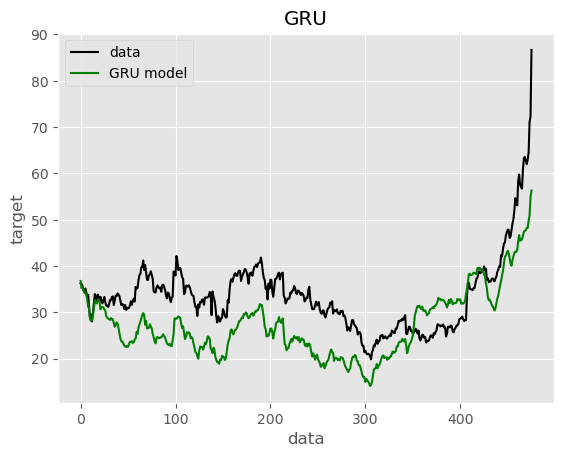

In [44]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='GRU model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('GRU')
plt.legend()
plt.show()


In [45]:
# 傻瓜算法
stupid_actual = mean_actual
stupid_predict = [stupid_actual[0]]
stupid_predict[1:len(stupid_actual)] = stupid_actual[0:len(stupid_actual)-1]
print(len(stupid_actual))
print(len(stupid_predict))
print(stupid_actual)
print(stupid_predict)

476
476
[36.29222277777777, 36.17777844444444, 35.705556222222214, 34.83999977777778, 34.50555422222223, 35.16999988888889, 34.34444511111111, 33.50444544444444, 33.797776999999996, 31.019999222222225, 28.64222211111112, 29.570000555555552, 28.053332888888892, 29.725555444444442, 31.88222244444445, 33.968889, 33.25555422222222, 32.18444488888889, 33.855556888888884, 33.43666588888889, 32.67555411111111, 33.37111066666667, 32.356665666666665, 31.965555777777784, 32.59444511111112, 33.34222077777778, 32.24888777777778, 31.485554999999994, 31.495554555555557, 31.187777999999998, 31.720001222222223, 32.67555411111111, 32.65555488888889, 33.32444588888889, 33.461110444444444, 31.60555688888889, 32.676666222222224, 33.64110988888889, 33.552222333333326, 34.09444511111112, 33.89110988888889, 33.4511108888889, 32.441111222222226, 31.575554777777782, 31.831112333333333, 31.615556555555557, 30.757778555555554, 31.609998888888892, 30.55666777777778, 31.007778555555554, 30.87222288888889, 30.98333

In [46]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(stupid_actual, stupid_predict))
print("mean_squared_error:", mean_squared_error(stupid_actual, stupid_predict))
print("rmse:", sqrt(mean_squared_error(stupid_actual, stupid_predict)))
print("r2 score:", r2_score(stupid_actual, stupid_predict))

mean_absolute_error: 0.8485317514005603
mean_squared_error: 1.9052874866537448
rmse: 1.3803215156816708
r2 score: 0.9704824903890008


In [50]:
trend_actual = []

for i in range(1, len(mean_actual)):
    tmp = mean_actual[i] - mean_actual[i-1]
    if tmp < 0: # down
        trend_actual.append(2)
    elif tmp > 0: # up
        trend_actual.append(0)
    else:
        trend_actual.append(1)

print(len(trend_actual))
trend_actual

475


[2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,


In [27]:
mean_pre[1]

array([27.56467], dtype=float32)

In [51]:
trend_predict = []

for i in range(1, len(mean_pre)):
    tmp = mean_pre[i] - mean_pre[i-1]
    if tmp < 0: # down
        trend_predict.append(2)
    elif tmp > 0: # up
        trend_predict.append(0)
    else:
        trend_predict.append(1)

trend_predict

[2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,


In [52]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(trend_actual, trend_predict))
print("mean_squared_error:", mean_squared_error(trend_actual, trend_predict))
print("rmse:", sqrt(mean_squared_error(trend_actual, trend_predict)))
print("r2 score:", r2_score(trend_actual, trend_predict))

mean_absolute_error: 0.7536842105263157
mean_squared_error: 1.5073684210526315
rmse: 1.2277493315219647
r2 score: -0.5075354609929084


In [53]:
same = 0
for i in range(0, len(trend_actual)):
    if trend_actual[i] == trend_predict[i]:
        same = same + 1
        
ratio = same/len(trend_actual)
ratio

0.6231578947368421